# Final Excercise

## Kriek van der Meulen, 6335233

Here we will explain a few of the details behind our jupiter notebook.

For starters, models that were compared are only accepted if they have a sigma confidence level higher than 3.

Furthermore, our confidence interval's on the parameters found in every model are approximated using the square root of the diagonals of the inverse hessian. This was done because bruteforcing in order to find our confidence intervals would take too long for every star.

Finally, our  models are named thusly:
ULXe  = Ultra-luminous X-ray sources
ULX   = Ultra-luminous X-ray sources
XRB   = Ultrasoft X-ray binaries
SNR   = Blazar or Seyfert (depends on the boundaries)
SNRe1 = Seyfert with Fe emission at 6.4 keV
SNRe2 = Young supernova remnants with emissions: Si XIII at 1.83 keV and S XV at 2.4 keV
SNRe3 = Young supernova remnants with emissions: Si XIII at 1.83 keV, S XV at 2.4 keV and Fe at 6.7 keV

In [354]:
import numpy as np
import scipy.stats as ss
import scipy.optimize as op
import scipy.integrate as si
import matplotlib.pyplot as plt
import math
import random as rand


# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

## Below are two simple examples of exception handling

## Try to import pandas. If not existent, set flag = False, and raise an exception.
try:
    import pandas as pd
    pd_flag = True
except ImportError:
    print("Package pandas not found. Cannot do funky data structures!")
    pd_flag = False
    
## Try to import seaborn.
try:
    import seaborn as sns
    sns_flag = True
    sns.set_style("whitegrid")
    sns.set_style("ticks")
except ImportError:
    sns_flag = False
print("Does seaborn exist on the computer? " + str(sns_flag))

def sigmas_to_p(sigval):
    nd = ss.norm(0., 1.)
    return 2.*nd.sf(sigval)

def p_to_sigmas(pval):
    nd = ss.norm(0., 1.)
# We use the 'inverse survival function', the inverse of the sf. We also need to divide
# our p-value by 2 to account for the negative side of the normal distribution.
    return nd.isf(pval/2.)

Does seaborn exist on the computer? True


First the data is being generated from text and the necessary Stars class is made with all the models defined in it aswell as the histrebin, Chisq_integ and the Poisson functions

In [355]:
star = np.genfromtxt ("energies.txt", dtype=np.float, names=["star", "flux"], autostrip=True)

# initialize class and functions

class Stars:
    instances = []
    def __init__(self, name):
        self.name = name
        self.data = []
        self.mininbin = 20
        self.bins = 250
        self.my_model = []
        self.resulterror =[]
        self.x = []
        self.y = []
        self.dof = []
        self.bwidths = []
        self.yerr = []
        self.xerr = []
        self.iniresult = []
        self.inichi = []
        self.inilog = []
        self.inigoodness = []
        self.minresult = []
        self.minchisq = []
        self.mingood = []
        self.mindof = []
        self.minerror=[]
        self.minlog = []
        self.modens = []
        self.modflux = []
        self.edges = np.array
        self.counts = np.array
        self.edges2 = np.array
        Stars.instances.append(self)
        
    def appenddata(self,data):
        self.data.append(data)
    
    def appenddof(self,dof):
        self.dof.append(dof)
    
    def appendresulterror(self,error):
        self.resulterror.append(error)
        
    def appendresult(self,result):
        self.iniresult.append(result)
    
    def appendgoodness(self,goody):
        self.inigoodness.append(goody)
    
    def appendlog(self,lognorm):
        self.inilog.append(lognorm)
    
    def appendchisq(self,chi):
        self.inichisq.append(chi)
    
    def appendmindof(self,dof):
        self.mindof.append(dof)
    
    def appendminerror(self,error):
        self.minerror.append(error)
        
    def appendminresult(self,result):
        self.minresult.append(result)
    
    def appendmingood(self,goody):
        self.mingood.append(goody)
    
    def appendminchisq(self,chi):
        self.minchisq.append(chi)
        
    def appendminlog(self,lognorm):
        self.minlog.append(lognorm)
    
       
    def histrebin(self): # rebins a histogram so there are at least mininbin counts per bin
        counts, edges = np.histogram(self.data, bins=self.bins, range=[min(Star1.data),max(Star1.data)], density=False)
        if len(self.data) < 500:
            self.counts = counts
            self.edges =  edges
            self.bwidths = np.diff(self.edges)
            self.x = (self.edges[:-1]+self.edges[1:])/2
            self.y = self.counts/self.bwidths
            self.xerr = self.bwidths/2.0
            self.yerr = np.sqrt(self.counts/self.bwidths)
        else:
            edges2=np.zeros(1)
            counts2=np.zeros(1)
            i=0
            countsum=0
            firstbin_flag = 1
            edges2[0]=edges[0]
            for x in counts:
                countsum=countsum+x
                i=i+1
                if countsum >= self.mininbin and (sum(counts[i:]) >= self.mininbin or i == len(counts)):  # The sum over counts in 
                    # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
                    if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                        # do not append but replace bin 0 with countsum
                        counts2[0]=countsum
                        firstbin_flag = 0 # now we read the first bin we can switch this off
                    else:
                        counts2=np.append(counts2,countsum)
                    edges2=np.append(edges2,edges[i])
                    countsum=0

            for i in range(len(edges2)-1):
                self.x.append((edges2[i+1]+edges2[i])/2)

            self.bwidths = np.diff(edges2) # calculates the width of each bin
            self.y = counts2/self.bwidths # determines the count densities
            self.yerr = np.sqrt(counts2)/self.bwidths # calculate the error
            self.xerr = self.bwidths/2.
            self.edges2 = edges2
        
    def ULXe(self,E,N,t,Ecut): # Calculates the ULX model with exp
        E = np.array(E)
        return N*((E**(-1*t)) * np.exp(((-1*E)/Ecut)))
    
    def ULXeem(self,E,N,t,Ecut,Eline1,Norm1): # Calculates the ULX model with exp
        E = np.array(E)
        return N*((E**(-1*t)) * np.exp(((-1*E)/Ecut))) + self.plt_gaussian(E,Eline1,Norm1)
    
    def ULX(self,E,N,t1,t2,Ecut): # Calculates the ULX model
        def func(E):

            if E > Ecut:
                return (N*(Ecut)**(-1*t1))*((E/Ecut)**(-1*t2))
            else:
                return N*(E)**(-1*t1)
        if not np.iterable(E):
            return func(E)
        else:
            return [func(indivE) for indivE in E]


    def ULXem(self,E,N,t1,t2,Ecut,Eline1,Norm1): # Calculates the ULX model
        

        def func(E):

            if E > Ecut:
                return (N*(Ecut)**(-1*t1))*((E/Ecut)**(-1*t2))
            else:
                return N*(E)**(-1*t1)
        if not np.iterable(E):
            return func(E) + self.plt_gaussian(E,Eline1,Norm1)
        else:
            return [func(indivE) for indivE in E] + self.plt_gaussian(E,Eline1,Norm1)
        
    def XRB(self,E,N,kappa): #Calculates XRB's
        E = np.array(E)
        return ((N*(E)**2)/(np.exp(E/kappa)-1))
    
    def XRBem(self,E,N,kappa,Eline1,Norm1): #Calculates XRB's
        E = np.array(E)
        return ((N*(E)**2)/(np.exp(E/kappa)-1)) + self.plt_gaussian(E,Eline1,Norm1)
   
    
    def SNR(self,E,N,t): #calculates SNR and different chaps
        E = np.array(E)
        return (N*E**(-1*t))
    
    def SNRe1(self,E,N,t,Eline1,Norm1): #calculates SNR and different chaps 1 emission
        E = np.array(E)
        return (N*E**(-1*t)) + self.plt_gaussian(E,Eline1,Norm1)
    
    def SNRe2(self,E,N,t,Eline1,Norm1,Eline2,Norm2): #calculates SNR and different chaps 2 emission
        E = np.array(E)
        return (N*E**(-1*t))+ self.plt_gaussian(E,Eline1,Norm1)+ self.plt_gaussian(E,Eline2,Norm2)
    
    def SNRe3(self,E,N,t,Eline1,Norm1,Eline2,Norm2,Eline3,Norm3): #calculates SNR and different chaps3 emission
        E = np.array(E)
        return (N*E**(-1*t))+ self.plt_gaussian(E,Eline1,Norm1)+ self.plt_gaussian(E,Eline2,Norm2)+ self.plt_gaussian(E,Eline3,Norm3)
    
    def plt_gaussian(self,E,Eline,Norm):
        E= np.array(E)
        sigma = 0.06*np.sqrt(Eline)
        return (Norm / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (E - Eline)**2 / (2 * sigma**2))
    
    
    def ChiSq_Integ(self,parm, ebins, yval, dy): # the weighted least-squares for an array of upper and lower bin 
    # edges (xval1 and xval2) fitted with the integral over the bin of the generic model my_model
        i = 0
        ymod = np.zeros(len(yval))
        for energy in ebins[:-1]:
            ymod[i], ymoderr = si.quad(lambda x: self.my_model(x, *parm),ebins[i],ebins[i+1])
            ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
            # units of our data
            i=i+1
        return sum(pow((yval-ymod)/dy,2))
    
    def LogLikelihood_Pois_Integ(self,parm, ebins, yval): # the -ve log-likelihood or an array of bin edges, fitted with 
    # the integral over the bin of the generic model my_fit_model.  Input yval must be counts and not counts per
    # unit x-value
        i = 0
        ymod = np.zeros(len(yval))
        for energy in ebins[:-1]:
            ymod[i], ymoderr = si.quad(lambda x: self.my_model(x, *parm),ebins[i],ebins[i+1])
            # we don't normalise by bin width since the rate parameter is set by the model and needs to be counts per bin
            i=i+1

        pd = ss.poisson(ymod) #we define our Poisson distribution
        return -sum(np.log(pd.pmf(yval))) 


    

Then the data in the text file is associated with the correct object

In [356]:
# Initialize stars and data

Star1 = Stars("Star1")
Star2 = Stars("Star2")
Star3 = Stars("Star3")
Star4 = Stars("Star4")
Star5 = Stars("Star5")
Star6 = Stars("Star6")
Star7 = Stars("Star7")
Star8 = Stars("Star8")
Star9 = Stars("Star9")
Star10 = Stars("Star10")


starlist = [star["star"],star["flux"]]
i=0
while i < len(star["star"]):

    if starlist[0][i]==1:
        Star1.appenddata(starlist[1][i])
    if starlist[0][i] ==2:
        Star2.appenddata(starlist[1][i])
    if starlist[0][i] ==3:
        Star3.appenddata(starlist[1][i])
    if starlist[0][i] ==4:
        Star4.appenddata(starlist[1][i])
    if starlist[0][i] ==5:
        Star5.appenddata(starlist[1][i])
    if starlist[0][i] ==6:
        Star6.appenddata(starlist[1][i])
    if starlist[0][i] ==7:
        Star7.appenddata(starlist[1][i])
    if starlist[0][i] ==8:
        Star8.appenddata(starlist[1][i])
    if starlist[0][i] == 9:
        Star9.appenddata(starlist[1][i])
    if starlist[0][i] ==10:
        Star10.appenddata(starlist[1][i])
    i+=1



here we call histrebin to rebin all the data with a minbin of 20, or in the case of data with less then 300 datapoints we dont rebin the data in order to utilize poisson.

In [357]:


for i in range(len(Stars.instances)):
    Stars.instances[i].x= []
    Stars.instances[i].bwidths = []
    Stars.instances[i].y = []
    Stars.instances[i].yerr = []
    Stars.instances[i].xerr = []
    Stars.instances[i].edges2 = []
    if len(Stars.instances[i].data) < 300:
        Stars.instances[i].bins = 30
    elif len(Stars.instances[i].data) > 1300:
        Stars.instances[i].bins = 150
    else:
        Stars.instances[i].bins = 100
    Stars.instances[i].histrebin()
    
# ### was just for getting a feel of the plots

#     fig,(ax2) = plt.subplots(1,1,figsize=[20,10])
#     fig.suptitle(Stars.instances[i].name, fontsize = 30)
# #     ax1.hist(Stars.instances[i].data,bins=100)
# #     ax1.set_xlabel("Energies (KeV)", fontsize = 20)
# #     ax1.set_ylabel("Photon density (logscaled)", fontsize = 20)
#     ax2.errorbar(Stars.instances[i].x,Stars.instances[i].y,xerr=Stars.instances[i].xerr,yerr=Stars.instances[i].yerr,fmt='o')
#     ax2.set_yscale('log')
#     ax2.set_xlabel("Energies (KeV)", fontsize = 20)
#     ax2.set_ylabel("Photon density (logscaled)", fontsize = 20)



Here we define the initial p0 and boundaries for all the models

In [358]:
ULXeinitials = [1000,1.6022,6],[(None,None),(1.6,3.0),(6.0,9.0)]
ULXinitials = [1000,1.6022,2.6,6],[(None,None),(1.6,2.0),(2.6,3.0),(6.0,9.0)]
XRBinitials = [1000,0.9],[(None,None),(0.8,1.4)]
SNR2initials = [1000,2.5,1.83,20,2.4,20],[(None,None),(2.3,2.8),(1.4,2.0),(0,300),(2.2,2.6),(0,300)]
SNR3initials = [1000,2.5,1.83,20,2.4,20,6.7,20],[(None,None),(2.3,2.8),(1.4,2.0),(0,300),(2.2,2.6),(0,300),(6.4,7.0),(0,300)]
Blazarinitials = [1000,2.3],[(None,None),(2.0,2.5)]
Seyfertinitials = [1000,2],[(None,None),(1.7,2.2)]
Seyferteminitials = [1000,2,6.4,20],[(None,None),(1.7,2.2),(6.0,6.6),(0,300)]

Here we get down to business and utilize each  model to find GoF or log-likelyhoods dependent on how much datapoints is in the raw data.

In [359]:
for i in range(len(Stars.instances)):
    
    Stars.instances[i].inilog = []
    Stars.instances[i].iniresult = []
    Stars.instances[i].resulterror= []
    Stars.instances[i].inichisq = []
    Stars.instances[i].inigoodness = []
    print Stars.instances[i].name
    for j in range(8):
        if j == 0:
#             Xray sources e powah
            Stars.instances[i].my_model = Stars.instances[i].ULXe
            p0 = ULXeinitials[0]
            bounds = ULXeinitials[1]
        if j == 1:
#             Xray sources
            Stars.instances[i].my_model = Stars.instances[i].ULX
            p0 = ULXinitials[0]
            bounds = ULXinitials[1]
        if j == 2:
#             Xray Binaries
            Stars.instances[i].my_model = Stars.instances[i].XRB
            p0 = XRBinitials[0]
            bounds = XRBinitials[1]
        if j == 3:
#             SNR two emissions
            Stars.instances[i].my_model = Stars.instances[i].SNRe2
            p0 = SNR2initials[0]
            bounds = SNR2initials[1]
        if j == 4:
#             SNR three emissions
            Stars.instances[i].my_model = Stars.instances[i].SNRe3
            p0 = SNR3initials[0]
            bounds = SNR3initials[1]
        if j == 5:
#             Blazar
            Stars.instances[i].my_model = Stars.instances[i].SNR
            p0 = Blazarinitials[0]
            bounds = Blazarinitials[1]
        if j == 6:
#             Seyfert
            Stars.instances[i].my_model = Stars.instances[i].SNR
            p0 = Seyfertinitials[0]
            bounds = Seyfertinitials[1]
        if j == 7:
#             Seyfert emission
            Stars.instances[i].my_model = Stars.instances[i].SNRe1
            p0 = Seyferteminitials[0]
            bounds = Seyferteminitials[1]
        
        if len(Stars.instances[i].data) > 500:
            result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                           ,Stars.instances[i].yerr), method='L-BFGS-B', 
                         bounds=bounds)
            Stars.instances[i].appendresult(result.x) # best-fitting parameter values
            Stars.instances[i].appendresulterror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
            Stars.instances[i].appendchisq(result.fun) # value of the function minimised (e.g. chi-squared)
            dof = len(Stars.instances[i].y) - len(p0)
            Stars.instances[i].appendgoodness(ss.chi2.sf(result.fun, df=dof))
            Stars.instances[i].appenddof(dof)
        else:
            result = op.minimize(Stars.instances[i].LogLikelihood_Pois_Integ, p0, args=(Stars.instances[i].edges, Stars.instances[i].counts), method='L-BFGS-B', bounds=bounds)
            Stars.instances[i].appendresult(result.x) # best-fitting parameter values
            Stars.instances[i].appendresulterror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
            Stars.instances[i].appendlog(-1.0*result.fun)
            dof = len(Stars.instances[i].y) - len(p0)
            Stars.instances[i].appenddof(dof)

            
            
methodlist= "ULXe","ULX","XRB","SNRem2","SNRem3","Blazar","Seyfert","Seyfertem"
for i in range(len(Stars.instances)):
    print "Star = %s" %Stars.instances[i].name
    print "%i"% Stars.instances[i].bins
    print "---------------------------------------------------------------" 
    if len(Stars.instances[i].data) > 500:
        for j in range(len(Stars.instances[i].inichisq)):
            print "%s"% methodlist[j]

            print "Chisq = %0.2f and a GoF = %0.2e with DoF of %0.3f"%(Stars.instances[i].inichisq[j],Stars.instances[i].inigoodness[j],Stars.instances[i].dof[j])
        print "---------------------------------------------------------------"
    else:
        for j in range(len(Stars.instances[i].inilog)):
            print "%s"% methodlist[j]

            print "Loglikelyhood = %0.2f with DoF of %0.3f"%(Stars.instances[i].inilog[j],Stars.instances[i].dof[j])
        print "---------------------------------------------------------------"


Star1
Star2
Star3
Star4
Star5
Star6
Star7
Star8
Star9
Star10
Star = Star1
150
---------------------------------------------------------------
ULXe
Chisq = 117.07 and a GoF = 2.21e-03 with DoF of 77.000
ULX
Chisq = 100.42 and a GoF = 3.18e-02 with DoF of 76.000
XRB
Chisq = 2230.63 and a GoF = 0.00e+00 with DoF of 78.000
SNRem2
Chisq = 417.39 and a GoF = 2.39e-49 with DoF of 74.000
SNRem3
Chisq = 396.22 and a GoF = 2.65e-46 with DoF of 72.000
Blazar
Chisq = 198.27 and a GoF = 1.95e-12 with DoF of 78.000
Seyfert
Chisq = 198.27 and a GoF = 1.95e-12 with DoF of 78.000
Seyfertem
Chisq = 190.00 and a GoF = 9.74e-12 with DoF of 76.000
---------------------------------------------------------------
Star = Star2
150
---------------------------------------------------------------
ULXe
Chisq = 206.25 and a GoF = 5.73e-14 with DoF of 76.000
ULX
Chisq = 157.43 and a GoF = 8.52e-08 with DoF of 75.000
XRB
Chisq = 2603.47 and a GoF = 0.00e+00 with DoF of 77.000
SNRem2
Chisq = 200.93 and a GoF = 6.84e-1

Here we define the plot function and the print functions

In [360]:
def plotstuff(i,j,mini):
    if mini == False:
        fig,(ax1,ax2) = plt.subplots(2,1,figsize=[20,20])
        ax1.set_xlabel("Energies (KeV)",fontsize=18)
        ax1.set_ylabel("Photon density (logscaled)",fontsize=18)
        ax1.set_yscale('log')
        ax2.set_xlabel("Energies (KeV)",fontsize=18)
        ax2.set_ylabel("Residuals (data/model)",fontsize=18)


        ax1.errorbar(Stars.instances[i].x,Stars.instances[i].y,xerr = Stars.instances[i].xerr,yerr=Stars.instances[i].yerr,fmt='o')
        ax1.plot(Stars.instances[i].x,Stars.instances[i].my_model(Stars.instances[i].x,*Stars.instances[i].iniresult[j]),color= "red",linestyle="dotted",lw=3)
        ax2.errorbar(Stars.instances[i].x, (Stars.instances[i].y - Stars.instances[i].my_model(Stars.instances[i].x,*Stars.instances[i].iniresult[j]))/Stars.instances[i].y, xerr= Stars.instances[i].xerr,yerr=Stars.instances[i].yerr/Stars.instances[i].y, marker="o", linestyle='')
        ax2.plot(Stars.instances[i].x, (Stars.instances[i].y - Stars.instances[i].my_model(Stars.instances[i].x,*Stars.instances[i].iniresult[j]))/Stars.instances[i].y, 'o')
        ax2.axhline(0.0, color='r', linestyle='dotted', lw=2)
        plt.show()
    else:
        fig,(ax1,ax2) = plt.subplots(2,1,figsize=[20,20])
        ax1.set_xlabel("Energies (KeV)",fontsize=18)
        ax1.set_ylabel("Photon density (logscaled)",fontsize=18)
        ax1.set_yscale('log')
        ax2.set_xlabel("Energies (KeV)",fontsize=18)
        ax2.set_ylabel("Residuals (data/model)",fontsize=18)


        ax1.errorbar(Stars.instances[i].x,Stars.instances[i].y,xerr = Stars.instances[i].xerr,yerr=Stars.instances[i].yerr,fmt='o')
        ax1.plot(Stars.instances[i].x,Stars.instances[i].my_model(Stars.instances[i].x,*Stars.instances[i].minresult[j]),color= "red",linestyle="dotted",lw=3)
        ax2.errorbar(Stars.instances[i].x, (Stars.instances[i].y - Stars.instances[i].my_model(Stars.instances[i].x,*Stars.instances[i].minresult[j]))/Stars.instances[i].y, xerr= Stars.instances[i].xerr,yerr=Stars.instances[i].yerr/Stars.instances[i].y, marker="o", linestyle='')
        ax2.plot(Stars.instances[i].x, (Stars.instances[i].y - Stars.instances[i].my_model(Stars.instances[i].x,*Stars.instances[i].minresult[j]))/Stars.instances[i].y, 'o')
        ax2.axhline(0.0, color='r', linestyle='dotted', lw=2)
        plt.show()

def printinilogorchi(i,j,p):
    if p == False:
        print "Minimum Chi-squared = %0.3f"%(Stars.instances[i].inichisq[j]) + " for %i"%(Stars.instances[i].dof[j]) + " d.o.f."
        print "The goodness of fit is: %.3g" % Stars.instances[i].inigoodness[j]
    else:
        print "Loglikelyhood = %0.3f"%(Stars.instances[i].inilog[j]) + " for %i"%(Stars.instances[i].dof[j]) + " d.o.f."
        
def printminlogorchi(i,j,p):
    if p == False:
        print "Minimum Chi-squared = %0.3f"%(Stars.instances[i].minchisq[j]) + " for %i"%(Stars.instances[i].mindof[j]) + " d.o.f."
        print "The goodness of fit is: %.3g" % Stars.instances[i].mingood[j]
    else:
        print "Loglikelyhood = %0.3f"%(Stars.instances[i].minlog[j]) + " for %i"%(Stars.instances[i].mindof[j]) + " d.o.f."
    
def printXRB(i,j,mini,em,p):
    if mini == False:
        print "N0 = %0.3f"%(Stars.instances[i].iniresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][0])
        print "KbT = %0.3f"%(Stars.instances[i].iniresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][1])
        printinilogorchi(i,j,p)
    else:
        if em == 0:
            print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
            print "KbT = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
            printminlogorchi(i,j,p)
        if em == 1:
            print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
            print "KbT = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
            print "E_line = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
            print "Nlc = %0.3f"%(Stars.instances[i].minresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][3])
            printminlogorchi(i,j,p)

def printSNR(i,j,mini,em,p):
    if mini == False:
            if em ==0:
                print "N0 = %0.3f" %(Stars.instances[i].iniresult[j][0]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][0])
                print "gamma = %0.3f" %(Stars.instances[i].iniresult[j][1]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][1])
                printinilogorchi(i,j,p)
            if em == 1:
                print "N0 = %0.3f" %(Stars.instances[i].iniresult[j][0]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][0])
                print "gamma = %0.3f" %(Stars.instances[i].iniresult[j][1]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][1])
                print "E_line1 = %0.3f"%(Stars.instances[i].iniresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][2])
                print "Nlc1 = %0.3f"%(Stars.instances[i].iniresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][3])
                printinilogorchi(i,j,p)
                
            if em == 2:
                print "N0 = %0.3f" %(Stars.instances[i].iniresult[j][0]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][0])
                print "gamma = %0.3f" %(Stars.instances[i].iniresult[j][1]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][1])
                print "E_line1 = %0.3f"%(Stars.instances[i].iniresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][2])
                print "Nlc1 = %0.3f"%(Stars.instances[i].iniresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][3])
                print "E_line2 = %0.3f"%(Stars.instances[i].iniresult[j][4]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][4])
                print "Nlc2 = %0.3f"%(Stars.instances[i].iniresult[j][5]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][5])
                printinilogorchi(i,j,p)
            
            if em == 3:
                print "N0 = %0.3f" %(Stars.instances[i].iniresult[j][0]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][0])
                print "gamma = %0.3f" %(Stars.instances[i].iniresult[j][1]) + " +/-  %0.3f" %(Stars.instances[i].resulterror[j][1])
                print "E_line1 = %0.3f"%(Stars.instances[i].iniresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][2])
                print "Nlc1 = %0.3f"%(Stars.instances[i].iniresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][3])
                print "E_line2 = %0.3f"%(Stars.instances[i].iniresult[j][4]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][4])
                print "Nlc2 = %0.3f"%(Stars.instances[i].iniresult[j][5]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][5])
                print "E_line3 = %0.3f"%(Stars.instances[i].iniresult[j][6]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][6])
                print "Nlc3 = %0.3f"%(Stars.instances[i].iniresult[j][7]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][7])
                printinilogorchi(i,j,p)
    else:
            if em ==0:
                print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
                print "gamma = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
                printminlogorchi(i,j,p)
                
            if em == 1:
                print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
                print "gamma = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
                print "E_line1 = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
                print "Nlc1 = %0.3f"%(Stars.instances[i].minresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][3])
                printminlogorchi(i,j,p)
                
            if em == 2:
                print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
                print "gamma = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
                print "E_line1 = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
                print "Nlc1 = %0.3f"%(Stars.instances[i].minresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][3])
                print "E_line2 = %0.3f"%(Stars.instances[i].minresult[j][4]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][4])
                print "Nlc2 = %0.3f"%(Stars.instances[i].minresult[j][5]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][5])
                printminlogorchi(i,j,p)
            
            if em == 3:
                print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
                print "gamma = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
                print "E_line1 = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
                print "Nlc1 = %0.3f"%(Stars.instances[i].minresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][3])
                print "E_line2 = %0.3f"%(Stars.instances[i].minresult[j][4]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][4])
                print "Nlc2 = %0.3f"%(Stars.instances[i].minresult[j][5]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][5])
                print "E_line3 = %0.3f"%(Stars.instances[i].minresult[j][6]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][6])
                print "Nlc3 = %0.3f"%(Stars.instances[i].minresult[j][7]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][7])
                printminlogorchi(i,j,p)
        
        
def printULX(i,j,mini,em,p):
    if mini == False:
        print "N0 = %0.3f"%(Stars.instances[i].iniresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][0])
        print "gamma1 = %0.3f"%(Stars.instances[i].iniresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][1])
        print "gamma2 = %0.3f"%(Stars.instances[i].iniresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][2])
        print "E_break = %0.3f"%(Stars.instances[i].iniresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][3])
        printinilogorchi(i,j,p)
    else:
        if em == 0:
            print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
            print "gamma1 = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
            print "gamma2 = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
            print "E_break = %0.3f"%(Stars.instances[i].minresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][3])
            printminlogorchi(i,j,p)
        if em == 1:
            print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
            print "gamma1 = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
            print "gamma2 = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
            print "E_break = %0.3f"%(Stars.instances[i].minresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][3])
            print "E_line = %0.3f"%(Stars.instances[i].minresult[j][4]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][4])
            print "Nlc = %0.3f"%(Stars.instances[i].minresult[j][5]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][5])
            printminlogorchi(i,j,p)
            
def printULXe(i,j,mini,em,p):
    if mini == False:
        print "N0 = %0.3f"%(Stars.instances[i].iniresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][0])
        print "gamma = %0.3f"%(Stars.instances[i].iniresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][1])
        print "E_cut = %0.3f"%(Stars.instances[i].iniresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].resulterror[j][2])
        printinilogorchi(i,j,p)
    else:
        if em == 0:
            print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
            print "gamma = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
            print "E_cut = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
            printminlogorchi(i,j,p)
        if em == 1:
            print "N0 = %0.3f"%(Stars.instances[i].minresult[j][0]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][0])
            print "gamma = %0.3f"%(Stars.instances[i].minresult[j][1]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][1])
            print "E_cut = %0.3f"%(Stars.instances[i].minresult[j][2]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][2])
            print "E_line = %0.3f"%(Stars.instances[i].minresult[j][3]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][3])
            print "Nlc = %0.3f"%(Stars.instances[i].minresult[j][4]) + " +/-  %0.3f"%(Stars.instances[i].minerror[j][4])
            printminlogorchi(i,j,p)
        

## Star 1 Evaluation

Selecting the best goodness of fit amongst our initial supplied models we get the ULX model best describing Star1 datawith:
N0 = 10161.620 +/-  114.039
gamma1 = 1.951 +/-  0.011
gamma2 = 2.922 +/-  0.061
E_break = 7.925 +/-  0.335
Minimum Chi-squared = 100.425 for 76 d.o.f.
The goodness of fit is: 0.0318


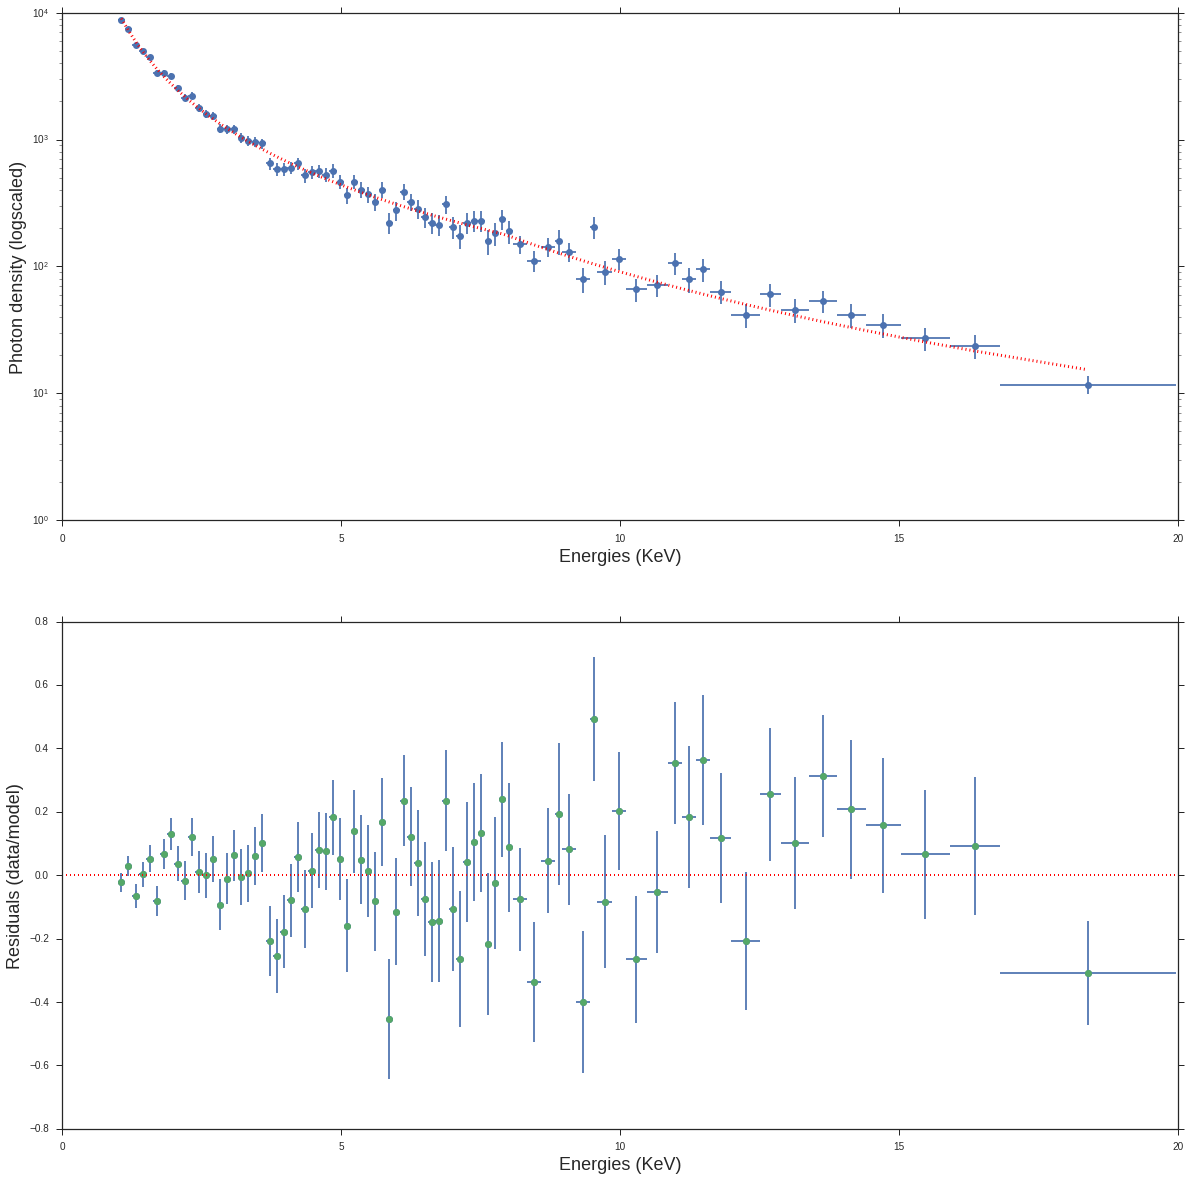

Looking at the plots and the residuals there apears to be some kind of line around 11 KeV
So we will try to fit an guassian to that spot to see if an emission line improves the fit
-----------------------------------------------------
N0 = 10167.361 +/-  106.505
gamma1 = 1.952 +/-  0.007
gamma2 = 2.952 +/-  0.084
E_break = 7.870 +/-  0.177
E_line = 11.409 +/-  0.172
Nlc = 18.634 +/-  5.745
Minimum Chi-squared = 95.542 for 74 d.o.f.
The goodness of fit is: 0.0468


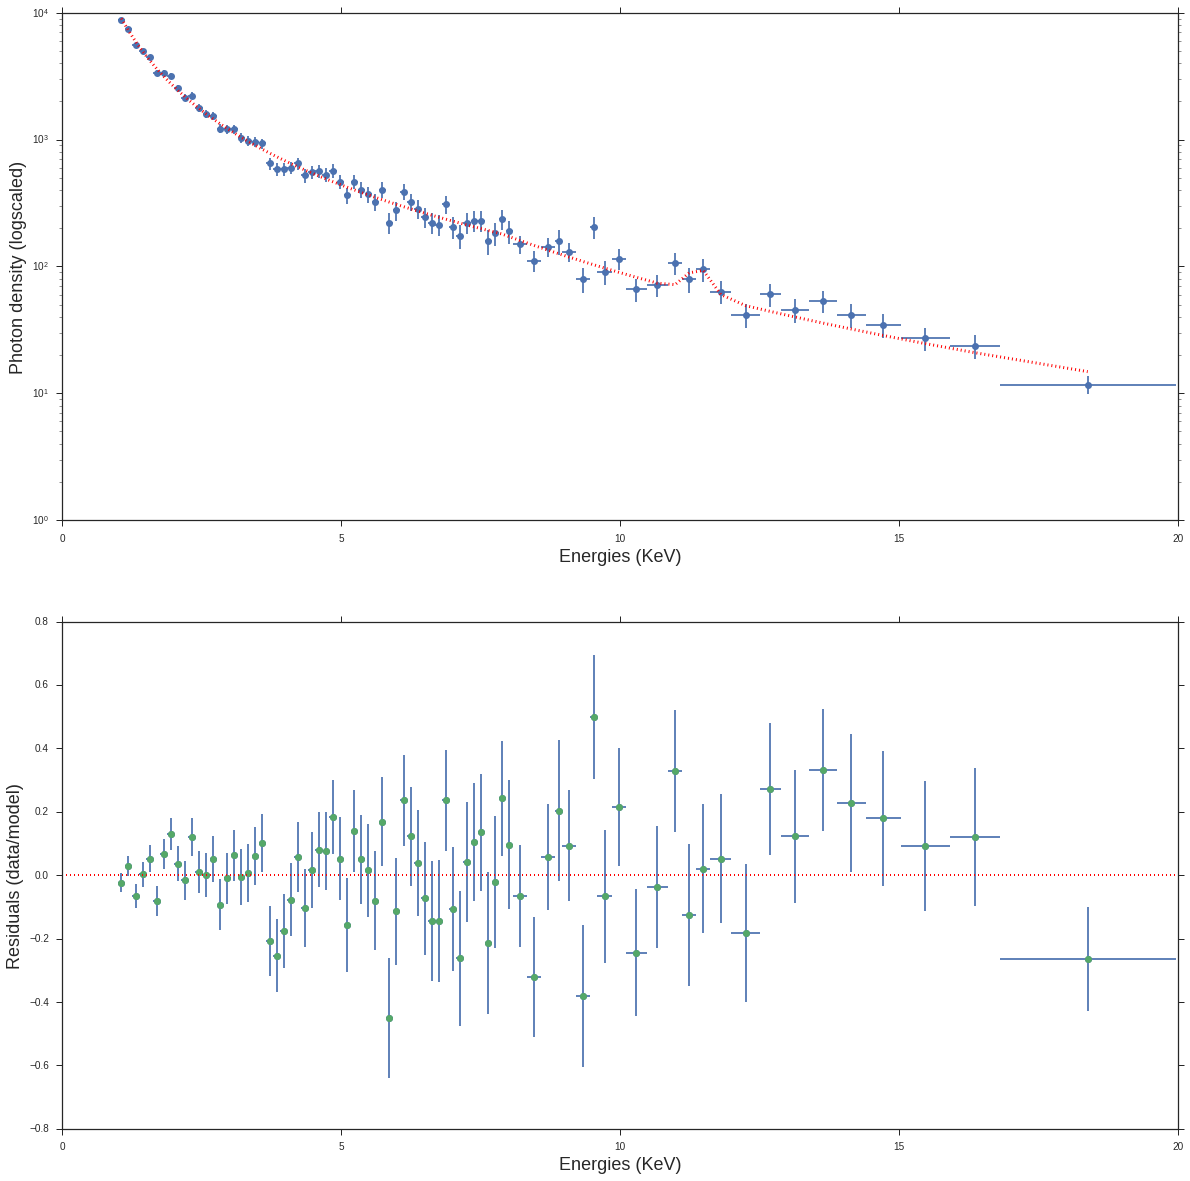

Delta chi-squared = 4.88
p-value for our delta-chi-squared: 0.0271
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which clearly is not a significant line
-----------------------------------------------------
We then tried fitting an emission line to a KeV of around 13
-----------------------------------------------------
N0 = 10162.315 +/-  72.081
gamma1 = 1.951 +/-  0.008
gamma2 = 2.947 +/-  0.108
E_break = 7.918 +/-  0.194
E_line = 13.000 +/-  0.420
Nlc = 6.901 +/-  5.275
Minimum Chi-squared = 99.403 for 74 d.o.f.
The goodness of fit is: 0.0261


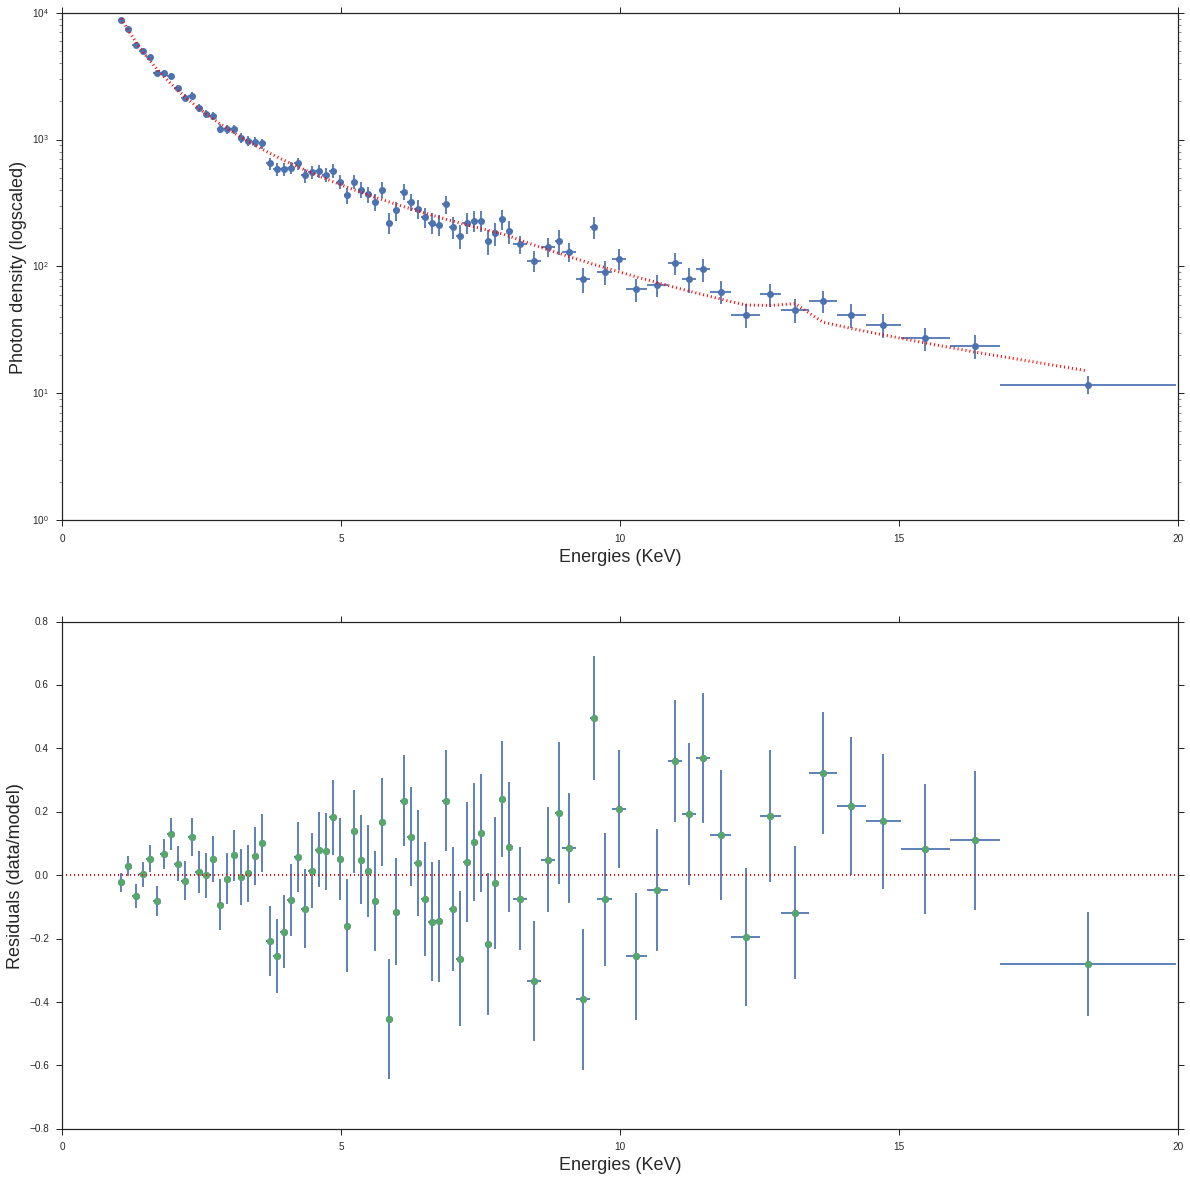

Delta chi-squared = 1.02
p-value for our delta-chi-squared: 0.312
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which clearly is not a significant line
-----------------------------------------------------
Looking closely at our initial results we find that gamma2 is upper-bounded by the given boundary of 3.0
In order to further improve our goodness of fit we can try setting that parameter free
-----------------------------------------------------
N0 = 10161.620 +/-  1.000
gamma1 = 1.951 +/-  1.000
gamma2 = 2.922 +/-  1.000
E_break = 7.925 +/-  1.000
Minimum Chi-squared = 100.425 for 76 d.o.f.
The goodness of fit is: 0.0318


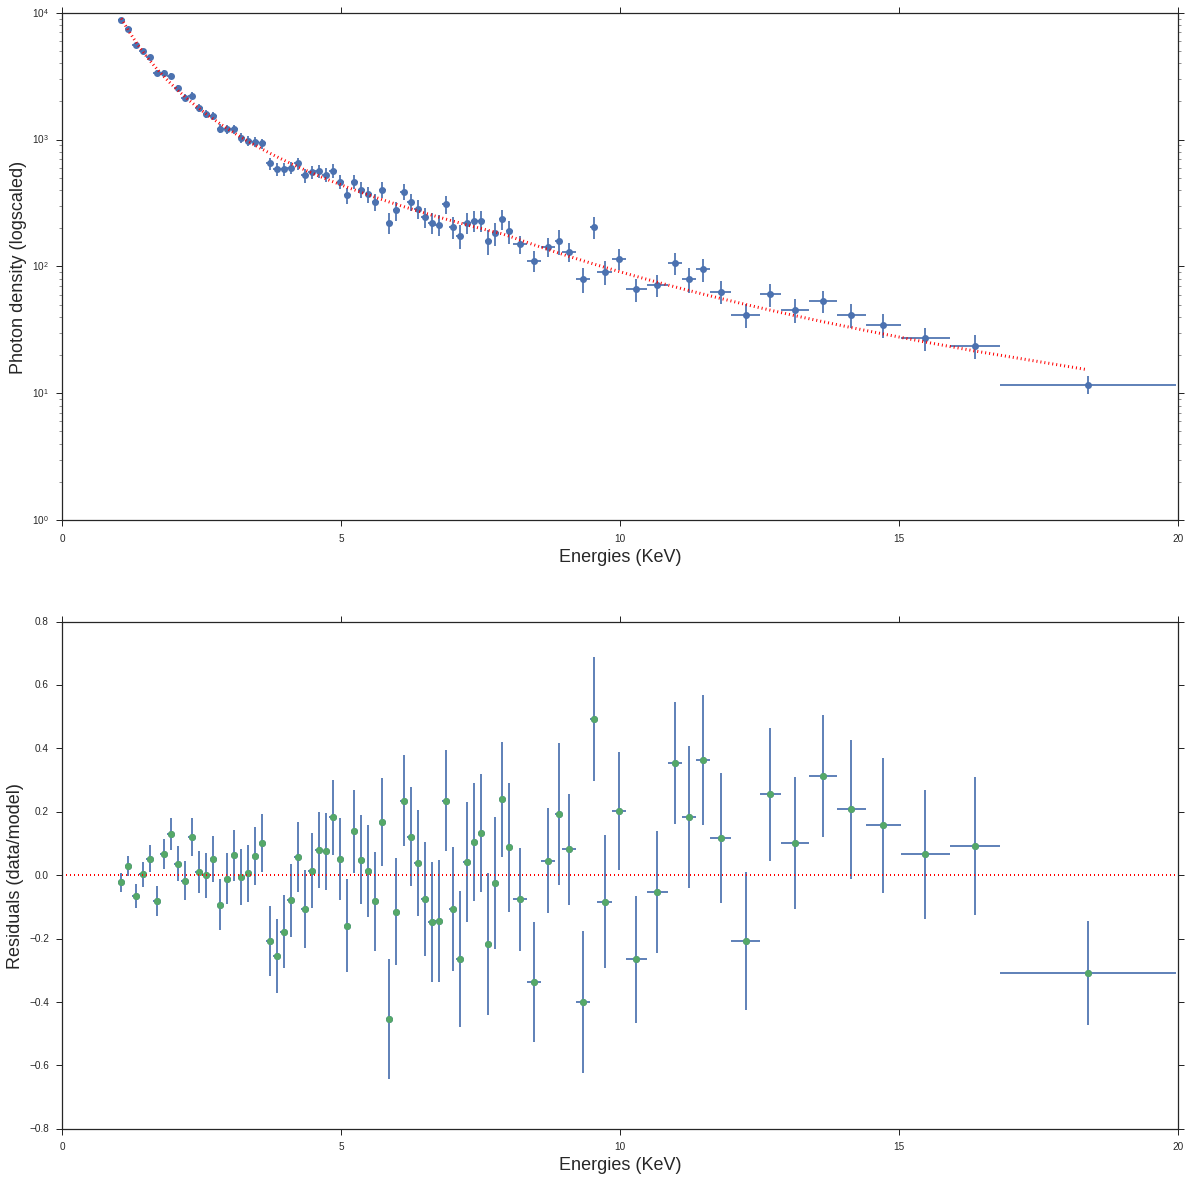

Delta chi-squared = 0.00
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which clearly is not a significant
-----------------------------------------------------
This leaves us to conclude that while the ULX model seems to have the best fit out of all models supplied
With a goodness of fit of 0.0318 


In [361]:

i = 0
j = 1
print "Selecting the best goodness of fit amongst our initial supplied models we get the ULX model best describing Star1 data\
with:"
printULX(i,j,False,0,False)

Stars.instances[i].my_model = Stars.instances[i].ULX
plotstuff(i,j,False)

print "Looking at the plots and the residuals there apears to be some kind of line around 11 KeV"
print "So we will try to fit an guassian to that spot to see if an emission line improves the fit"
print "-----------------------------------------------------"

Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minchisq = []
Stars.instances[i].mindof = []
Stars.instances[i].mingood = []
Stars.instances[i].my_model = Stars.instances[i].ULXem
p0 = [1000,1.6022,2.6,6,11,-20]
bounds = [(None,None),(1.6,2.0),(2.6,3.0),(6.0,9.0),(11,12),(-60,300)]

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 0

printULX(i,g,True,True,False)
plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06*np.sqrt(Stars.instances[i].minresult[g][4])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which clearly is not a significant line"
print "-----------------------------------------------------"
print "We then tried fitting an emission line to a KeV of around 13"
print "-----------------------------------------------------"
Stars.instances[i].my_model = Stars.instances[i].ULXem
p0 = [1000,1.6022,2.6,6,13,-20]
bounds = [(None,None),(1.6,2.0),(2.6,3.0),(6.0,9.0),(13,14),(-60,300)]

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 1

printULX(i,g,True,1,False)
plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06*np.sqrt(Stars.instances[i].minresult[g][4])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which clearly is not a significant line"
print "-----------------------------------------------------"
print "Looking closely at our initial results we find that gamma2 is upper-bounded by the given boundary of 3.0"
print "In order to further improve our goodness of fit we can try setting that parameter free"
print "-----------------------------------------------------"

Stars.instances[i].my_model = Stars.instances[i].ULX
p0 = Stars.instances[i].iniresult[j]
bounds = [(None,None),(1.6,2.0),(None,None),(6.0,9.0)]

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 2
printULX(i,g,True,0,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which clearly is not a significant"
print "-----------------------------------------------------"
print "This leaves us to conclude that while the ULX model seems to have the best fit out of all models supplied"
print "With a goodness of fit of %.3g " % Stars.instances[i].inigoodness[j]


## Star 1 Result



So the ULX model seems to have the best fit out of all models supplied.
However, with a goodness of fit of only 0.0318 it is highly unlikely that the source is indeed an Ultra-Luminous Xray source. Thus the data is most likely better described by an unknown model.

the parameters of our model:
N0 = 10161.620 +/-  114.039
gamma1 = 1.951 +/-  0.011
gamma2 = 2.922 +/-  0.061
E_break = 7.925 +/-  0.335
Minimum Chi-squared = 100.425 for 76 d.o.f.
The goodness of fit is: 0.0318


## Star 2 Evaluation

Seeing that the goodness of fit for the blazar, the seyfert galaxy and the seyfert galaxy with emission lie so close to each other
I will compare the models with each other
-------------------------------------------------
Blazar
-------------------------------------------------
N0 = 11761.984 +/-  101.878
gamma = 2.131 +/-  0.006
Minimum Chi-squared = 94.897 for 77 d.o.f.
The goodness of fit is: 0.0813


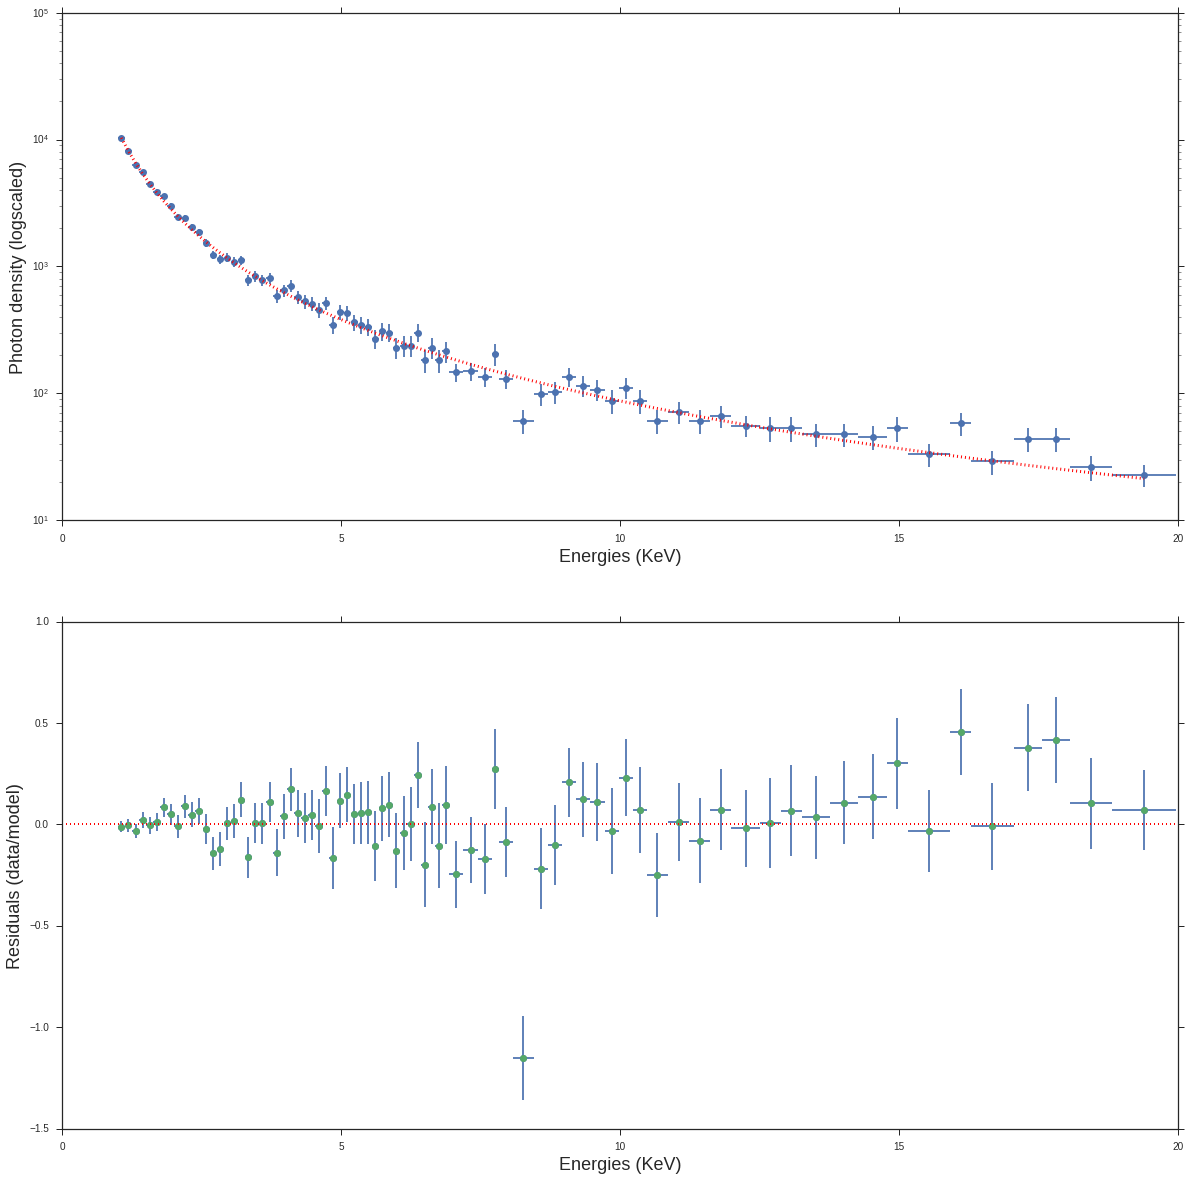

-------------------------------------------------
Seyfert
-------------------------------------------------
N0 = 11761.999 +/-  87.875
gamma = 2.131 +/-  0.007
Minimum Chi-squared = 94.897 for 77 d.o.f.
The goodness of fit is: 0.0813


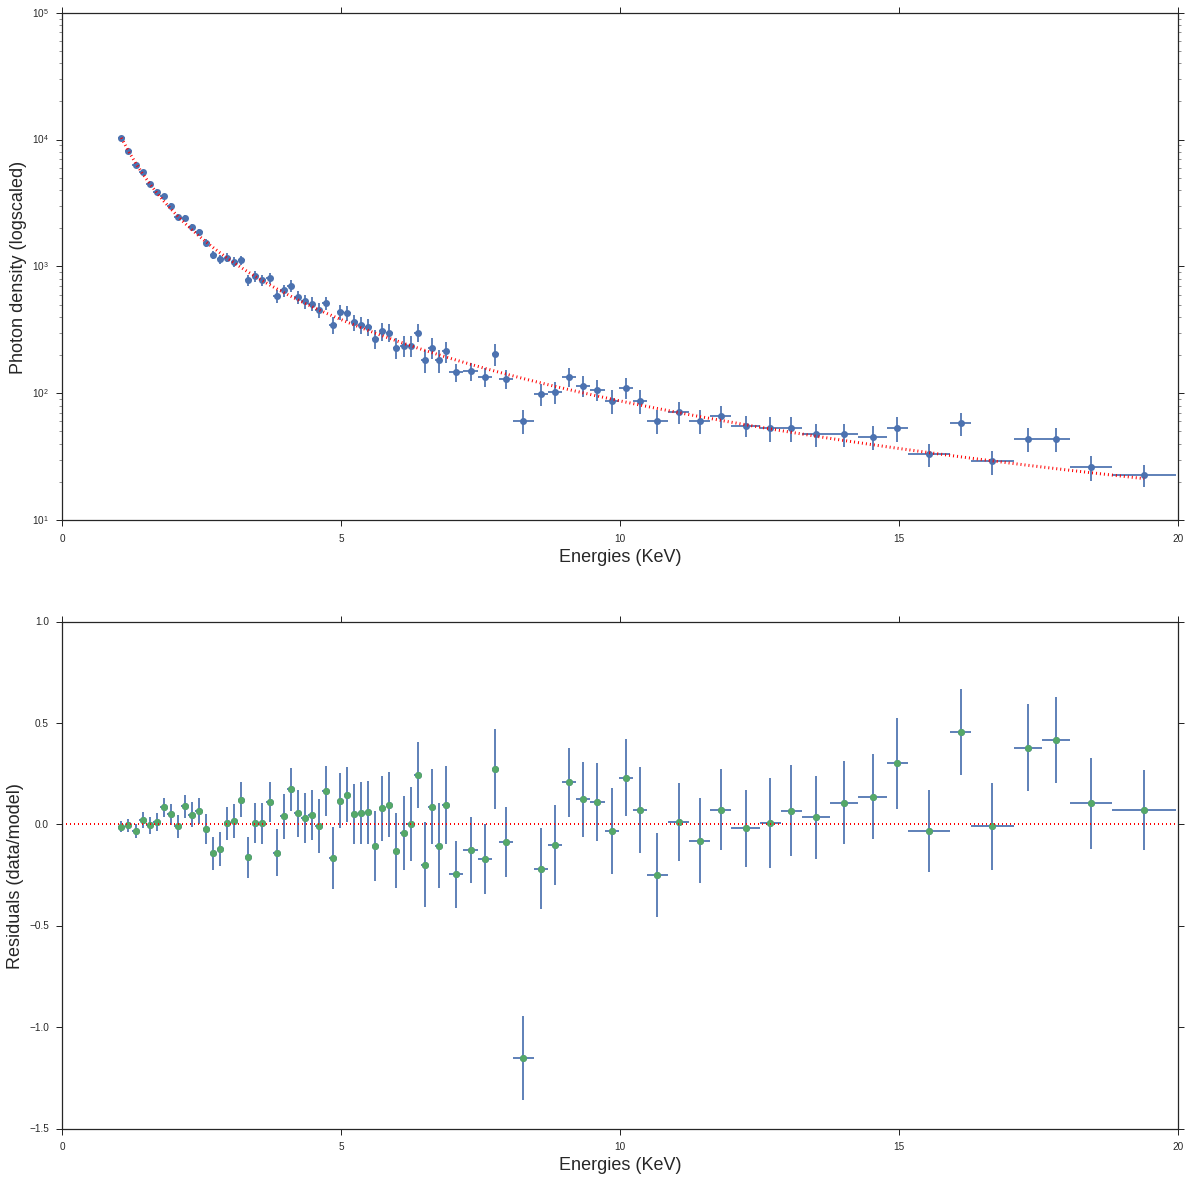

Delta chi-squared = 0.00
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant so we choose to keep comparing with the Blazar
-------------------------------------------------
Seyfertem
-------------------------------------------------
N0 = 11762.022 +/-  82.221
gamma = 2.131 +/-  0.006
E_line1 = 6.000 +/-  0.451
Nlc1 = 0.000 +/-  28.181
Minimum Chi-squared = 94.897 for 75 d.o.f.
The goodness of fit is: 0.0602


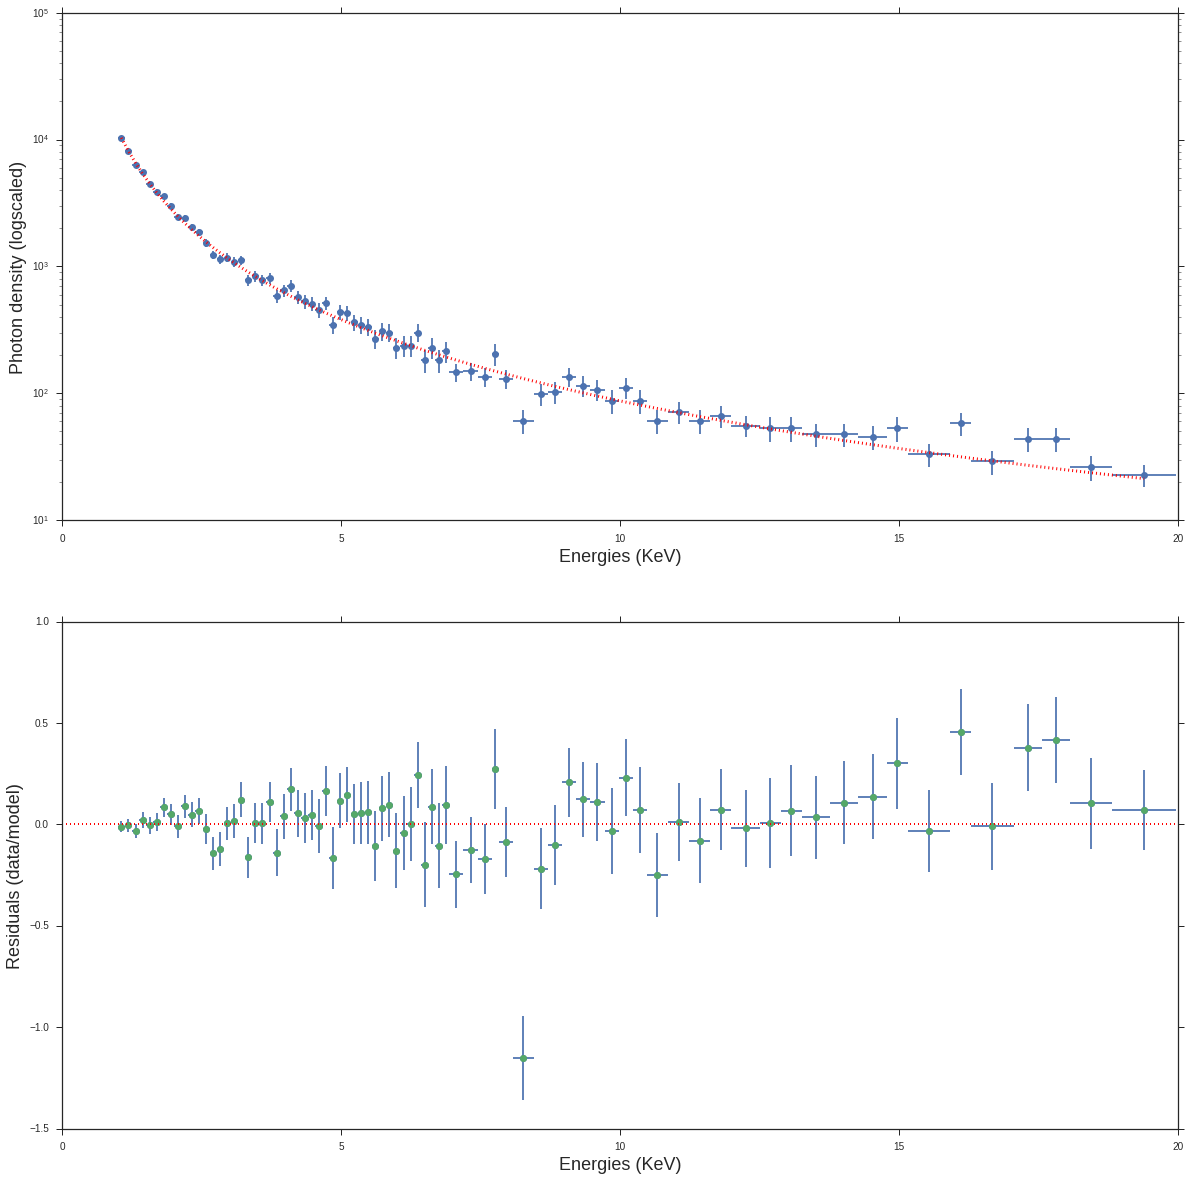

Delta chi-squared = 0.00
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant so we chose the Blazar
-------------------------------------------------
looking closely at the plot there seems to be an absorption line around 7 KeV so using the Blazar model we try to fit an absorption line
-------------------------------------------------
N0 = 11652.873 +/-  123.730
gamma = 2.110 +/-  0.007
E_line1 = 8.302 +/-  0.059
Nlc1 = -39.410 +/-  4.539
Minimum Chi-squared = 60.434 for 75 d.o.f.
The goodness of fit is: 0.889


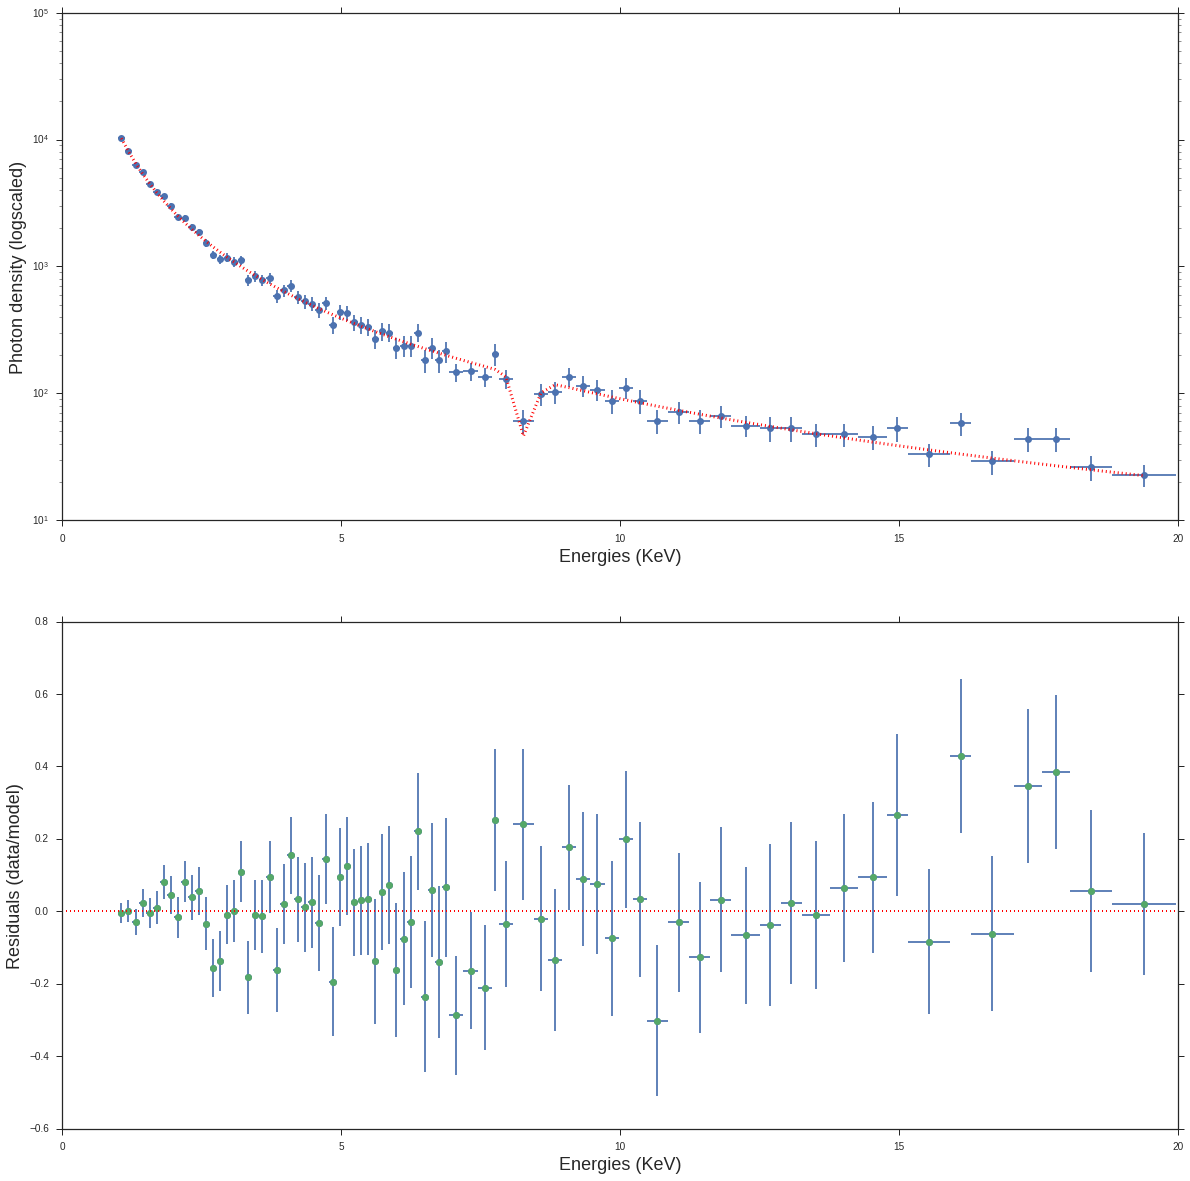

Delta chi-squared = 34.46
p-value for our delta-chi-squared: 4.34e-09
p-value corrected for number of trials: 1.99e-06, which corresponds to a 4-sigma confidence level
which is significant so we chose to keep this alteration to the blazar model
------------------------------------------------------------------------
Looking closer around 17.5 KeV there seems to be an emision line aswell so we will try to fit that with our current model
------------------------------------------------------------------------
N0 = 11805.614 +/-  120.357
gamma = 2.138 +/-  0.008
E_line1 = 9.000 +/-  0.094
Nlc1 = 5.908 +/-  7.023
E_line2 = 17.582 +/-  0.083
Nlc2 = 18.822 +/-  5.671
Minimum Chi-squared = 87.338 for 73 d.o.f.
The goodness of fit is: 0.121


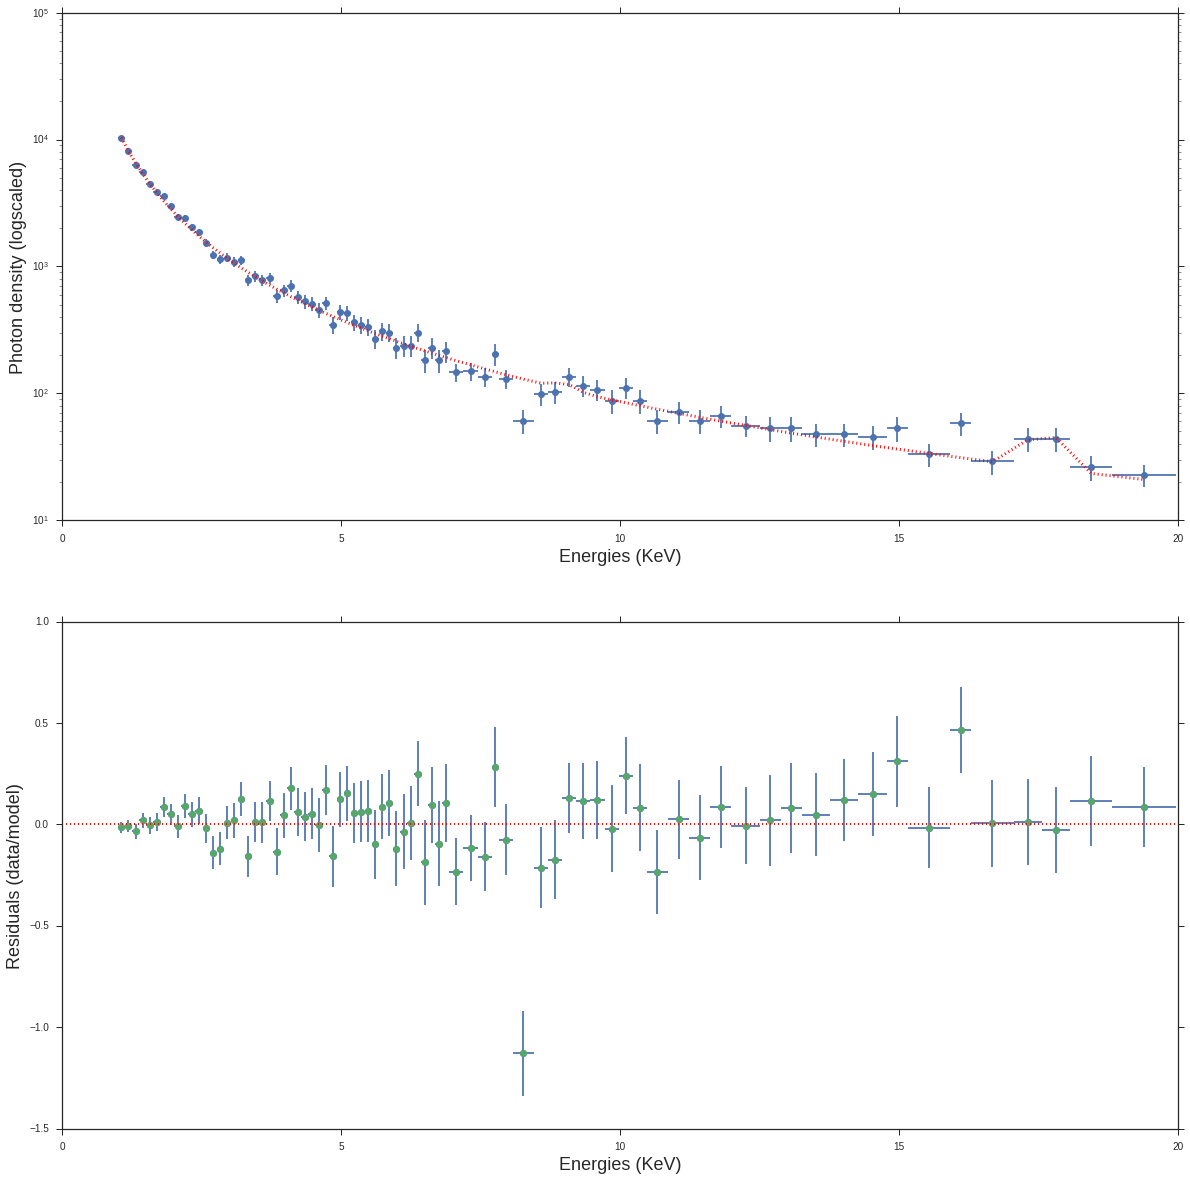

Delta chi-squared = -26.90
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose to deject this alteration to the model
-------------------------------------------------------------------------
now the only remaining thing to do is to compare our Blazar model featuring an absorption line at  8.3 
with a Seyfert model with the same absorption line:
N0 = 11652.908 +/-  240.402
gamma = 2.110 +/-  0.008
E_line1 = 8.302 +/-  0.035
Nlc1 = -39.410 +/-  8.301
Minimum Chi-squared = 60.434 for 75 d.o.f.
The goodness of fit is: 0.889


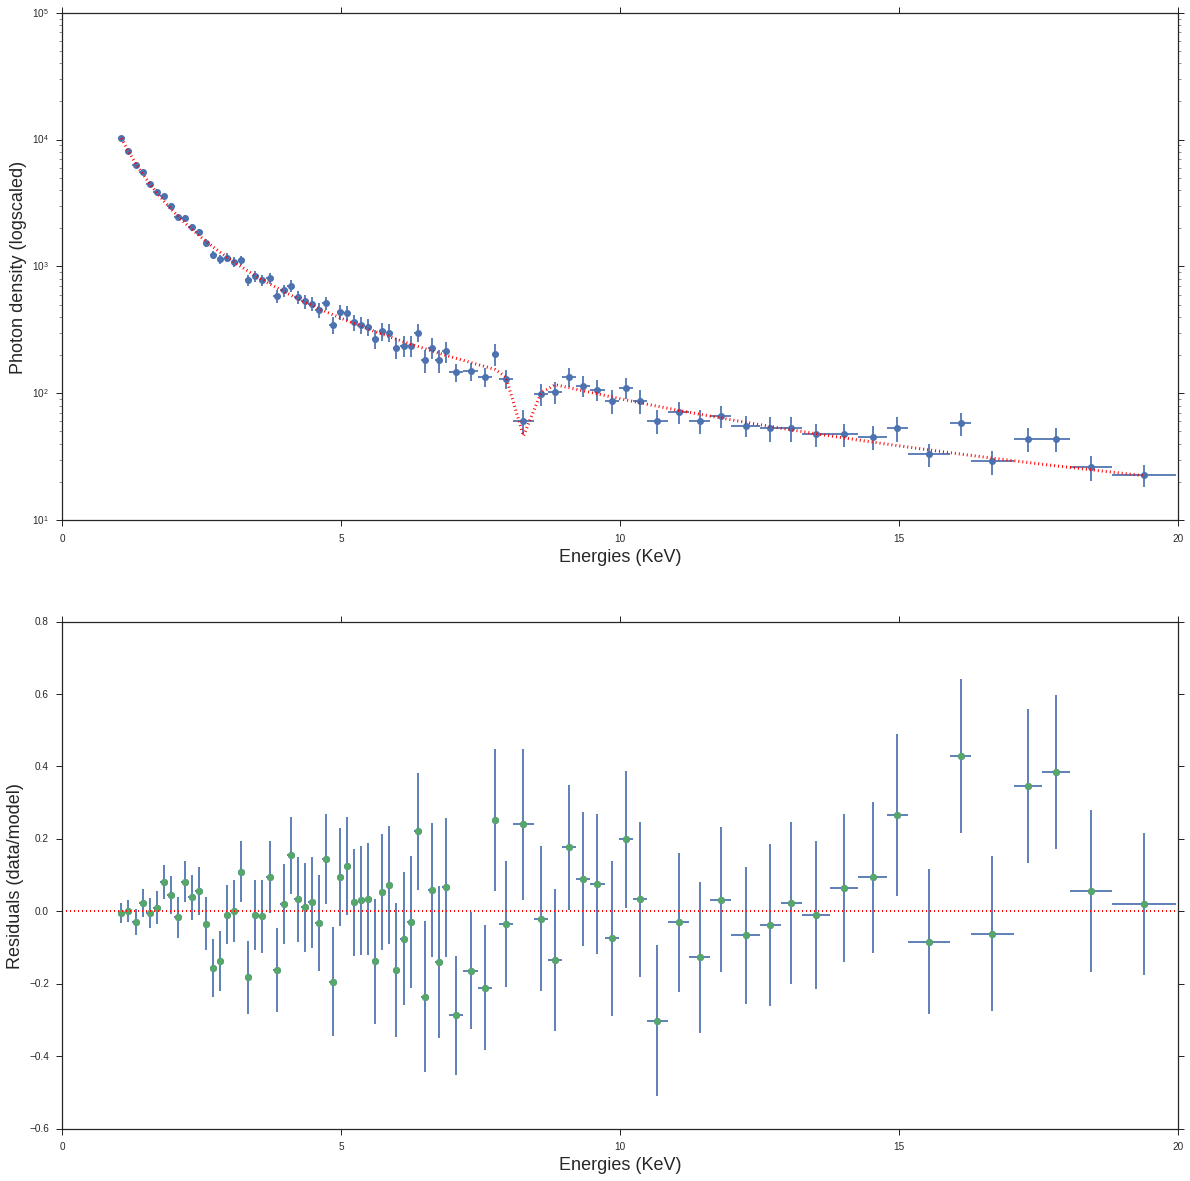

Delta chi-squared = 0.00
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is significant so we chose to keep this alteration to the blazar model
-------------------------------------------------------------------------
finally comparing our parameters with our bounds it seems that freeing up bounds would do nothing for our fit
This means that with a goodness of fit of 0.889 our model most likely is either a Blazar or a Seyfert model with an absorption line around 8.3 with an Nlc of -39.4
-------------------------------------------------------------------------


In [363]:


print "Seeing that the goodness of fit for the blazar, the seyfert galaxy and the seyfert galaxy with emission lie so close to each other"
print "I will compare the models with each other"
print"-------------------------------------------------"
print"Blazar"
print"-------------------------------------------------"
i = 1
j = 5
printSNR(i,j,False,0,False)

Stars.instances[i].my_model = Stars.instances[i].SNR
plotstuff(i,j,False)

print"-------------------------------------------------"
print"Seyfert"
print"-------------------------------------------------"
i = 1
j = 6
printSNR(i,j,False,0,False)

Stars.instances[i].my_model = Stars.instances[i].SNR
plotstuff(i,j,False)

dchisq = Stars.instances[i].inichisq[5] - Stars.instances[i].inichisq[6]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant so we choose to keep comparing with the Blazar"

print"-------------------------------------------------"
print"Seyfertem"
print"-------------------------------------------------"

i = 1
j = 7


printSNR(i,j,False,1,False)

Stars.instances[i].my_model = Stars.instances[i].SNRe1
plotstuff(i,j,False)

dchisq = Stars.instances[i].inichisq[5] - Stars.instances[i].inichisq[7]
print 'Delta chi-squared = %.2f' % dchisq
chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant so we chose the Blazar"
print"-------------------------------------------------"

print "looking closely at the plot there seems to be an absorption line around 7 KeV so using the Blazar model we try to fit an absorption line"
print"-------------------------------------------------"
i = 1
j = 5

Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minchisq = []
Stars.instances[i].mindof = []
Stars.instances[i].mingood = []
Stars.instances[i].my_model = Stars.instances[i].SNRe1
p0=[]
p0 = Blazarinitials[0][:]
p0.append(8)
p0.append(-50)
bounds=[]
bounds = Blazarinitials[1][:]
bounds.append((8.0,9.0))
bounds.append((-100,60))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 0
em = 1
printSNR(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval
sigma = 0.06 * np.sqrt(Stars.instances[i].minresult[g][2])
pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/sigma)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is significant so we chose to keep this alteration to the blazar model"
print "------------------------------------------------------------------------"
print "Looking closer around 17.5 KeV there seems to be an emision line aswell so we will try to fit that with our current model"
print "------------------------------------------------------------------------"

Stars.instances[i].my_model = Stars.instances[i].SNRe2
p0=[]
p0 = Blazarinitials[0][:]
p0.append(8)
p0.append(-50)
p0.append(17.5)
p0.append(20)
bounds=[]
bounds = Blazarinitials[1][:]
bounds.append((8.0,9.0))
bounds.append((-100,60))
bounds.append((17,18))
bounds.append((-20,200))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 1
em = 2
printSNR(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].minchisq[0] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval
sigma = 0.06 * np.sqrt(Stars.instances[i].minresult[g][2])
pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/sigma)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose to deject this alteration to the model"
print "-------------------------------------------------------------------------"
print "now the only remaining thing to do is to compare our Blazar model featuring an absorption line at  %0.3g " %(Stars.instances[i].minresult[0][2])
print "with a Seyfert model with the same absorption line:"


Stars.instances[i].my_model = Stars.instances[i].SNRe1
p0=[]
p0 = Seyfertinitials[0][:]
p0.append(8)
p0.append(-50)
bounds=[]
bounds = Seyfertinitials[1][:]
bounds.append((8.0,9.0))
bounds.append((-100,60))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 2
em = 1
printSNR(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].minchisq[0] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

sigma = 0.06 * np.sqrt(Stars.instances[i].minresult[g][2])
pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/sigma)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is significant so we chose to keep this alteration to the blazar model"



print "-------------------------------------------------------------------------"
print "finally comparing our parameters with our bounds it seems that freeing up bounds would do nothing for our fit"
print "This means that with a goodness of fit of %0.3g our model most likely is either a Blazar or a Seyfert model with an absorption \
line around %0.3g with an Nlc of %0.3g" %(Stars.instances[i].mingood[0],Stars.instances[i].minresult[0][2],Stars.instances[i].minresult[0][3])
print "-------------------------------------------------------------------------"

## Star 2 Results

It seems that with a goodness of fit of 0.889 our model most likely is either a Blazar or a Seyfert model with an absorption line around 8.3 with an Nlc of -39.4. It seems likely that the source is well described by either model.

the parameters for the Blazar model:
N0 = 11652.873 +/-  123.730
gamma = 2.110 +/-  0.007
E_line1 = 8.302 +/-  0.059
Nlc1 = -39.410 +/-  4.539
Minimum Chi-squared = 60.434 for 75 d.o.f.
The goodness of fit is: 0.889

the parameters for the Seyfert model:
N0 = 11652.908 +/-  240.402
gamma = 2.110 +/-  0.008
E_line1 = 8.302 +/-  0.035
Nlc1 = -39.410 +/-  8.301
Minimum Chi-squared = 60.434 for 75 d.o.f.
The goodness of fit is: 0.889

## Star 3 Evaluation

The only lognormal that really jumps out for star 3 is the one for the XRB model so we will evaluate that one further
-------------------------------------------------
N0 = 154.622 +/-  10.015
KbT = 0.911 +/-  0.016
Loglikelyhood = -29.141 for 28 d.o.f.


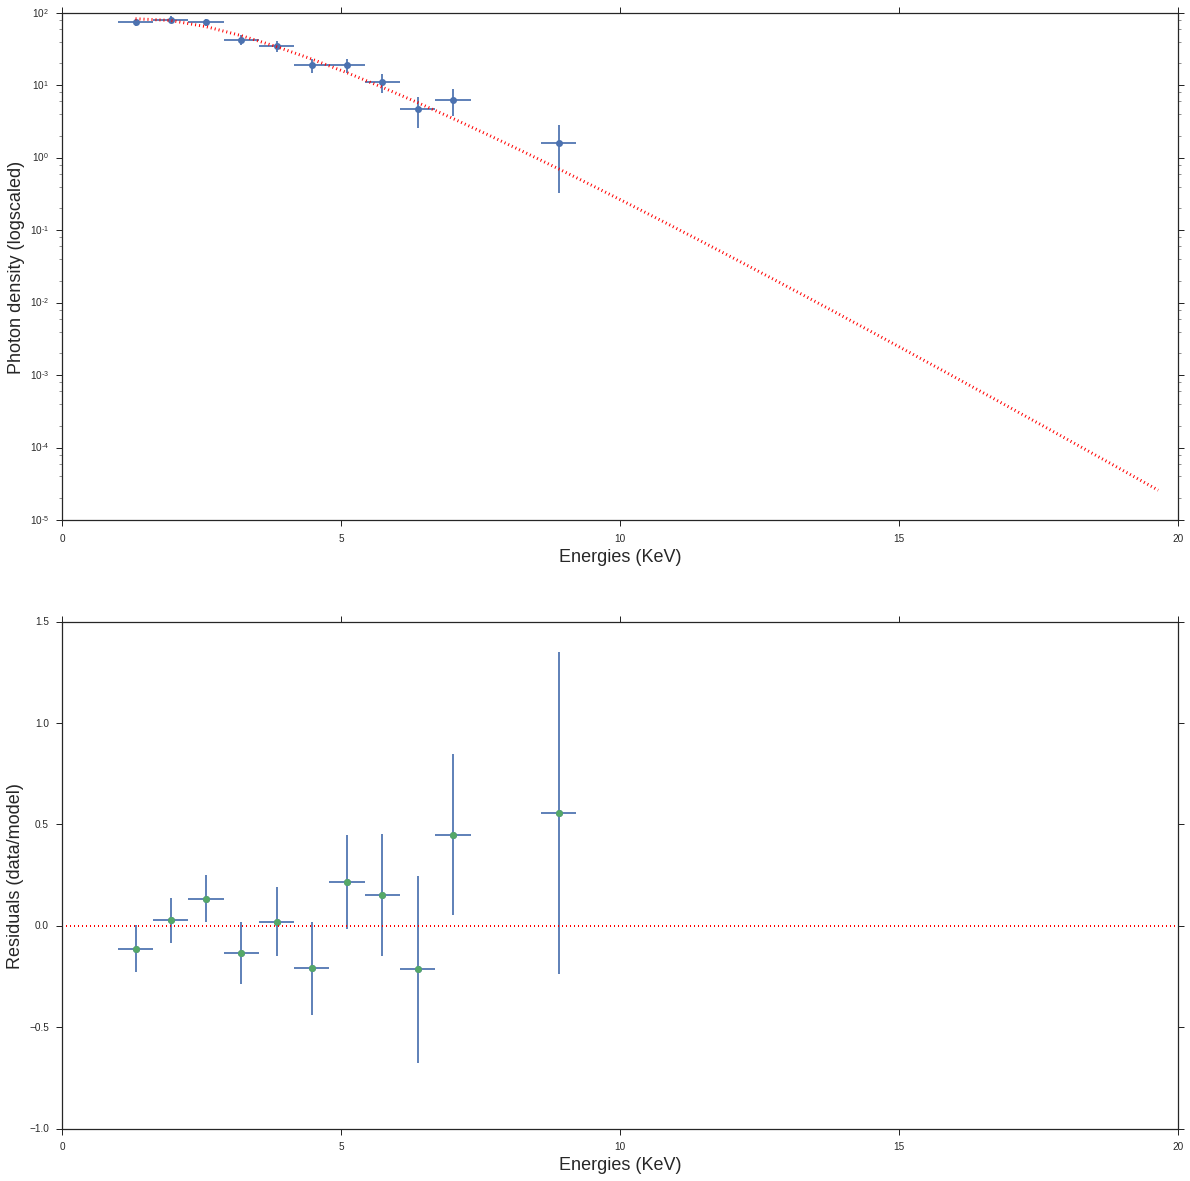

looking at the plot and the residuals there could be an emission or absorption line around 6 kev so we tried fitting one
N0 = 163.999 +/-  19.019
KbT = 0.890 +/-  0.065
E_line = 5.361 +/-  0.227
Nlc = 4.779 +/-  5.191
Loglikelyhood = -28.605 for 26 d.o.f.


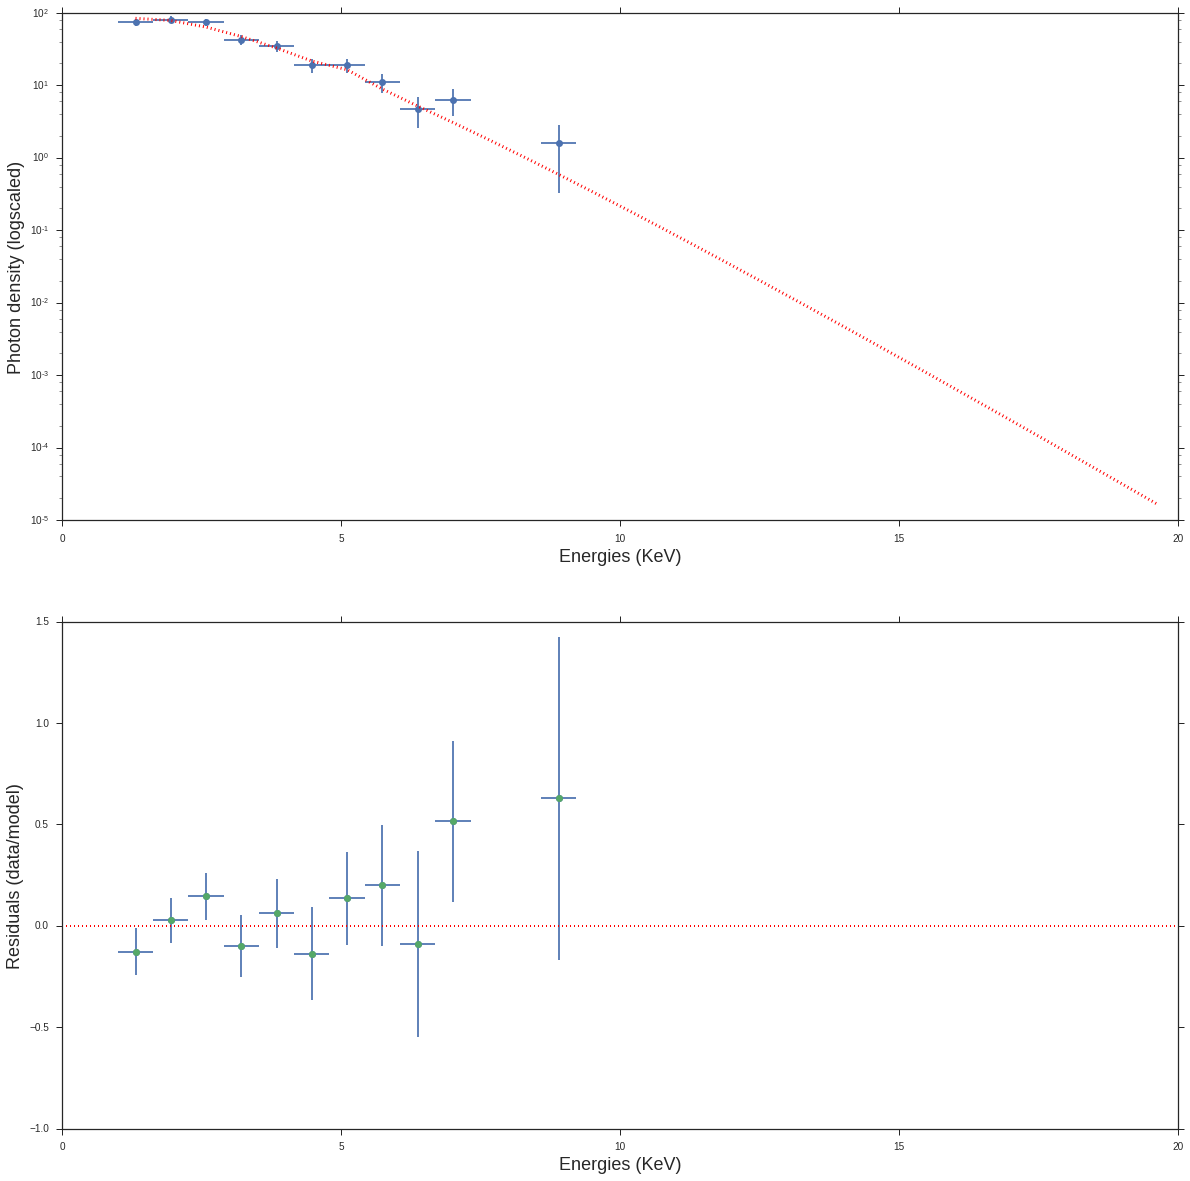

Delta log-likelyhood = 1.07
p-value for our delta-log-likelyhood: 0.3
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose to not alter our model
----------------------------------------------------------
This means that our unaltered XRB model out of our standard models seems to be the best fit. and with a log-likelyhood of -29.1


In [364]:
print "The only lognormal that really jumps out for star 3 is the one for the XRB model so we will evaluate that one further"
print"-------------------------------------------------"

i = 2
j = 2
printXRB(i,j,False,0,True)

Stars.instances[i].my_model = Stars.instances[i].XRB
plotstuff(i,j,False)

print "looking at the plot and the residuals there could be an emission or absorption line around 6 kev so we tried fitting one"
Stars.instances[i].my_model = Stars.instances[i].XRBem
Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minlog = []
Stars.instances[i].mindof = []
p0=[]
p0 = XRBinitials[0][:]
p0.append(6)
p0.append(20)
bounds=[]
bounds = XRBinitials[1][:]
bounds.append((5.0,8.0))
bounds.append((-100,100))

g=0

result = op.minimize(Stars.instances[i].LogLikelihood_Pois_Integ, p0, args=(Stars.instances[i].edges, Stars.instances[i].counts), method='L-BFGS-B', bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminlog(-1.0*result.fun)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmindof(dof)

printXRB(i,g,True,1,True)
plotstuff(i,g,True)

dchisq = 2*(Stars.instances[i].minlog[g] - Stars.instances[i].inilog[j])
print 'Delta log-likelyhood = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-log-likelyhood: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose to not alter our model"
print "----------------------------------------------------------"
print "This means that our unaltered XRB model out of our standard models seems to be the best fit. and with a log-likelyhood of %.3g" % Stars.instances[i].inilog[j]


# Star 3 Result

We found that our unaltered XRB model out of our standard models seems to be the best fit. and with a log-likelyhood of -29.1. It seems likely that the model is a good fit for the source

the model has the following parameters:
N0 = 154.622 +/-  10.015
KbT = 0.911 +/-  0.016
Loglikelyhood = -29.141 for 28 d.o.f.

## Star 4 Evaluation

Seeing that the goodness of fit for the blazar, the seyfert galaxy, the seyfert galaxy with emission and the ULX lie so close to each other
I will compare the models with each other
-------------------------------------------------
Blazar
-------------------------------------------------
N0 = 1103.708 +/-  26.413
gamma = 2.077 +/-  0.040
Minimum Chi-squared = 19.250 for 21 d.o.f.
The goodness of fit is: 0.569


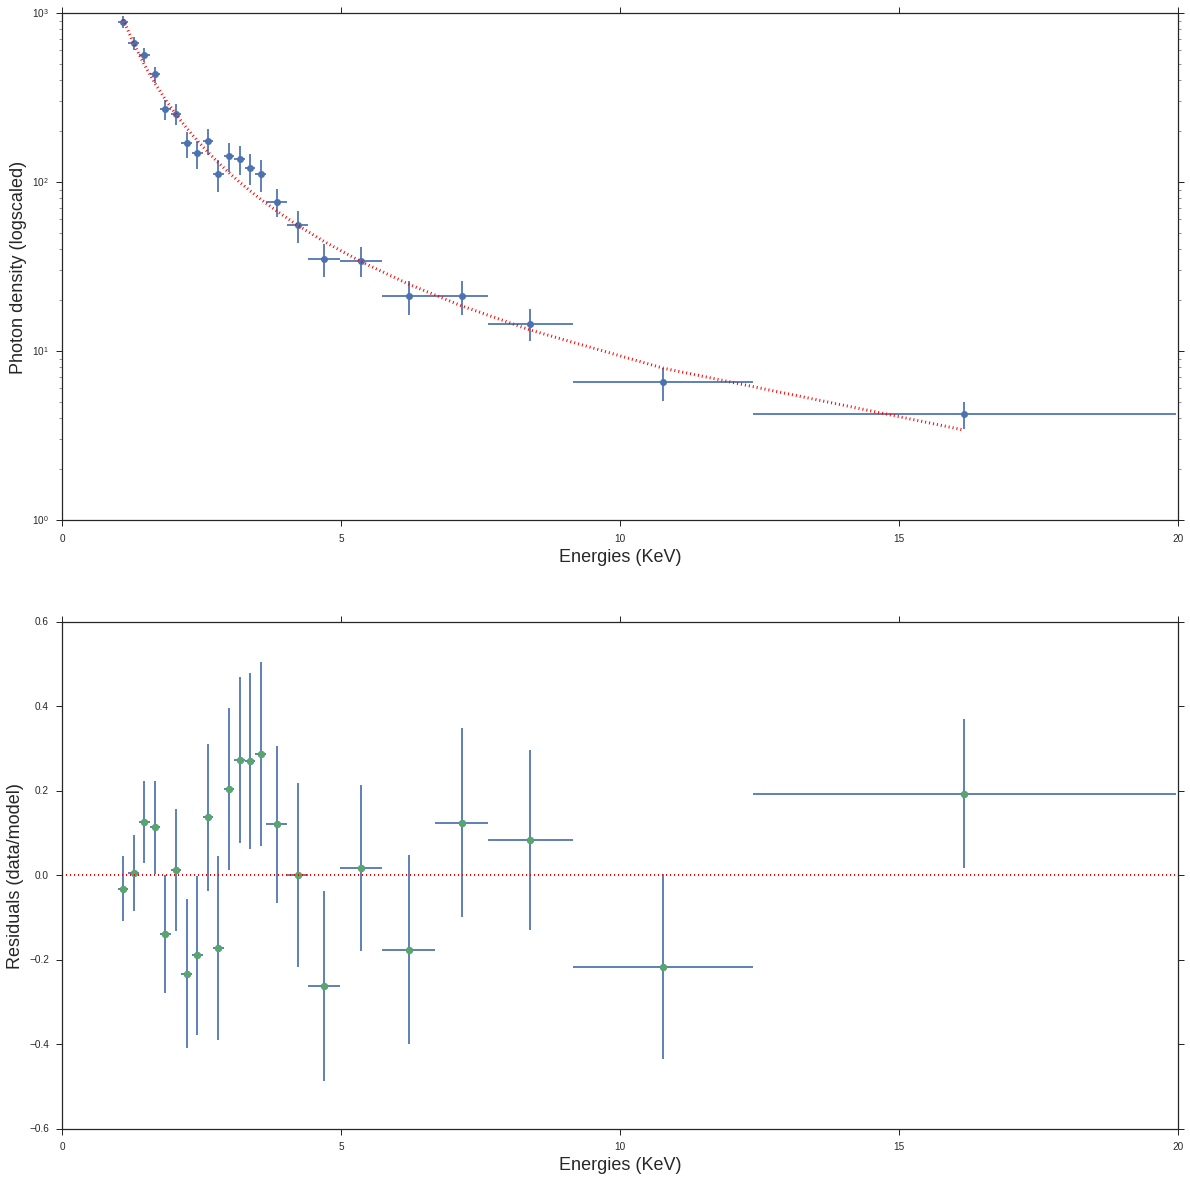

-------------------------------------------------
Seyfert
-------------------------------------------------
N0 = 1103.710 +/-  24.946
gamma = 2.077 +/-  0.026
Minimum Chi-squared = 19.250 for 21 d.o.f.
The goodness of fit is: 0.569


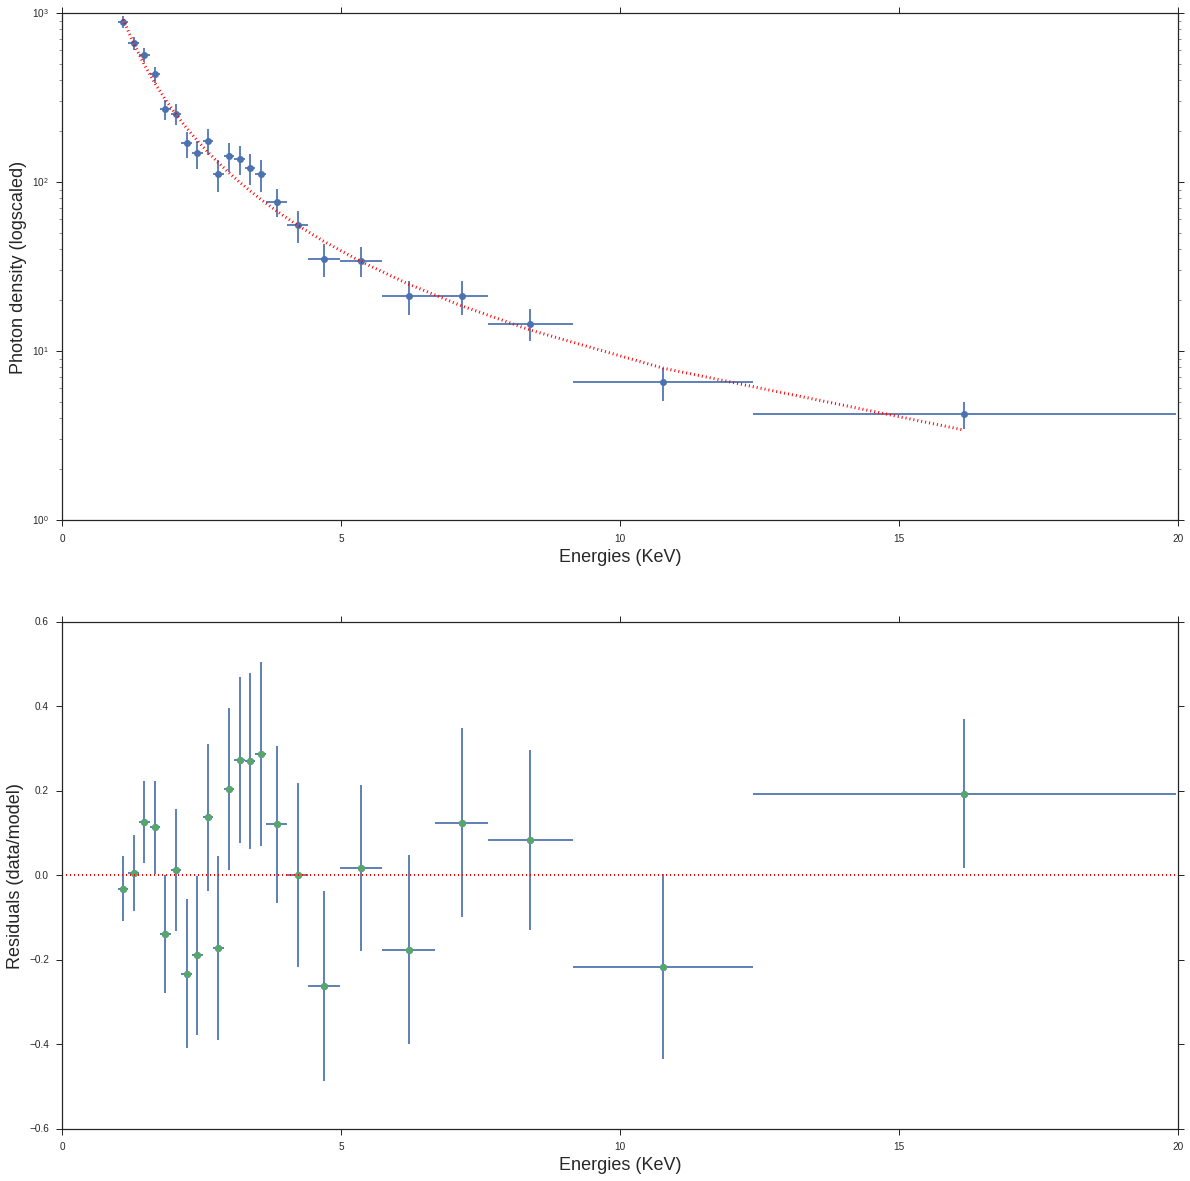

Delta chi-squared = 0.00
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant we chose to keep comparing with the Blazar
-------------------------------------------------
Seyfertem
-------------------------------------------------
N0 = 1103.709 +/-  23.338
gamma = 2.077 +/-  0.020
E_line1 = 6.600 +/-  1.000
Nlc1 = 0.000 +/-  0.996
Minimum Chi-squared = 19.250 for 19 d.o.f.
The goodness of fit is: 0.441


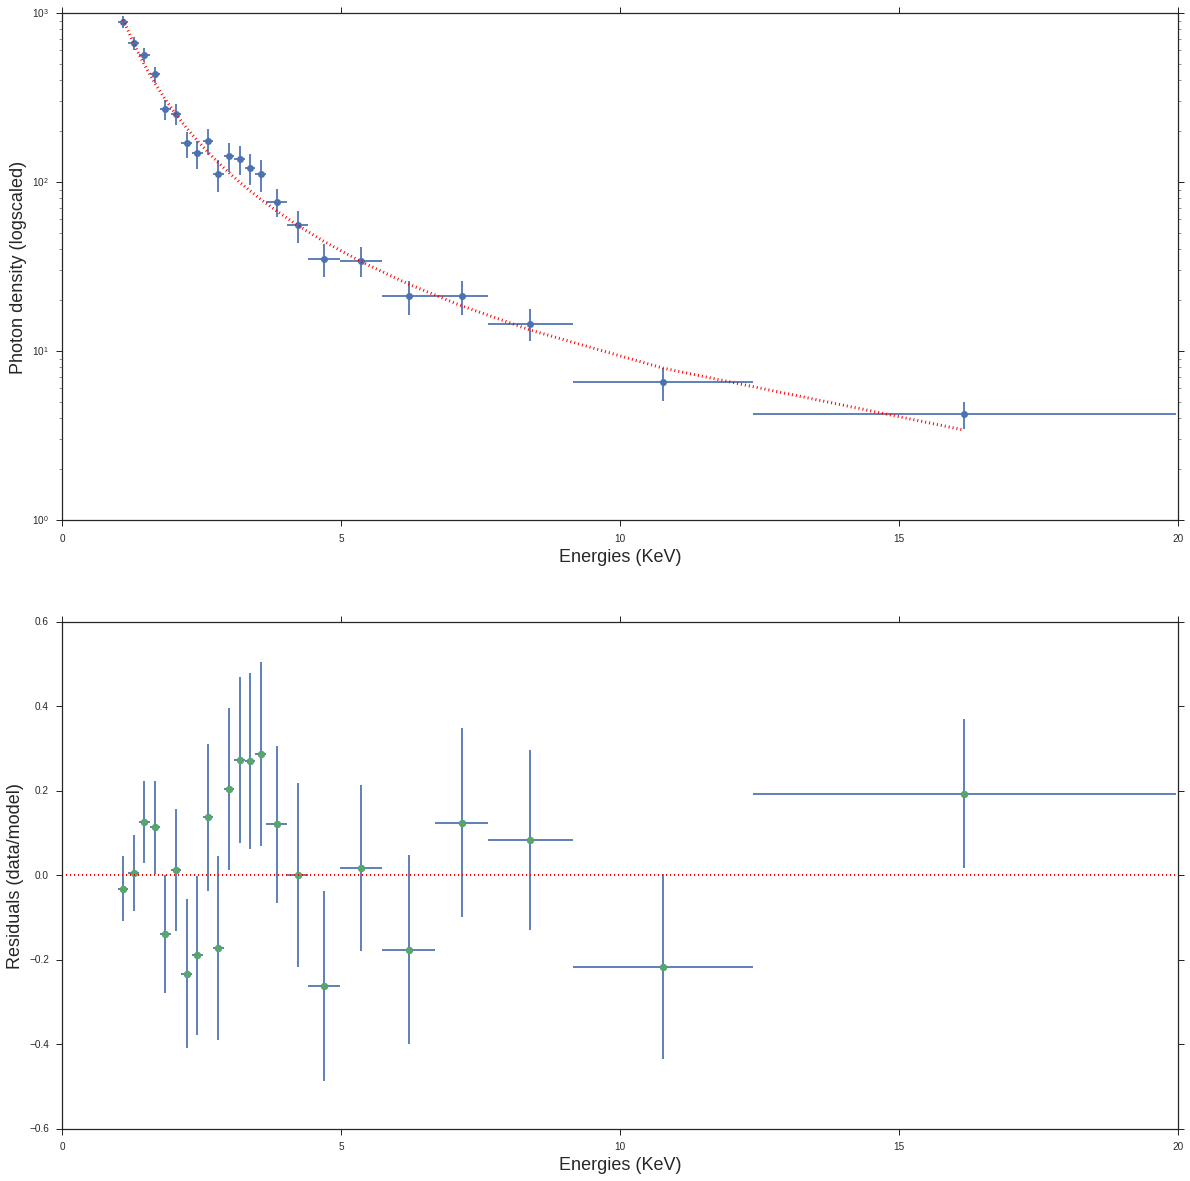

Delta chi-squared = 0.00
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant so we chose the Blazar
-------------------------------------------------
ULX
-------------------------------------------------
N0 = 1045.960 +/-  23.896
gamma1 = 2.000 +/-  0.031
gamma2 = 2.600 +/-  0.256
E_break = 8.511 +/-  1.495
Minimum Chi-squared = 22.765 for 19 d.o.f.
The goodness of fit is: 0.248


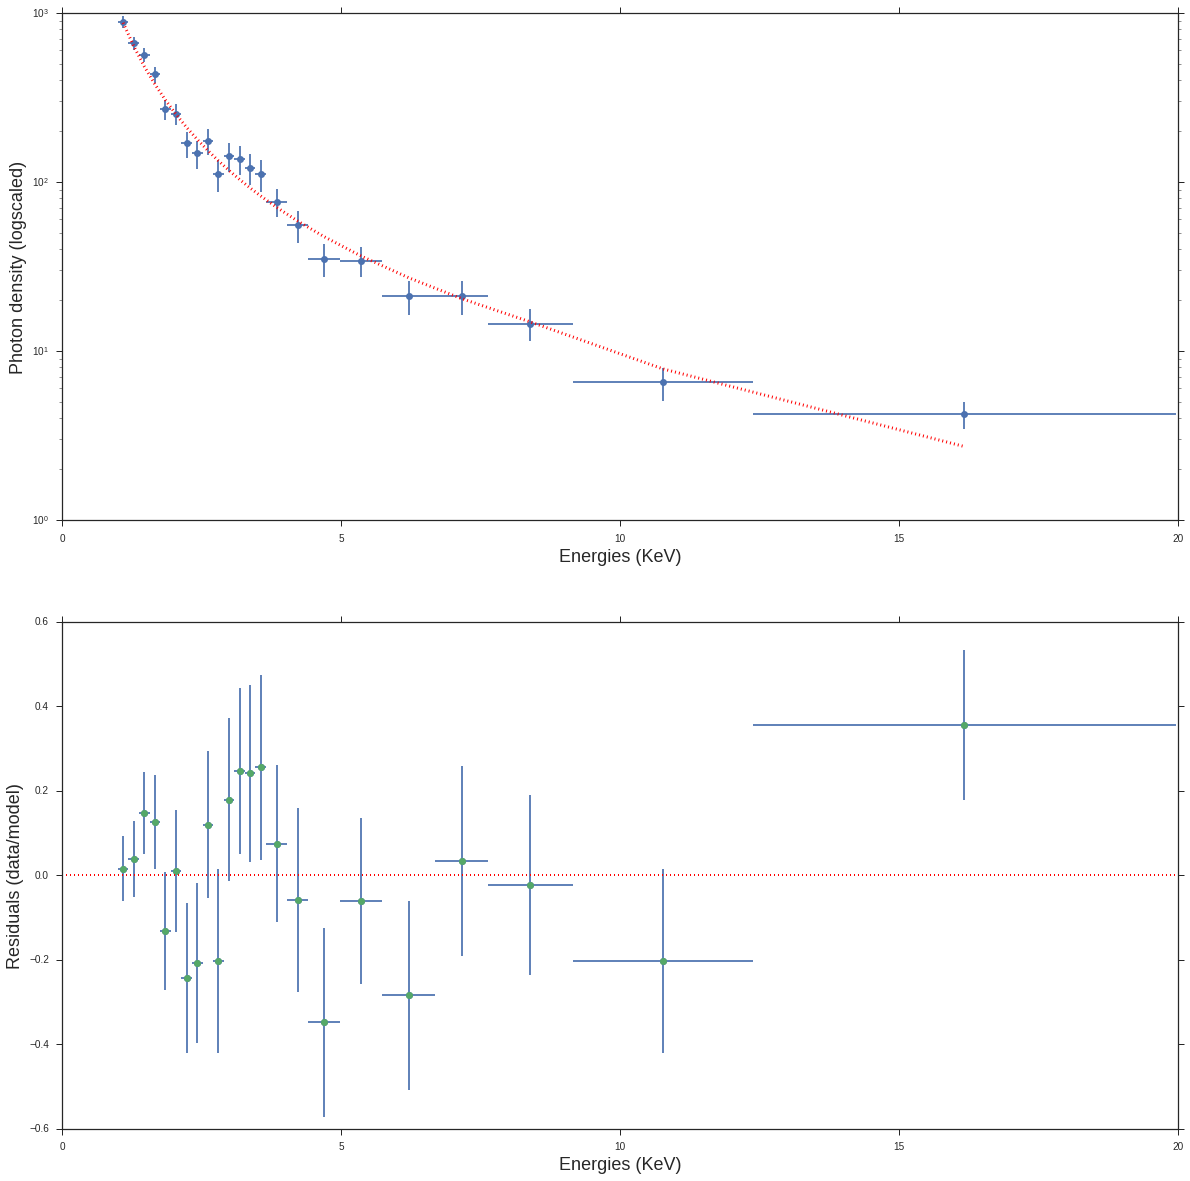

Delta chi-squared = -3.51
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant so we chose the Blazar
-------------------------------------------------
We now tried to fit an emission line around 3 KeV
N0 = 1099.114 +/-  26.237
gamma = 2.087 +/-  0.022
E_line1 = 3.269 +/-  0.087
Nlc1 = 16.097 +/-  8.671
Minimum Chi-squared = 14.933 for 19 d.o.f.
The goodness of fit is: 0.727


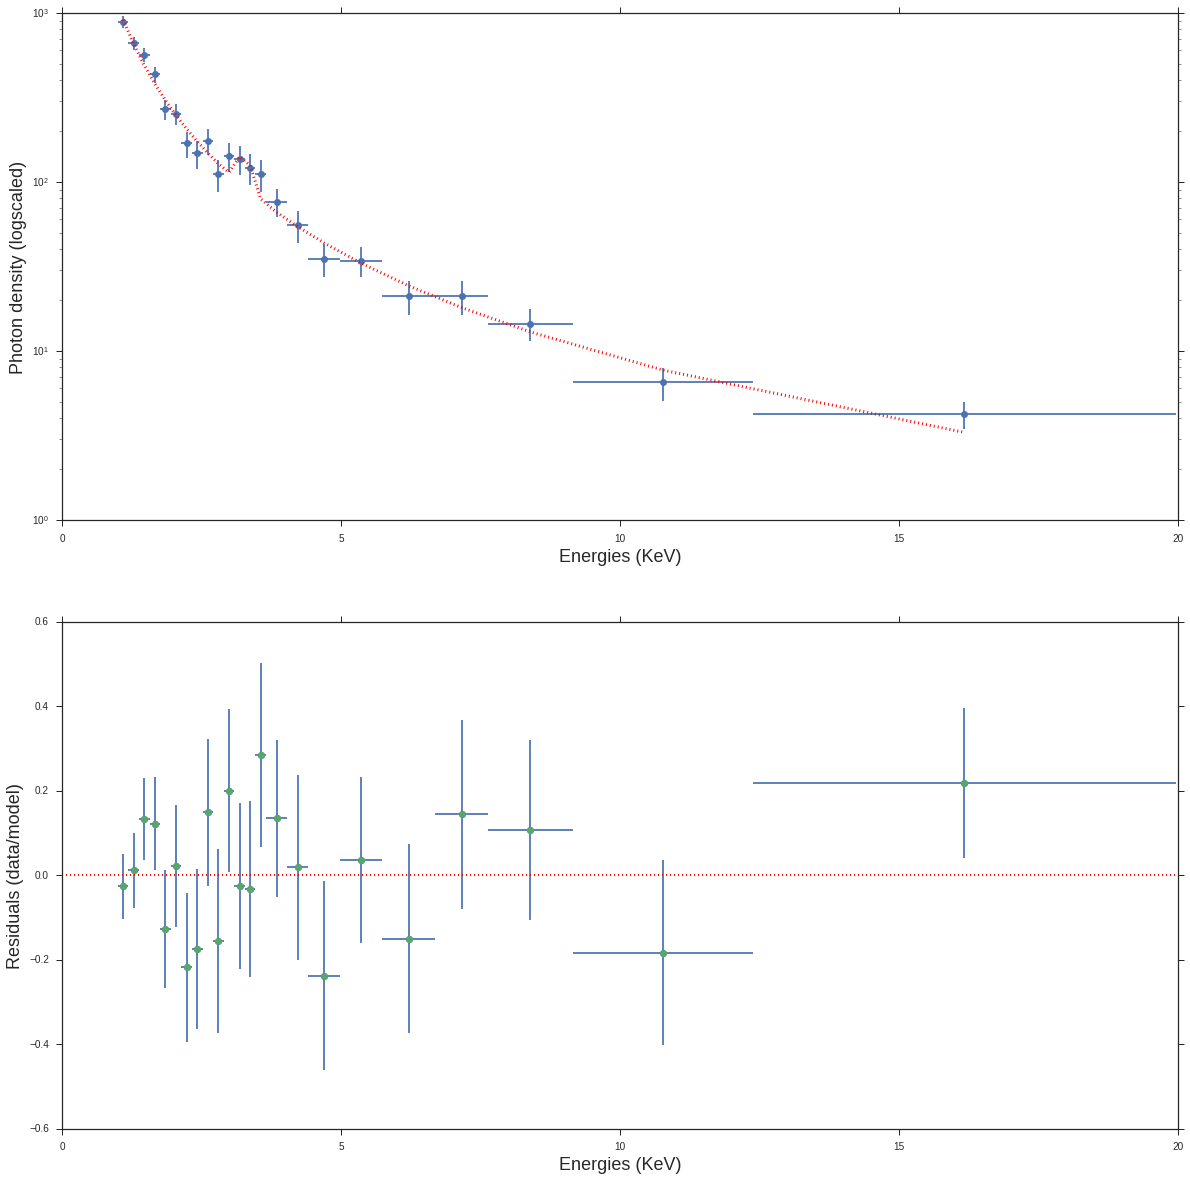

Delta chi-squared = 4.32
p-value for our delta-chi-squared: 0.0377
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose not to alter our blazar model
----------------------------------------------------------------
finally comparing our parameters with our bounds it seems that freeing up bounds would do nothing for our fit
This means that with a goodness of fit of 0.569 our model likely is either a Blazar or a Seyfert model with no absorption or emission line
-------------------------------------------------------------------------


In [365]:

print "Seeing that the goodness of fit for the blazar, the seyfert galaxy, the seyfert galaxy with emission and the ULX lie so close to each other"
print "I will compare the models with each other"
print"-------------------------------------------------"
print"Blazar"
print"-------------------------------------------------"
i = 3
j = 5
printSNR(i,j,False,0,False)

Stars.instances[i].my_model = Stars.instances[i].SNR
plotstuff(i,j,False)

print"-------------------------------------------------"
print"Seyfert"
print"-------------------------------------------------"
i = 3
j = 6
printSNR(i,j,False,0,False)

Stars.instances[i].my_model = Stars.instances[i].SNR
plotstuff(i,j,False)

dchisq = Stars.instances[i].inichisq[5] - Stars.instances[i].inichisq[6]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant we chose to keep comparing with the Blazar"

print"-------------------------------------------------"
print"Seyfertem"
print"-------------------------------------------------"

i = 3
j = 7


printSNR(i,j,False,1,False)

Stars.instances[i].my_model = Stars.instances[i].SNRe1
plotstuff(i,j,False)

dchisq = Stars.instances[i].inichisq[5] - Stars.instances[i].inichisq[7]
print 'Delta chi-squared = %.2f' % dchisq
chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant so we chose the Blazar"

print"-------------------------------------------------"
print"ULX"
print"-------------------------------------------------"

i = 3
j = 1

printULX(i,j,False,1,False)

Stars.instances[i].my_model = Stars.instances[i].ULX
plotstuff(i,j,False)

dchisq = Stars.instances[i].inichisq[5] - Stars.instances[i].inichisq[1]
print 'Delta chi-squared = %.2f' % dchisq
chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant so we chose the Blazar"
print"-------------------------------------------------"

print "We now tried to fit an emission line around 3 KeV"
i = 3
j = 5

Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minchisq = []
Stars.instances[i].mindof = []
Stars.instances[i].mingood = []
Stars.instances[i].my_model = Stars.instances[i].SNRe1
p0=[]
p0 = Blazarinitials[0][:]
p0.append(3)
p0.append(50)
bounds=[]
bounds = Blazarinitials[1][:]
bounds.append((2.5,3.5))
bounds.append((-100,100))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 0
em = 1
printSNR(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06 * np.sqrt(Stars.instances[i].minresult[g][2])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose not to alter our blazar model"
print "----------------------------------------------------------------"
print "finally comparing our parameters with our bounds it seems that freeing up bounds would do nothing for our fit"
print "This means that with a goodness of fit of %0.3g our model likely is either a Blazar or a Seyfert model with no absorption or emission line" %(Stars.instances[i].inigoodness[j])
print "-------------------------------------------------------------------------"

# Star 4 Results

We found that either a Blazar or a Seyfert model with no absorption or emission line, best describes this source with a goodness of fit of 0.569.

with Blazar parameters:
N0 = 1103.708 +/-  26.413
gamma = 2.077 +/-  0.040
Minimum Chi-squared = 19.250 for 21 d.o.f.
The goodness of fit is: 0.569

with Seyfert parameters:
N0 = 1103.710 +/-  24.946
gamma = 2.077 +/-  0.026
Minimum Chi-squared = 19.250 for 21 d.o.f.
The goodness of fit is: 0.569

## Star 5 Evaluation

The only lognormal that really jumps out for star 3 is the one for the XRB model so we will evaluate that one further
-------------------------------------------------
N0 = 37.272 +/-  4.231
KbT = 1.381 +/-  0.031
Loglikelyhood = -44.191 for 28 d.o.f.


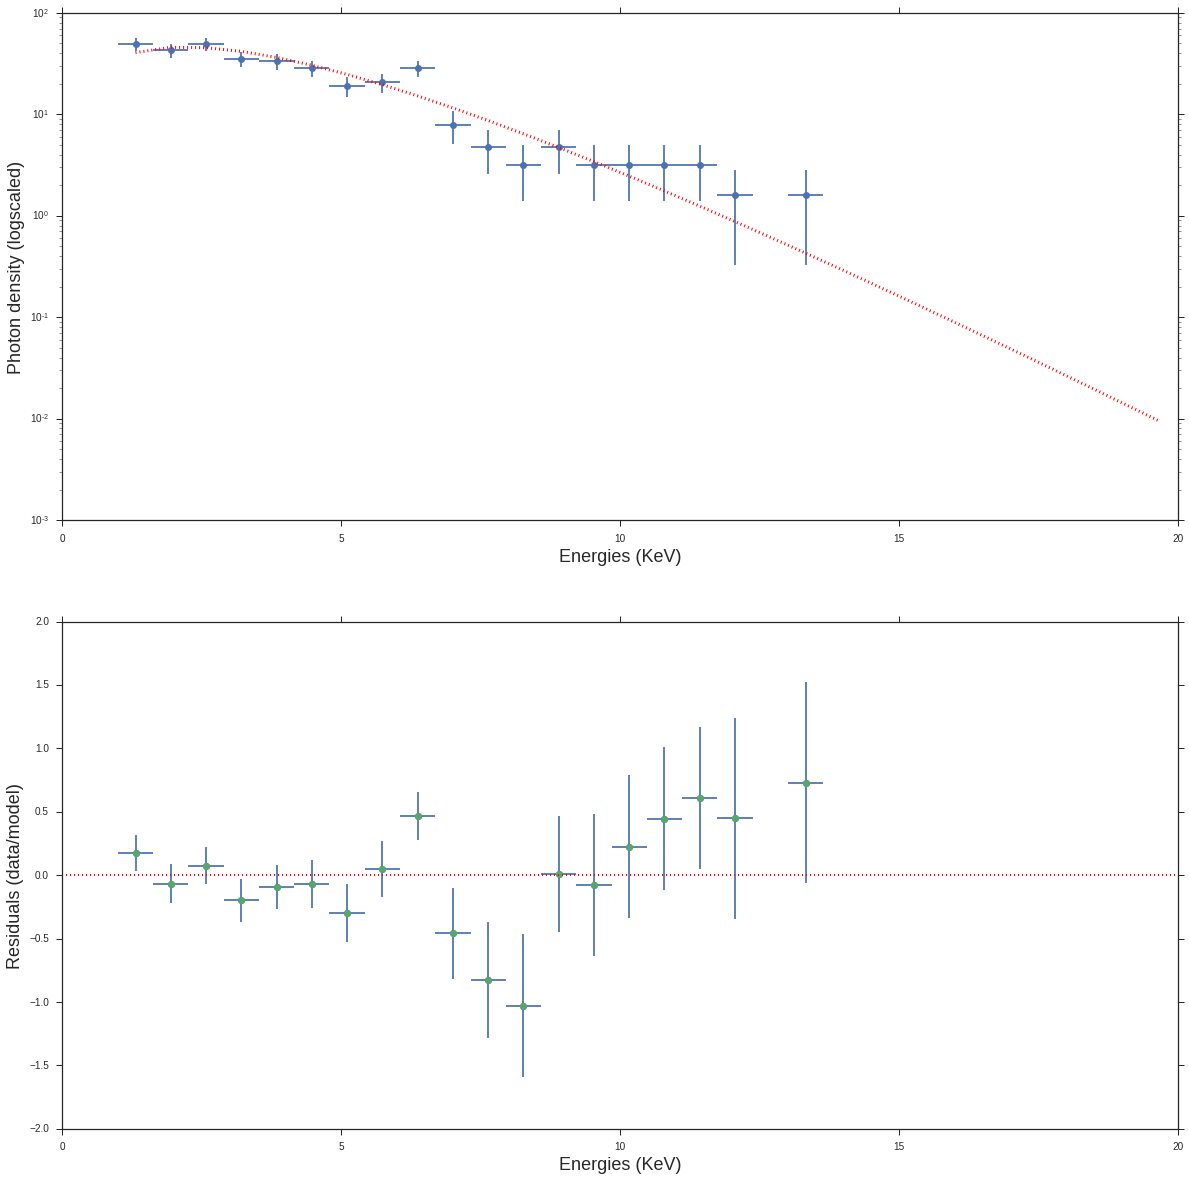

looking at the plot and the residuals there could be an absorption line around 5 KeV so we tried to fit that 
N0 = 39.425 +/-  2.814
KbT = 1.335 +/-  0.028
E_line = 6.208 +/-  0.162
Nlc = 11.088 +/-  4.985
Loglikelyhood = -40.802 for 26 d.o.f.


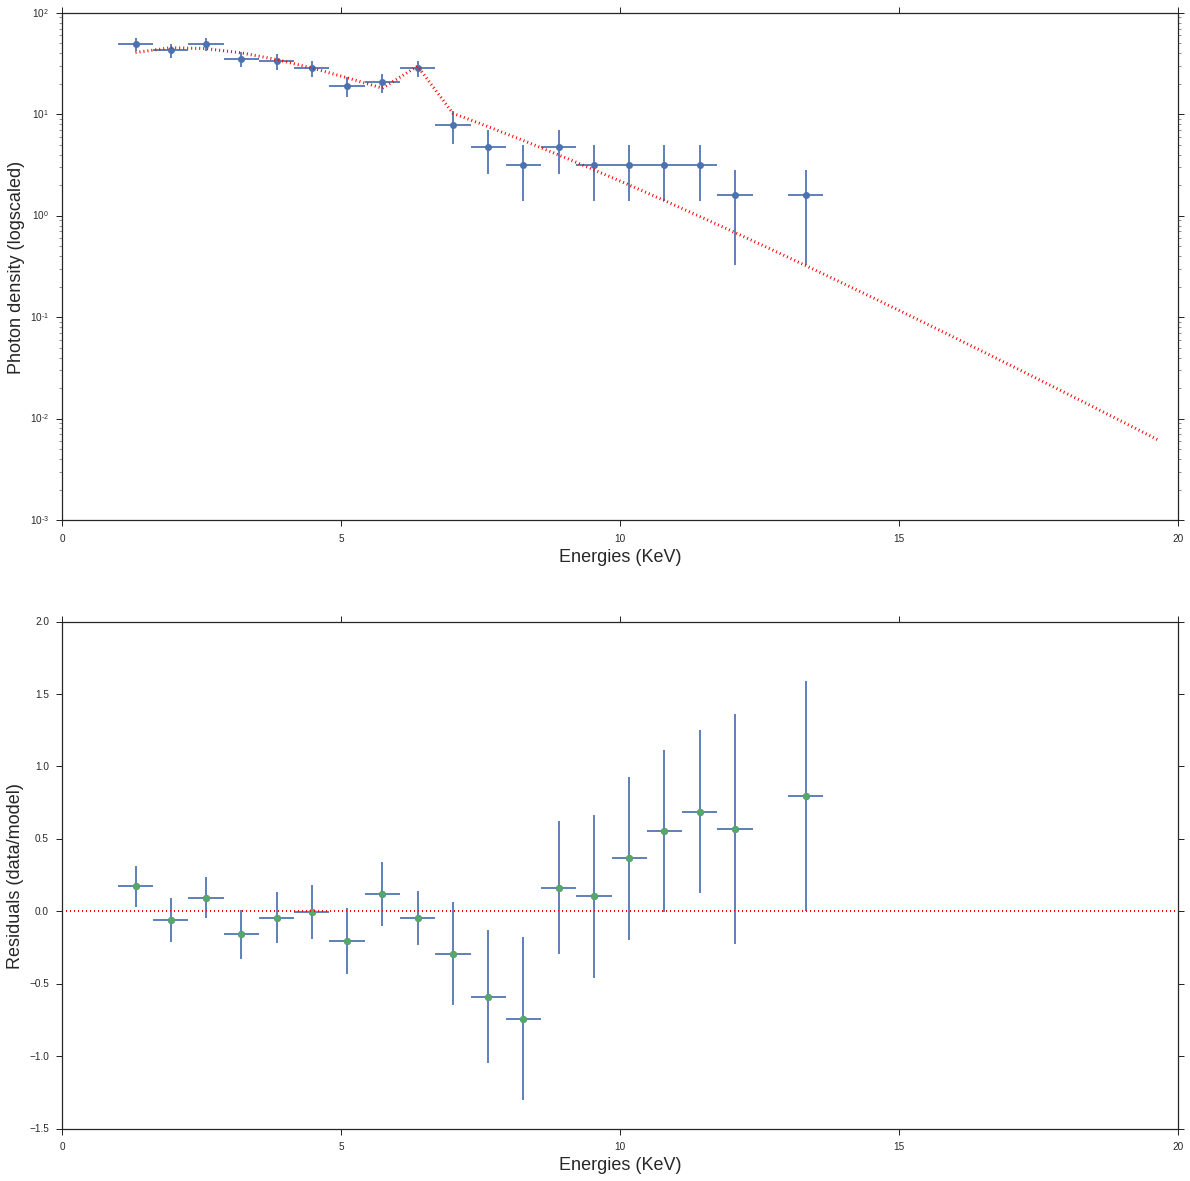

Delta log-likelyhood = 6.78
p-value for our delta-log-likelyhood: 0.00923
p-value corrected for number of trials: 0.845, which corresponds to a 0-sigma confidence level
which is insignificant so we chose to not alter our model
----------------------------------------------------------
This means that our unaltered XRB model out of our standard models seems to be the best fit. With a log-likelyhood of -44.2


In [366]:
print "The only lognormal that really jumps out for star 3 is the one for the XRB model so we will evaluate that one further"
print"-------------------------------------------------"

i = 4
j = 2
printXRB(i,j,False,0,True)
Stars.instances[i].my_model = Stars.instances[i].XRB
plotstuff(i,j,False)


print "looking at the plot and the residuals there could be an absorption line around 5 KeV so we tried to fit that "

Stars.instances[i].my_model = Stars.instances[i].XRBem
Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minlog = []
Stars.instances[i].mindof = []
p0=[]
p0 = XRBinitials[0][:]
p0.append(6)
p0.append(-20)
bounds=[]
bounds = XRBinitials[1][:]
bounds.append((5.5,6.5))
bounds.append((-100,100))

g=0

result = op.minimize(Stars.instances[i].LogLikelihood_Pois_Integ, p0, args=(Stars.instances[i].edges, Stars.instances[i].counts), method='L-BFGS-B', bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminlog(-1.0*result.fun)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmindof(dof)

printXRB(i,g,True,1,True)
plotstuff(i,g,True)

dchisq = 2*(Stars.instances[i].minlog[g] - Stars.instances[i].inilog[j])
print 'Delta log-likelyhood = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-log-likelyhood: %.3g" % pval
if pval == pval:
    pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06 * np.sqrt(Stars.instances[i].minresult[g][2])))
    sigmalevel = np.floor(p_to_sigmas(pvalcorr))
    print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
else:
    print "p-value corrected for number of trials: "+str(pvalcorr)+", which corresponds to a "+str(sigmalevel)+"-sigma confidence level"
print "which is insignificant so we chose to not alter our model"
print "----------------------------------------------------------"
print "This means that our unaltered XRB model out of our standard models seems to be the best fit. With a log-likelyhood of %.3g" % Stars.instances[i].inilog[j]


# Star 5 Results

We found that our unaltered XRB model out of our standard models seems to be the best fit. With a log-likelyhood of -44.2 however,it seems not terribly likely that an unaltered XRB model best describes our data.

Parameters:
N0 = 37.272 +/-  4.231
KbT = 1.381 +/-  0.031
Loglikelyhood = -44.191 for 28 d.o.f.

## Star 6 Evaluation

Selecting the best goodness of fit amongst our initial supplied models we get the ULXe model best describing Star6 datawith:
N0 = 1295.145 +/-  31.379
gamma = 1.688 +/-  0.025
E_cut = 6.108 +/-  0.259
Minimum Chi-squared = 21.168 for 17 d.o.f.
The goodness of fit is: 0.219


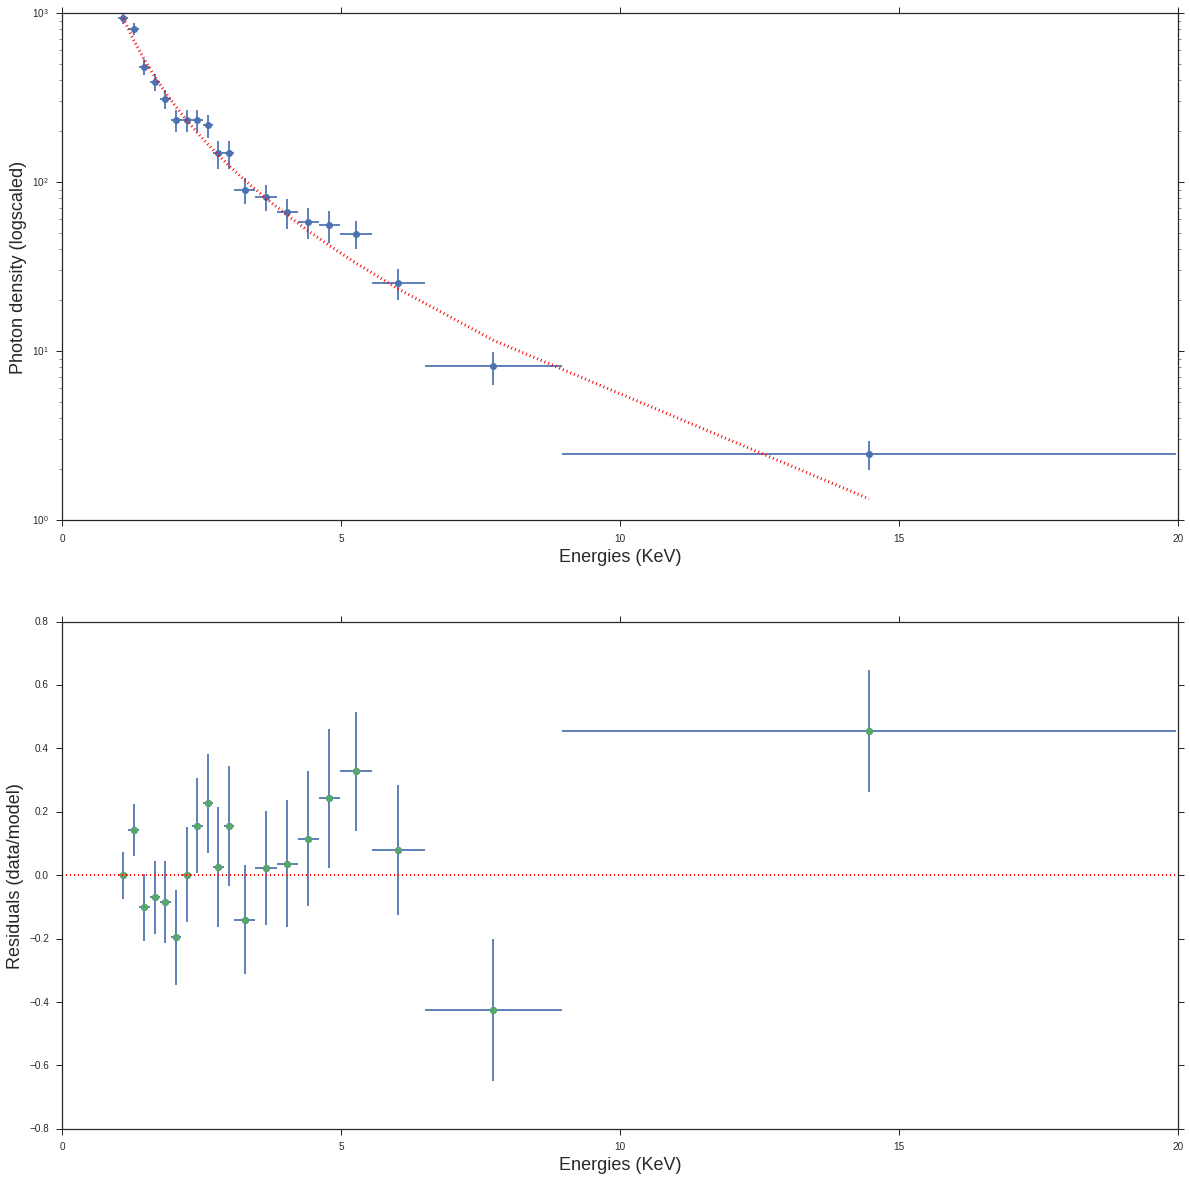

Looking at the plots and the residuals tthere could be an emission line around 5 KeV
So we will try to fit an guassian to that spot to see if an emission line improves the fit
-----------------------------------------------------
N0 = 1306.323 +/-  33.417
gamma = 1.729 +/-  0.027
E_cut = 6.292 +/-  0.291
E_line = 5.434 +/-  0.145
Nlc = 12.226 +/-  4.617
Minimum Chi-squared = 17.827 for 15 d.o.f.
The goodness of fit is: 0.272


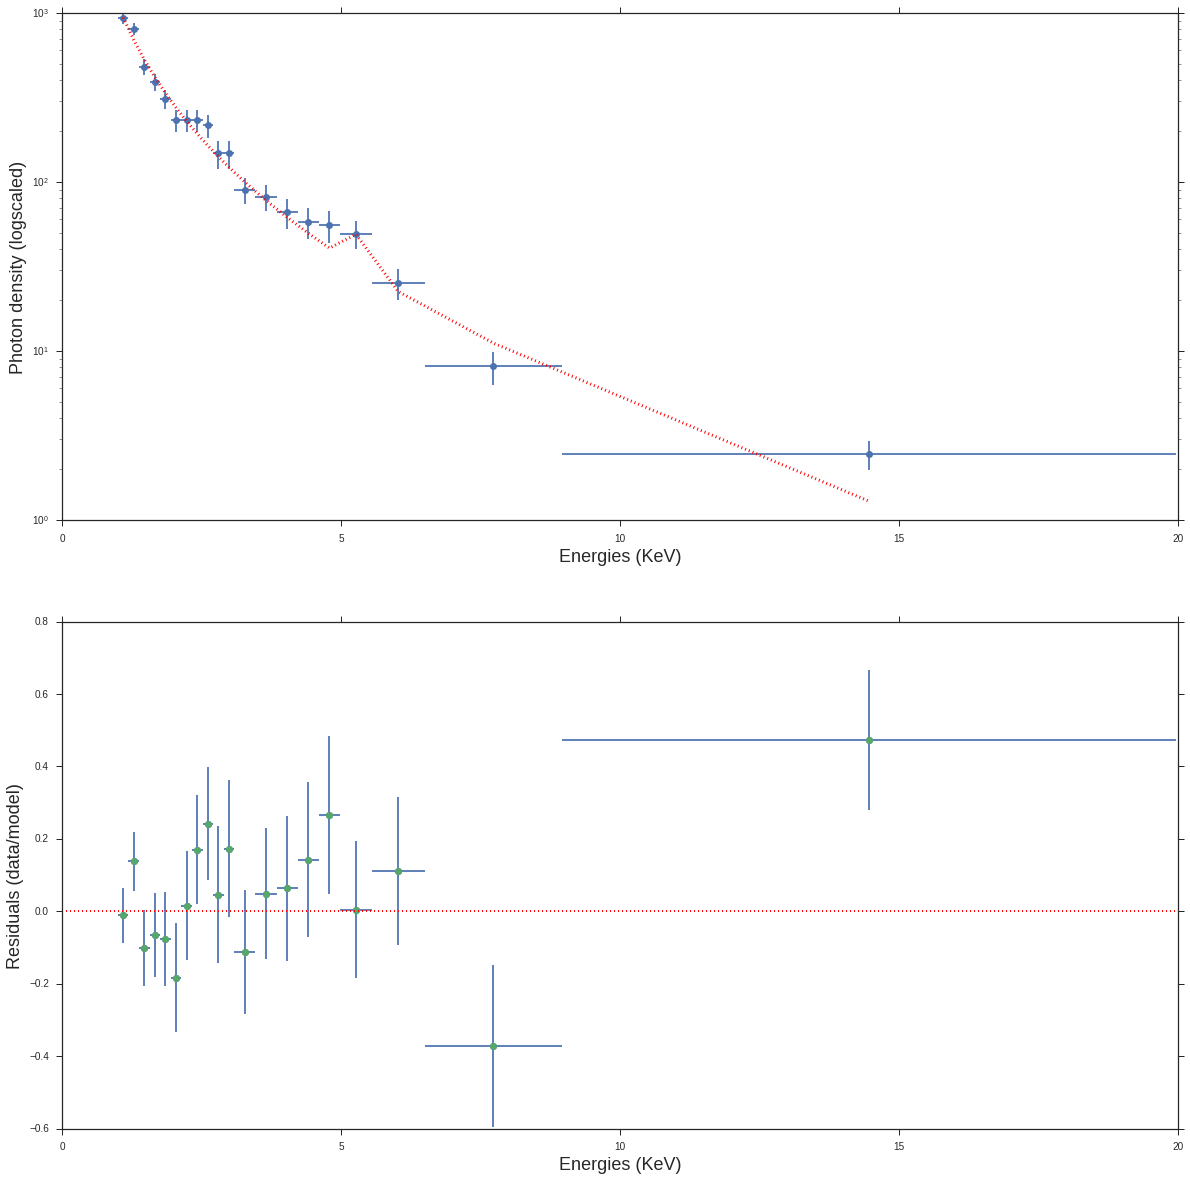

Delta chi-squared = 3.34
p-value for our delta-chi-squared: 0.0676
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose not to alter our model
---------------------------------------------------------
there could also be an emission line around 2.5 so we try to fit that with the data aswell 
N0 = 1279.142 +/-  33.246
gamma = 1.771 +/-  0.030
E_cut = 7.065 +/-  0.457
E_line = 2.536 +/-  0.049
Nlc = 19.450 +/-  14.292
Minimum Chi-squared = 17.535 for 15 d.o.f.
The goodness of fit is: 0.288


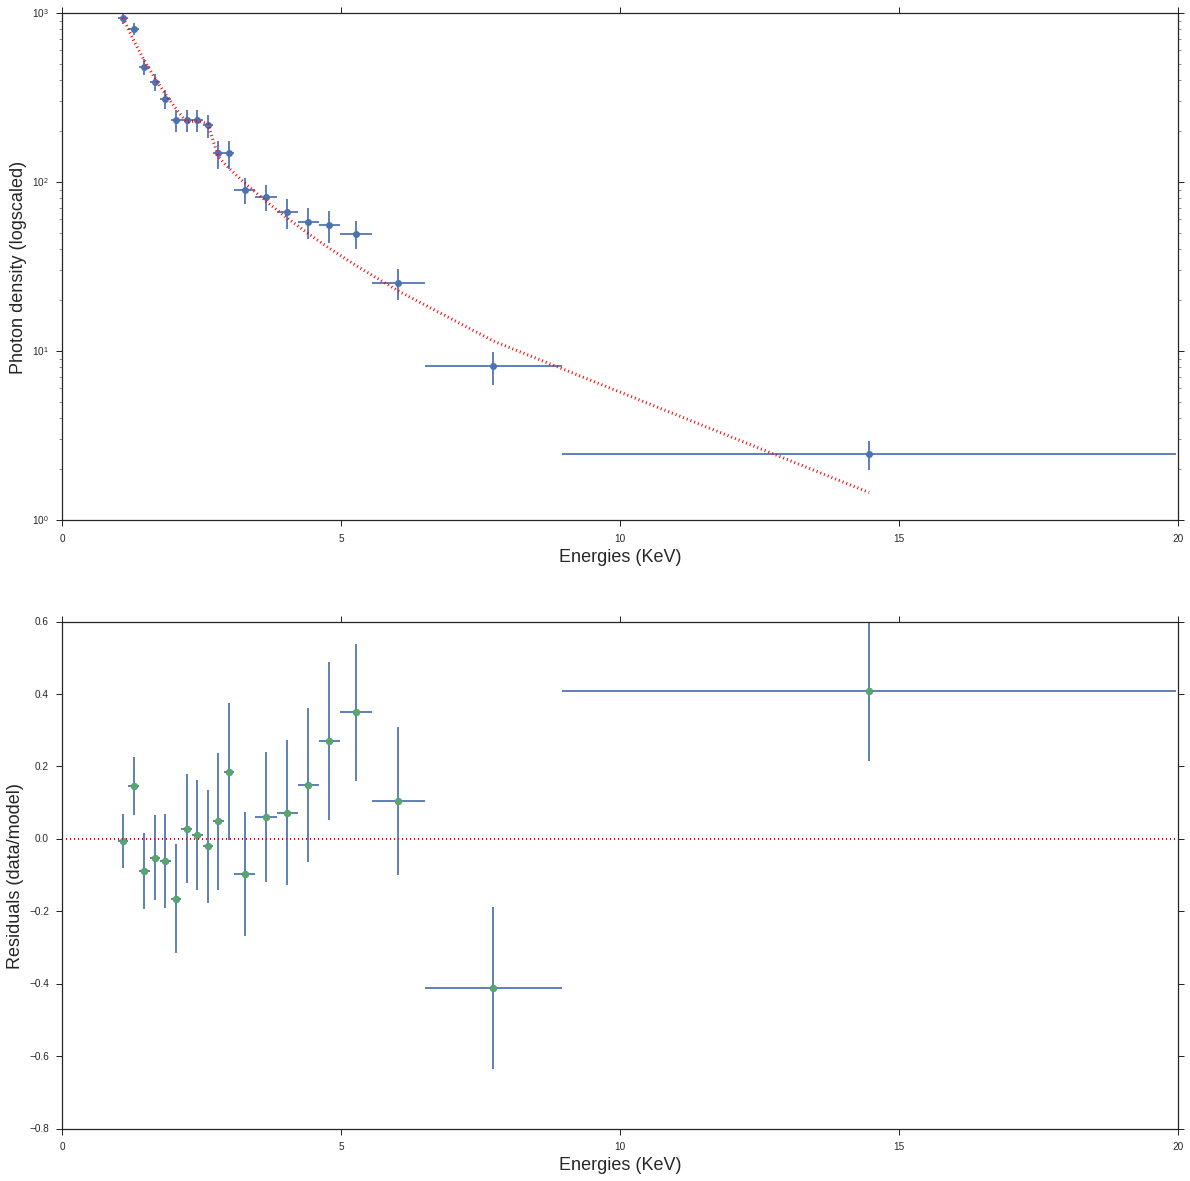

Delta chi-squared = 3.63
p-value for our delta-chi-squared: 0.0567
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose not to alter our model
This means that our source out of the models we tested most likely is an Ultra luminious Xray source with a goodness of fit of 0.219


In [367]:

i = 5
j = 0
print "Selecting the best goodness of fit amongst our initial supplied models we get the ULXe model best describing Star6 data\
with:"

printULXe(i,j,False,0,False)

Stars.instances[i].my_model = Stars.instances[i].ULXe
plotstuff(i,j,False)

print "Looking at the plots and the residuals tthere could be an emission line around 5 KeV"
print "So we will try to fit an guassian to that spot to see if an emission line improves the fit"
print "-----------------------------------------------------"

Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minchisq = []
Stars.instances[i].mindof = []
Stars.instances[i].mingood = []
Stars.instances[i].my_model = Stars.instances[i].ULXeem
p0=[]
p0 = ULXeinitials[0][:]
p0.append(4.5)
p0.append(50)
bounds=[]
bounds = ULXeinitials[1][:]
bounds.append((4,6))
bounds.append((-100,100))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 0
em = 1
printULXe(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06 * np.sqrt(Stars.instances[i].minresult[g][3])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose not to alter our model"
print "---------------------------------------------------------"
print "there could also be an emission line around 2.5 so we try to fit that with the data aswell "

Stars.instances[i].my_model = Stars.instances[i].ULXeem
p0=[]
p0 = ULXeinitials[0][:]
p0.append(2.5)
p0.append(50)
bounds=[]
bounds = ULXeinitials[1][:]
bounds.append((2.5,3.5))
bounds.append((-100,100))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 1
em = 1
printULXe(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval
pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06 * np.sqrt(Stars.instances[i].minresult[g][3])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose not to alter our model"
print "This means that our source out of the models we tested most likely is an Ultra luminious Xray source with a goodness of fit of %0.3g" %Stars.instances[i].inigoodness[j]


# Star 6 Results

We found that our source is best described by the ULXe model. However, since the goodness of fit is only 0.219 we can't exclude that it could very well still be an unknown source.

Parameters:
N0 = 1295.145 +/-  31.379
gamma = 1.688 +/-  0.025
E_cut = 6.108 +/-  0.259
Minimum Chi-squared = 21.168 for 17 d.o.f.
The goodness of fit is: 0.219

## Star 7 Evaluation

Selecting the best goodness of fit amongst our initial supplied models we get the SNRe3 model (the super nova model with 3 emission lines) best describing Star7 datawith:
N0 = 1654.717 +/-  48.557
gamma = 2.664 +/-  0.030
E_line1 = 1.855 +/-  0.016
Nlc1 = 124.823 +/-  13.624
E_line2 = 2.418 +/-  0.036
Nlc2 = 52.565 +/-  14.290
E_line3 = 6.702 +/-  0.124
Nlc3 = 18.272 +/-  4.942
Minimum Chi-squared = 8.618 for 10 d.o.f.
The goodness of fit is: 0.569


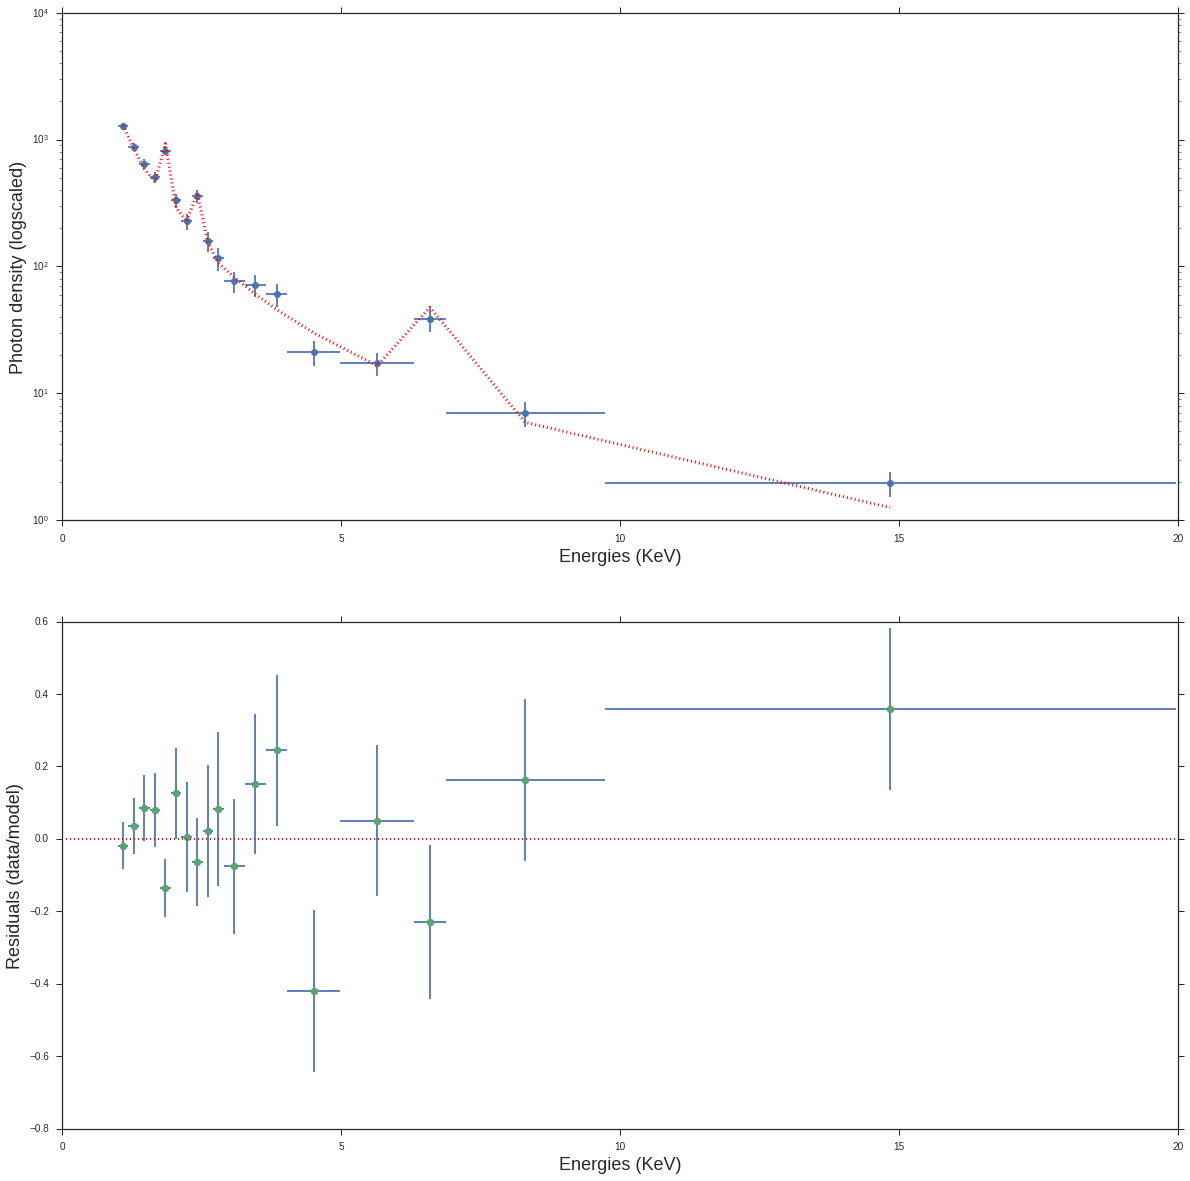

Looking at the plots and the residuals this model appears to be the best fit we can think of. there are no apparent emission or absorption linesand the model is not limited to the boundaries initially supplied. Which means that freeing up the boundaries would do nothing for our model
-----------------------------------------------------
This means that our source out of the models we tested most likely is a Super nova remnant with 3 emission lines (SI XIII, S XV and Ionized Fe) with a goodness of fit of 0.569


In [368]:
i = 6
j = 4
print "Selecting the best goodness of fit amongst our initial supplied models we get the SNRe3 model (the super nova model with 3 emission lines) best describing Star7 data\
with:"
# print "Model = %s" % model
printSNR(i,j,False,3,False)
#

Stars.instances[i].my_model = Stars.instances[i].SNRe3
plotstuff(i,j,False)

print "Looking at the plots and the residuals this model appears to be the best fit we can think of. there are no apparent emission or absorption lines\
and the model is not limited to the boundaries initially supplied. Which means that freeing up the boundaries would do nothing for our model"
print "-----------------------------------------------------"
print "This means that our source out of the models we tested most likely is a Super nova remnant with 3 emission lines (SI XIII, S XV and Ionized Fe) with a goodness of fit of %0.3g" %Stars.instances[i].inigoodness[j]





# Star 7 Results

We found that the model best describing our source was SNRe3, with a goodness of fit of 0.569 we can say that it is likely that this model has a good fit to our source.

parameters:

N0 = 1654.717 +/-  48.557
gamma = 2.664 +/-  0.030
E_line1 = 1.855 +/-  0.016
Nlc1 = 124.823 +/-  13.624
E_line2 = 2.418 +/-  0.036
Nlc2 = 52.565 +/-  14.290
E_line3 = 6.702 +/-  0.124
Nlc3 = 18.272 +/-  4.942
Minimum Chi-squared = 8.618 for 10 d.o.f.
The goodness of fit is: 0.569

## Star 8  Evaluation

With star 8 we have quite the conundrum since all the models,save the XRB model, come close to each others log-likelyhood 
In order to solve this we chose to compare all models to the model with the lowest log-likelyhood ,which is the Seyfertem model.
-------------------------------------------------
Seyfertem
-------------------------------------------------
N0 = 210.046 +/-  15.949
gamma = 1.920 +/-  0.061
E_line1 = 6.320 +/-  0.362
Nlc1 = 3.272 +/-  3.569
Loglikelyhood = -48.481 for 26 d.o.f.


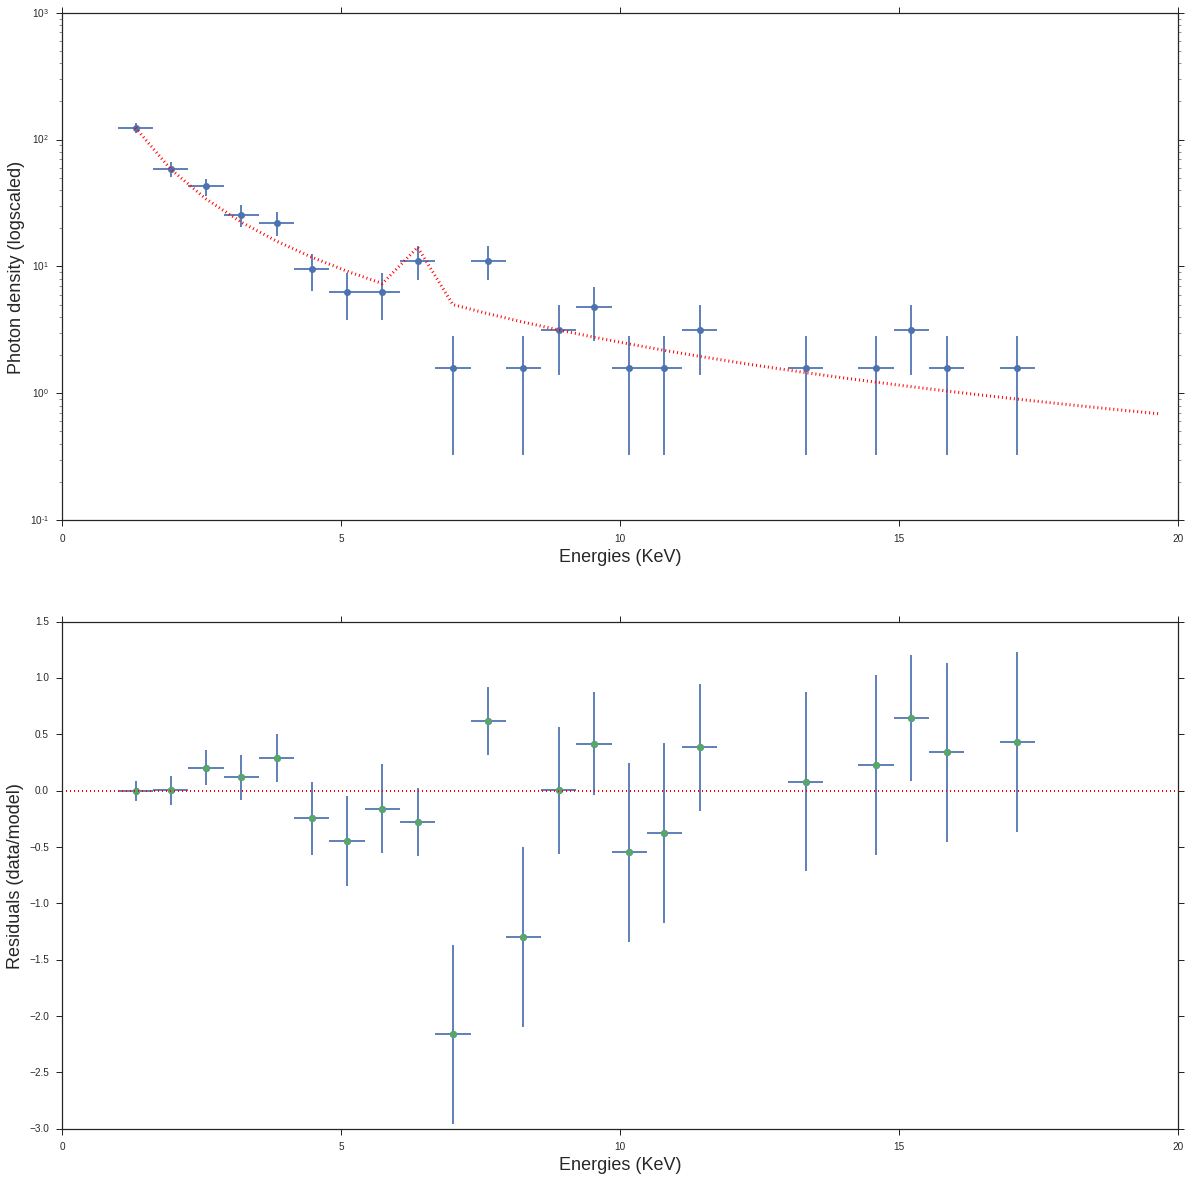

-------------------------------------------------
Seyfert
-------------------------------------------------
N0 = 208.075 +/-  14.374
gamma = 1.893 +/-  0.061
Loglikelyhood = -49.454 for 28 d.o.f.


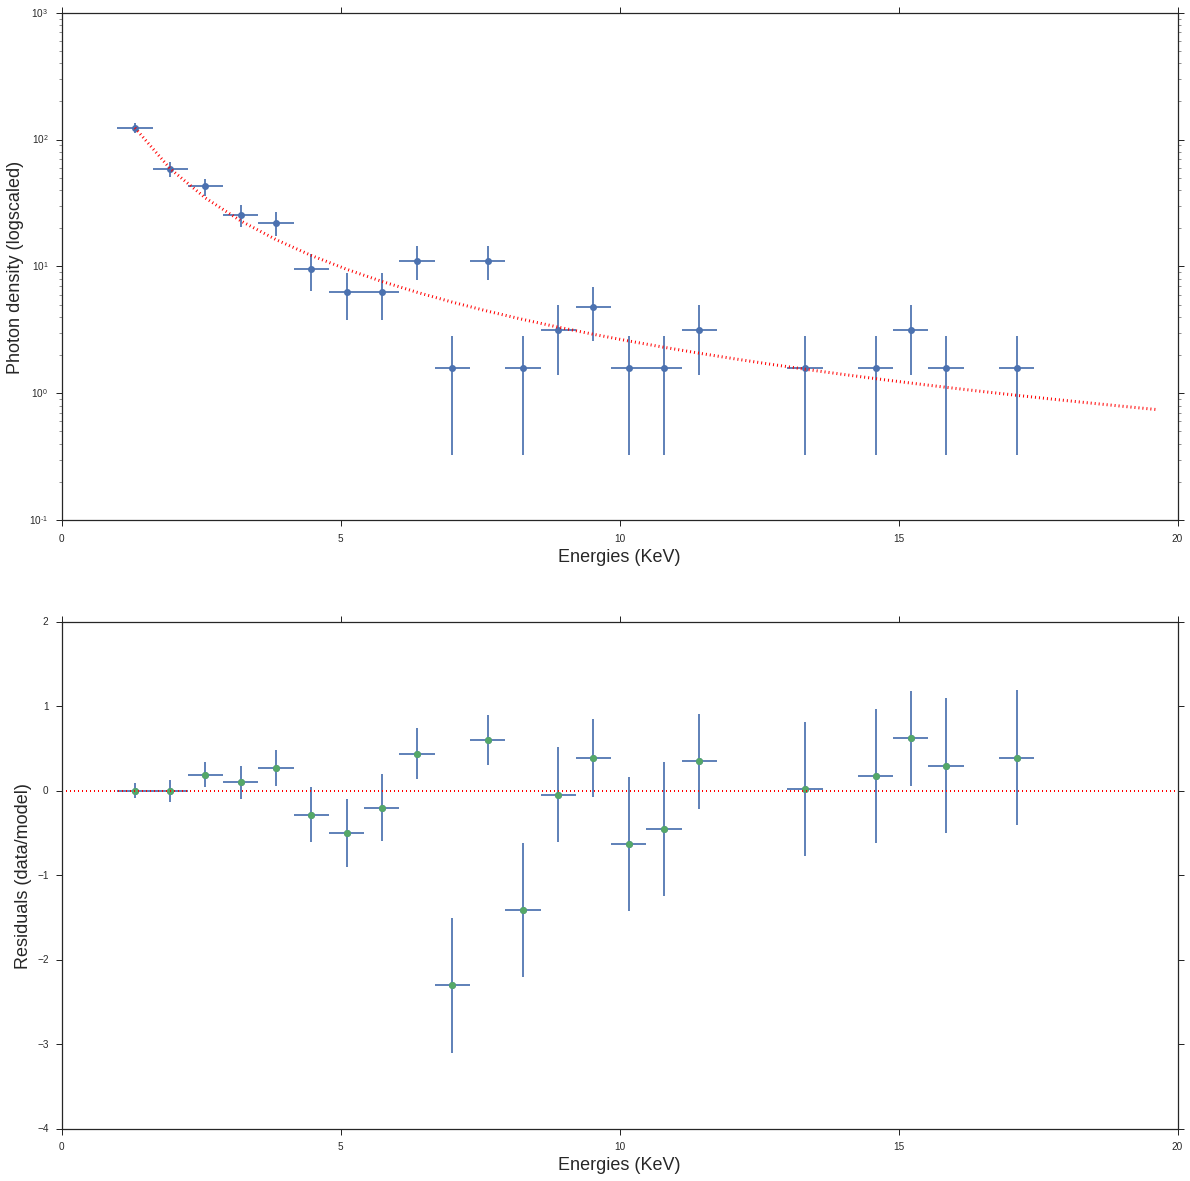

Delta chi-squared = -1.94
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant we chose to keep comparing with the Seyfertem
-------------------------------------------------
Blazar
-------------------------------------------------
N0 = 228.447 +/-  19.203
gamma = 2.000 +/-  0.060
Loglikelyhood = -50.102 for 28 d.o.f.


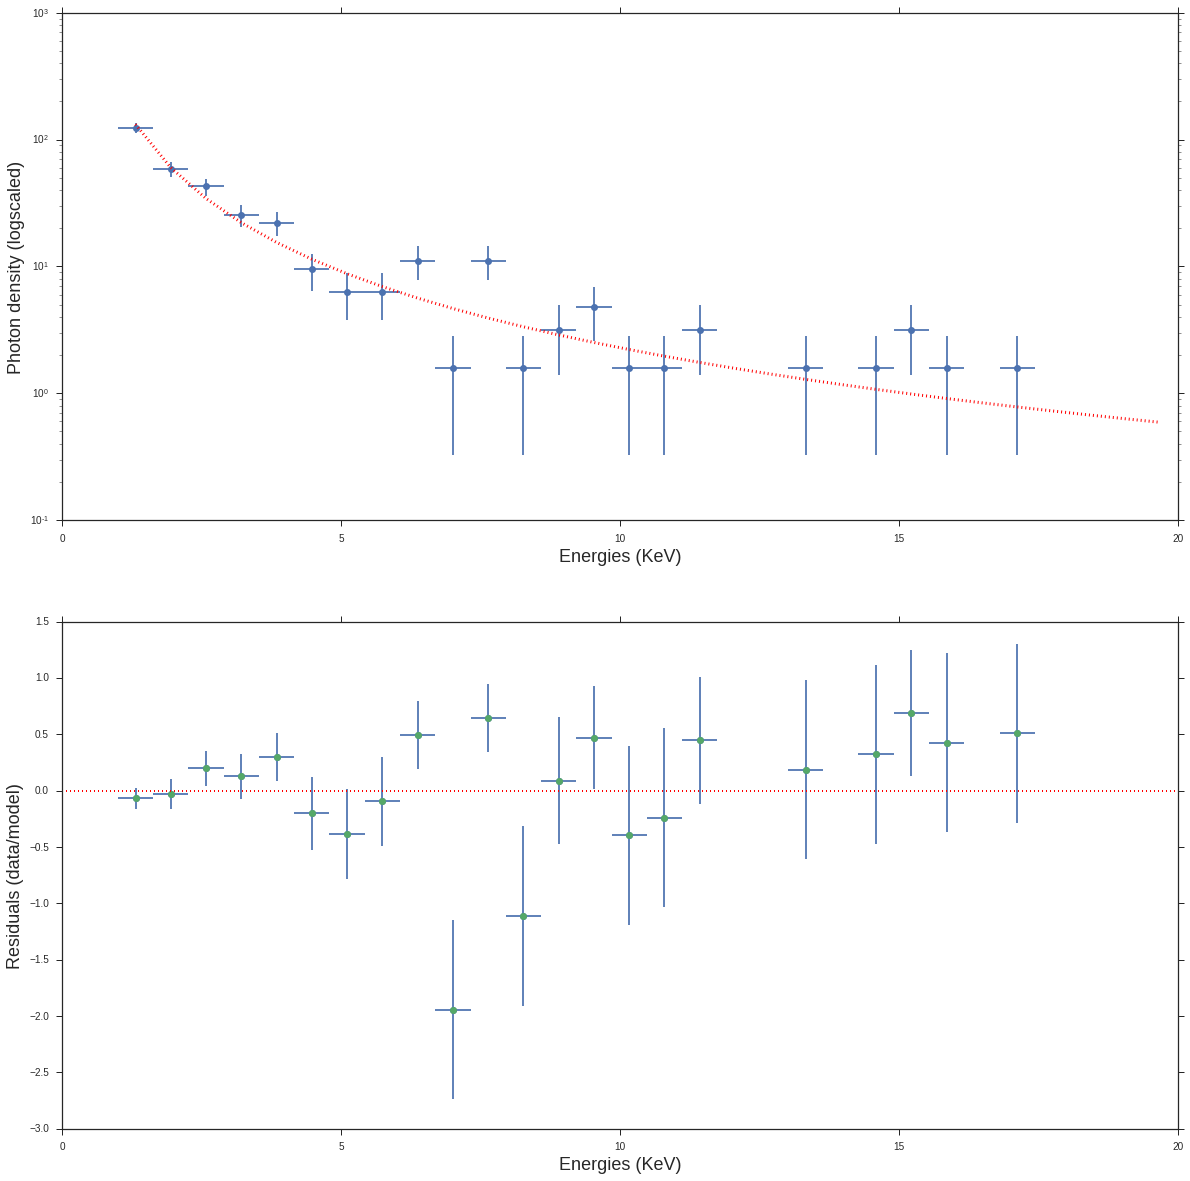

Delta chi-squared = -3.24
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant we chose to keep comparing with the Seyfertem
-------------------------------------------------
SNRe3
-------------------------------------------------
N0 = 272.241 +/-  19.357
gamma = 2.300 +/-  0.124
E_line1 = 2.000 +/-  1.000
Nlc1 = 0.000 +/-  0.998
E_line2 = 2.600 +/-  0.992
Nlc2 = 7.193 +/-  5.177
E_line3 = 6.400 +/-  0.941
Nlc3 = 4.664 +/-  2.699
Loglikelyhood = -54.553 for 22 d.o.f.


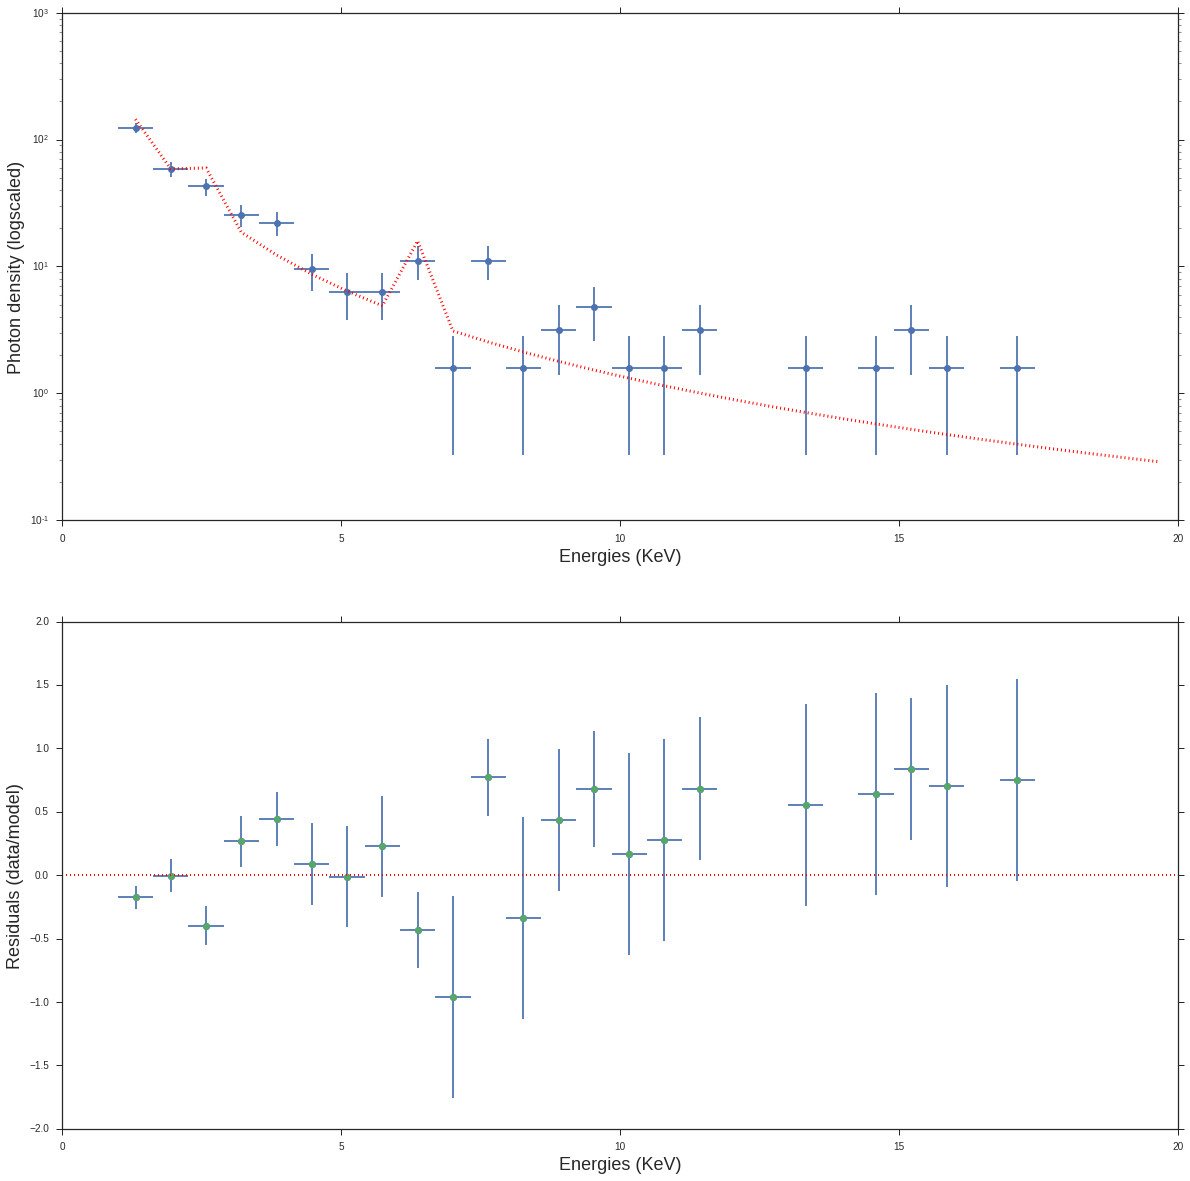

Delta chi-squared = 12.14
p-value for our delta-chi-squared: 0.000493
p-value corrected for number of trials: 0.000493, which corresponds to a 3-sigma confidence level
which is significant however let us first compare Seyfertem with the other models
-------------------------------------------------
SNRe2
-------------------------------------------------
N0 = 279.100 +/-  20.646
gamma = 2.300 +/-  0.110
E_line1 = 2.000 +/-  1.000
Nlc1 = 0.000 +/-  0.998
E_line2 = 2.600 +/-  0.994
Nlc2 = 6.692 +/-  4.939
Loglikelyhood = -57.261 for 24 d.o.f.


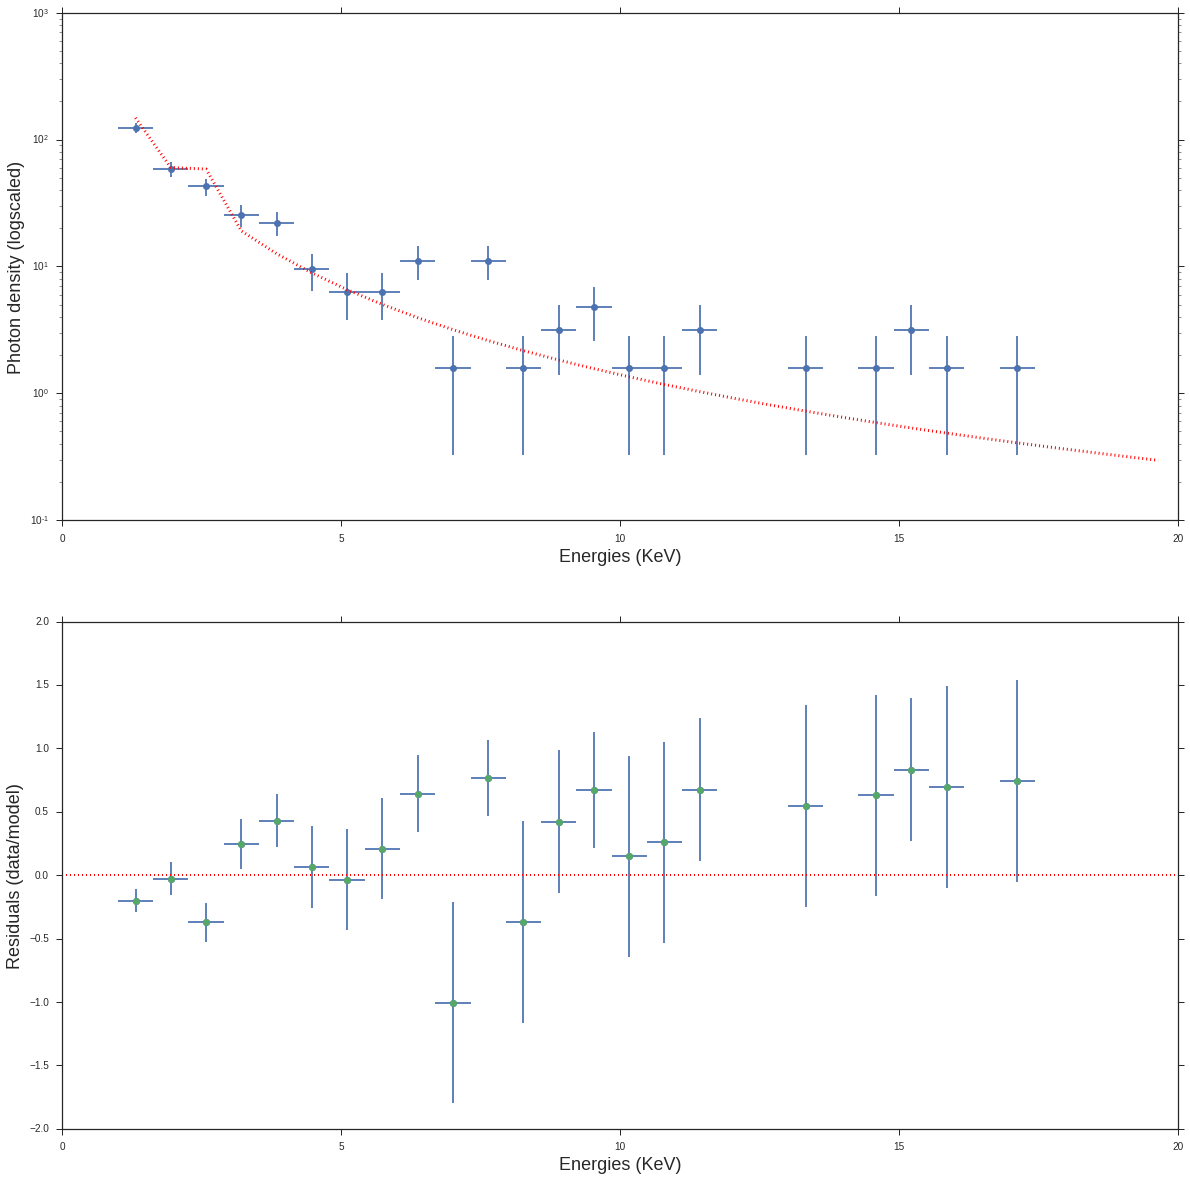

Delta chi-squared = 17.56
p-value for our delta-chi-squared: 2.79e-05
p-value corrected for number of trials: 2.79e-05, which corresponds to a 4-sigma confidence level
which is also significant however let us continue comparing Seyfertem with the other models since it has the same sigma confidence level as SNRe3
-------------------------------------------------
ULX
-------------------------------------------------
N0 = 194.708 +/-  15.675
gamma1 = 1.782 +/-  0.095
gamma2 = 2.723 +/-  0.566
E_break = 7.724 +/-  1.109
Loglikelyhood = -48.407 for 26 d.o.f.


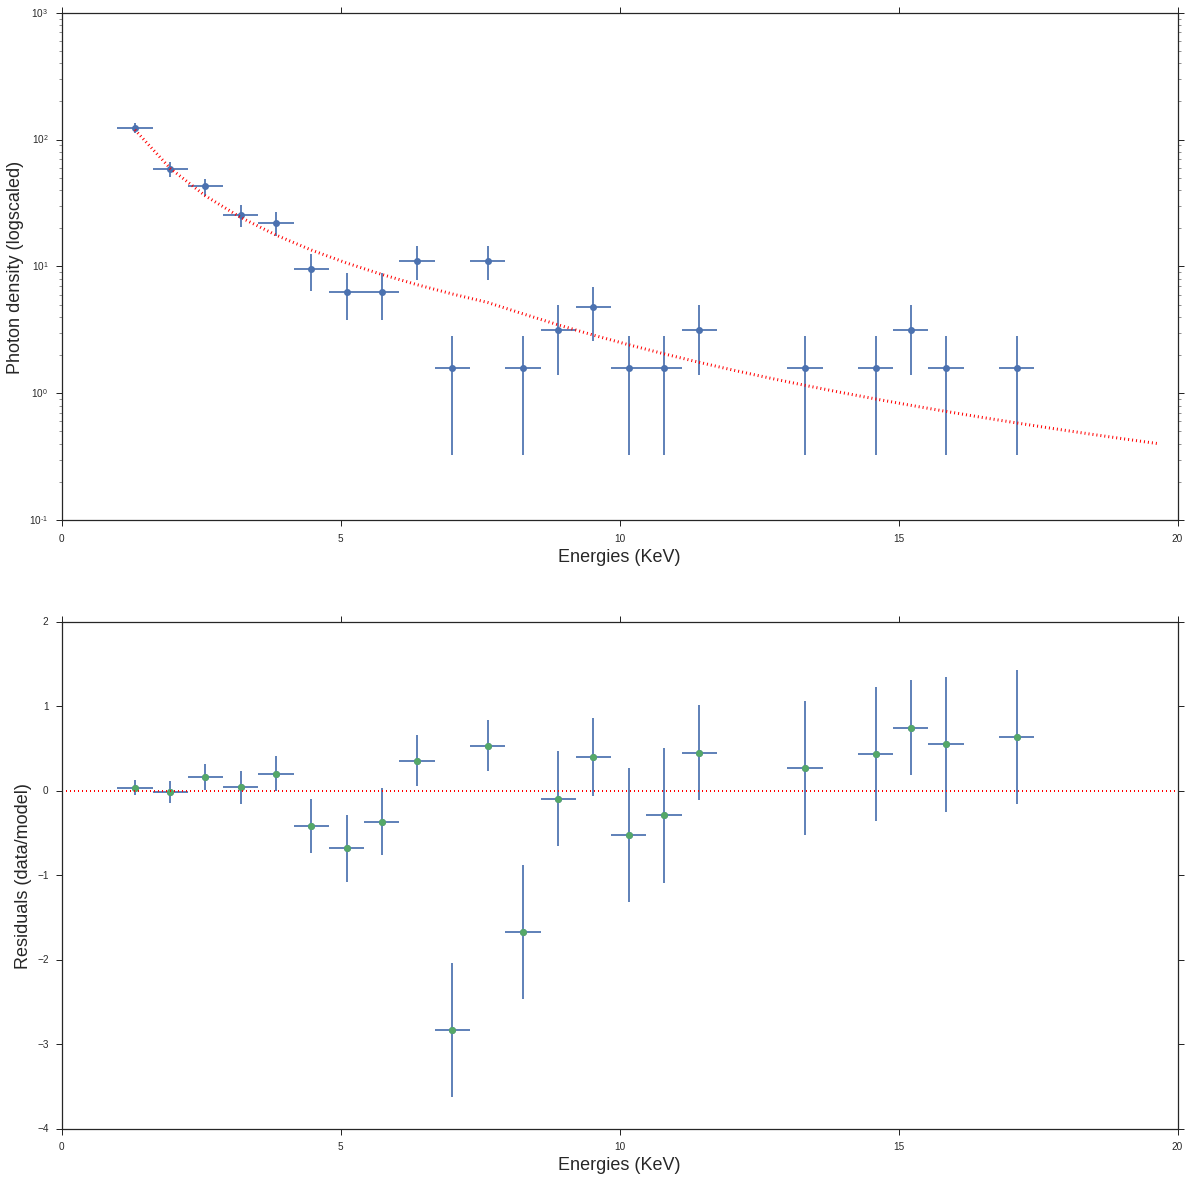

Delta chi-squared = -0.15
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is not significant we chose to keep comparing with the Seyfertem
-------------------------------------------------
ULXe
-------------------------------------------------
N0 = 229.450 +/-  19.200
gamma = 1.600 +/-  0.065
E_cut = 9.000 +/-  0.835
Loglikelyhood = -49.863 for 27 d.o.f.


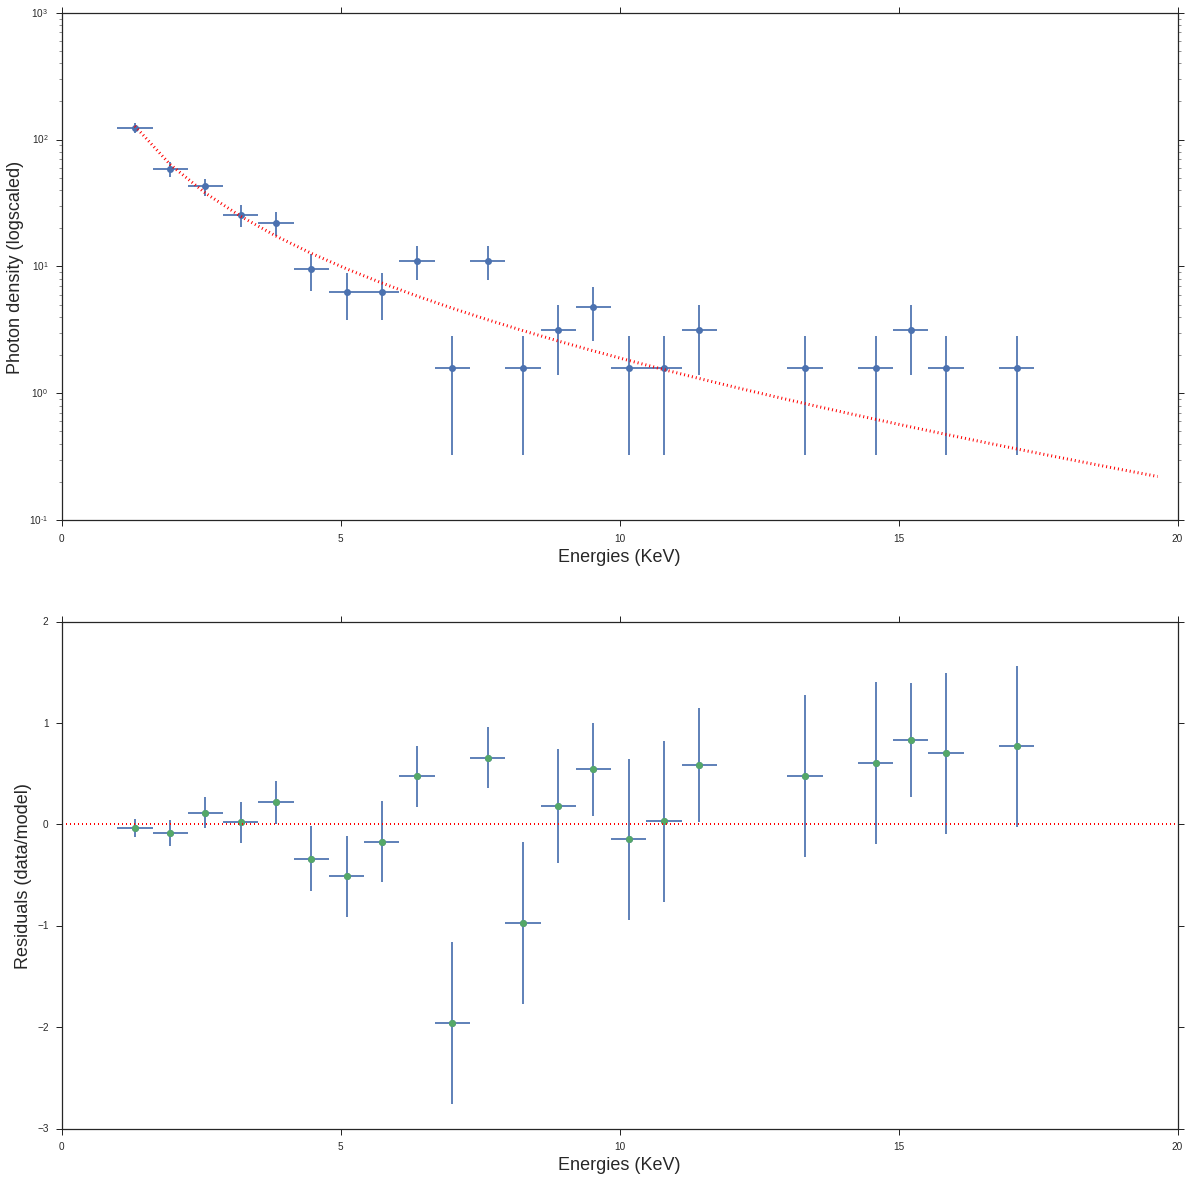

Delta chi-squared = 2.76
p-value for our delta-chi-squared: 0.0965
p-value corrected for number of trials: 0.0965, which corresponds to a 1-sigma confidence level
which is not significant we chose to keep comparing with the Seyfertem


In [369]:
print "With star 8 we have quite the conundrum since all the models,save the XRB model, come close to each others log-likelyhood "
print "In order to solve this we chose to compare all models to the model with the lowest log-likelyhood ,which is the Seyfertem model."

print"-------------------------------------------------"
print"Seyfertem"
print"-------------------------------------------------"

i = 7
j = 7

printSNR(i,j,False,1,True)

Stars.instances[i].my_model = Stars.instances[i].SNRe1
plotstuff(i,j,False)


print"-------------------------------------------------"
print"Seyfert"
print"-------------------------------------------------"

i = 7
j = 6

printSNR(i,j,False,0,True)

Stars.instances[i].my_model = Stars.instances[i].SNR
plotstuff(i,j,False)


dchisq = 2*(Stars.instances[i].inilog[j] - Stars.instances[i].inilog[7])
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant we chose to keep comparing with the Seyfertem"

print"-------------------------------------------------"
print"Blazar"
print"-------------------------------------------------"

i = 7
j = 5

printSNR(i,j,False,0,True)

Stars.instances[i].my_model = Stars.instances[i].SNR
plotstuff(i,j,False)


dchisq = 2*(Stars.instances[i].inilog[j] - Stars.instances[i].inilog[7])
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant we chose to keep comparing with the Seyfertem"

print"-------------------------------------------------"
print"SNRe3"
print"-------------------------------------------------"

i = 7
j = 4

printSNR(i,j,False,3,True)

Stars.instances[i].my_model = Stars.instances[i].SNRe3
plotstuff(i,j,False)


dchisq = 2*(Stars.instances[i].inilog[7] - Stars.instances[i].inilog[j])
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is significant however let us first compare Seyfertem with the other models"

print"-------------------------------------------------"
print"SNRe2"
print"-------------------------------------------------"

i = 7
j = 3

printSNR(i,j,False,2,True)

Stars.instances[i].my_model = Stars.instances[i].SNRe2
plotstuff(i,j,False)


dchisq = 2*(Stars.instances[i].inilog[7] - Stars.instances[i].inilog[j])
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is also significant however let us continue comparing Seyfertem with the other models since it has the same sigma confidence level as SNRe3"

print"-------------------------------------------------"
print"ULX"
print"-------------------------------------------------"

i = 7
j = 1

printULX(i,j,False,0,True)

Stars.instances[i].my_model = Stars.instances[i].ULX
plotstuff(i,j,False)


dchisq = 2*(Stars.instances[i].inilog[7] - Stars.instances[i].inilog[j])
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant we chose to keep comparing with the Seyfertem"

print"-------------------------------------------------"
print"ULXe"
print"-------------------------------------------------"

i = 7
j = 0

printULXe(i,j,False,0,True)

Stars.instances[i].my_model = Stars.instances[i].ULXe
plotstuff(i,j,False)


dchisq = 2*(Stars.instances[i].inilog[7] - Stars.instances[i].inilog[j])
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is not significant we chose to keep comparing with the Seyfertem"

With that out of the way it appears that both SNRe2 as SNRe3 have a good enough sigma confidence level to accept over our initialSeyfertem model
So now we will compare the two of them with each other starting with the one with the lowest log-likelyhood namely: SNRe3
-------------------------------------------------
SNRe3
-------------------------------------------------
N0 = 272.241 +/-  19.357
gamma = 2.300 +/-  0.124
E_line1 = 2.000 +/-  1.000
Nlc1 = 0.000 +/-  0.998
E_line2 = 2.600 +/-  0.992
Nlc2 = 7.193 +/-  5.177
E_line3 = 6.400 +/-  0.941
Nlc3 = 4.664 +/-  2.699
Loglikelyhood = -54.553 for 22 d.o.f.


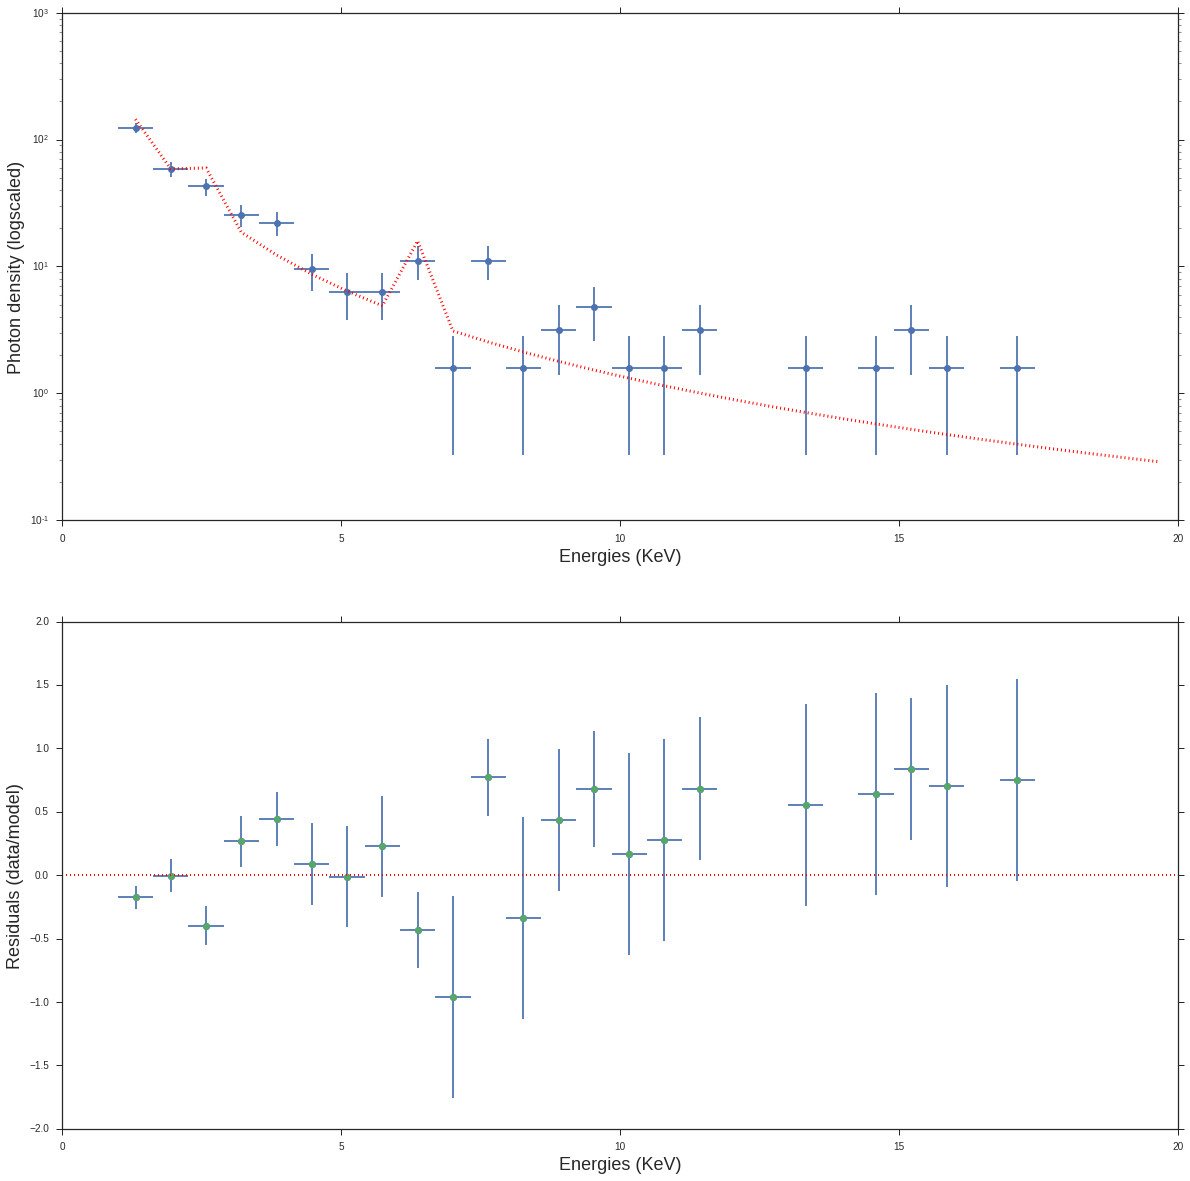

-------------------------------------------------
SNRe2
-------------------------------------------------
N0 = 279.100 +/-  20.646
gamma = 2.300 +/-  0.110
E_line1 = 2.000 +/-  1.000
Nlc1 = 0.000 +/-  0.998
E_line2 = 2.600 +/-  0.994
Nlc2 = 6.692 +/-  4.939
Loglikelyhood = -57.261 for 24 d.o.f.


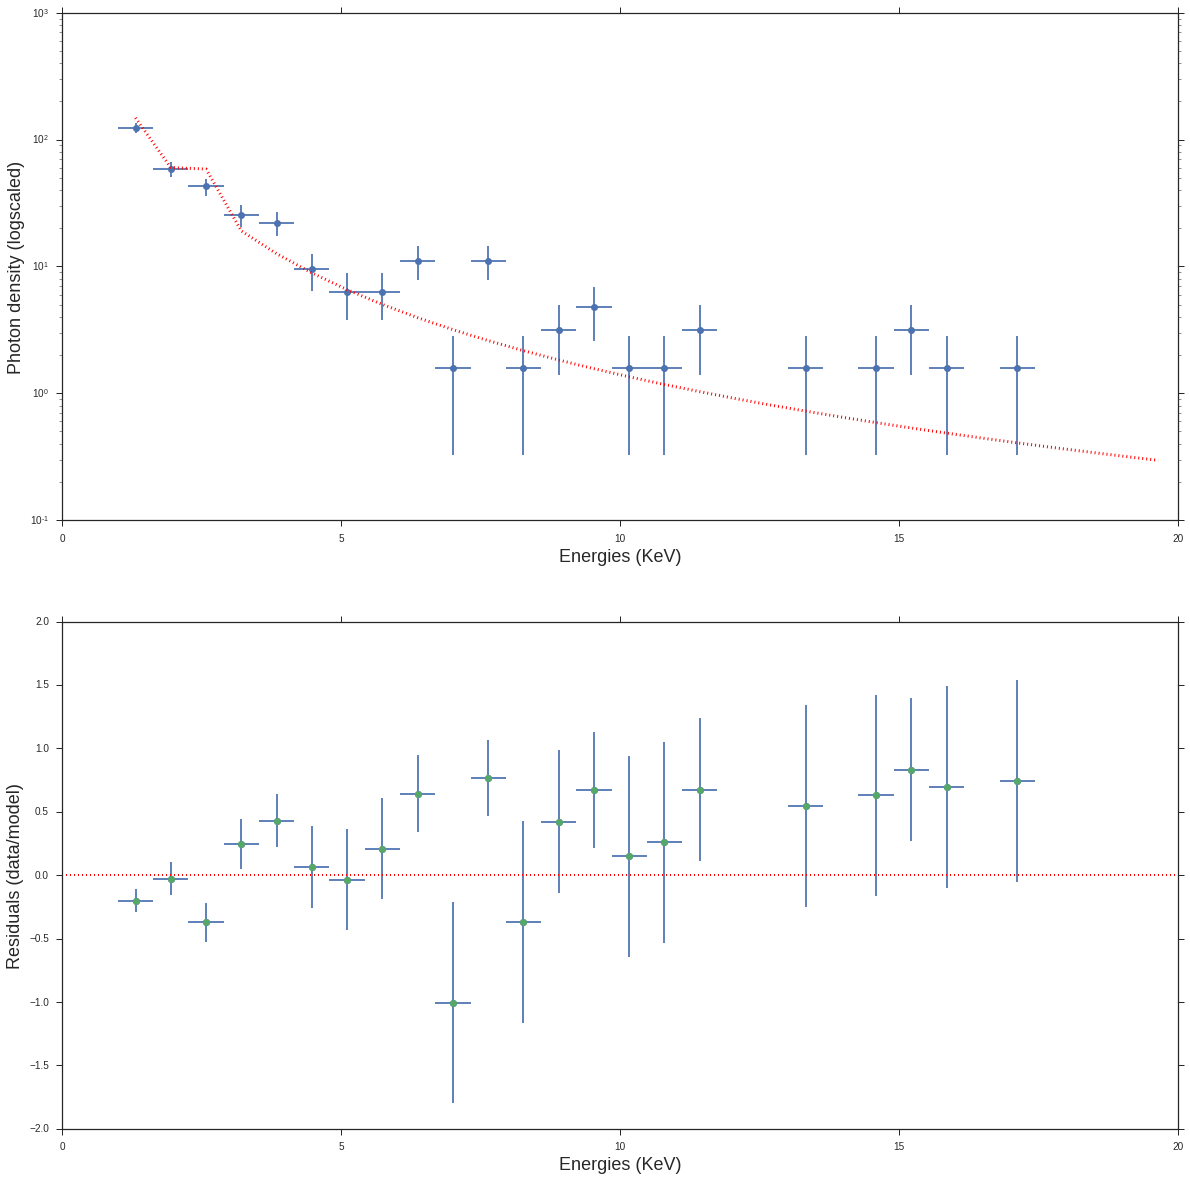

Delta chi-squared = -5.42
p-value for our delta-chi-squared: 1
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant
----------------------------------------------------------------------
This means that the unaltered SNRe3 out of our standard models seems to be the best fit. however for a log-likelyhood of -54.6


In [370]:
print "With that out of the way it appears that both SNRe2 as SNRe3 have a good enough sigma confidence level to accept over our initial\
Seyfertem model"
print "So now we will compare the two of them with each other starting with the one with the lowest log-likelyhood namely: SNRe3"


print"-------------------------------------------------"
print"SNRe3"
print"-------------------------------------------------"

i = 7
j = 4

printSNR(i,j,False,3,True)

Stars.instances[i].my_model = Stars.instances[i].SNRe3
plotstuff(i,j,False)


print"-------------------------------------------------"
print"SNRe2"
print"-------------------------------------------------"

i = 7
j = 3

printSNR(i,j,False,2,True)

Stars.instances[i].my_model = Stars.instances[i].SNRe2
plotstuff(i,j,False)


dchisq = 2*(Stars.instances[i].inilog[j] - Stars.instances[i].inilog[4])
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),1)
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant"
print"----------------------------------------------------------------------"
print "This means that the unaltered SNRe3 out of our standard models seems to be the best fit. however for a log-likelyhood of %.3g" % Stars.instances[i].inilog[4]


# Star 8 Results

Out of all the models we tested the SNRe3 model seemed the best fit. However, with a log-likelyhood of only -57.3 it seems likely that an unknown model might fit our data better.

Parameters:
N0 = 272.241 +/-  19.357
gamma = 2.300 +/-  0.124
E_line1 = 2.000 +/-  1.000
Nlc1 = 0.000 +/-  0.998
E_line2 = 2.600 +/-  0.992
Nlc2 = 7.193 +/-  5.177
E_line3 = 6.400 +/-  0.941
Nlc3 = 4.664 +/-  2.699
Loglikelyhood = -54.553 for 22 d.o.f.


## Star 9 Evaluation

Selecting the best goodness of fit amongst our initial supplied models we get the ULXe model best describing Star6 datawith:
N0 = 12029.314 +/-  171.088
gamma = 1.673 +/-  0.007
E_cut = 7.507 +/-  0.119
Minimum Chi-squared = 75.501 for 68 d.o.f.
The goodness of fit is: 0.249


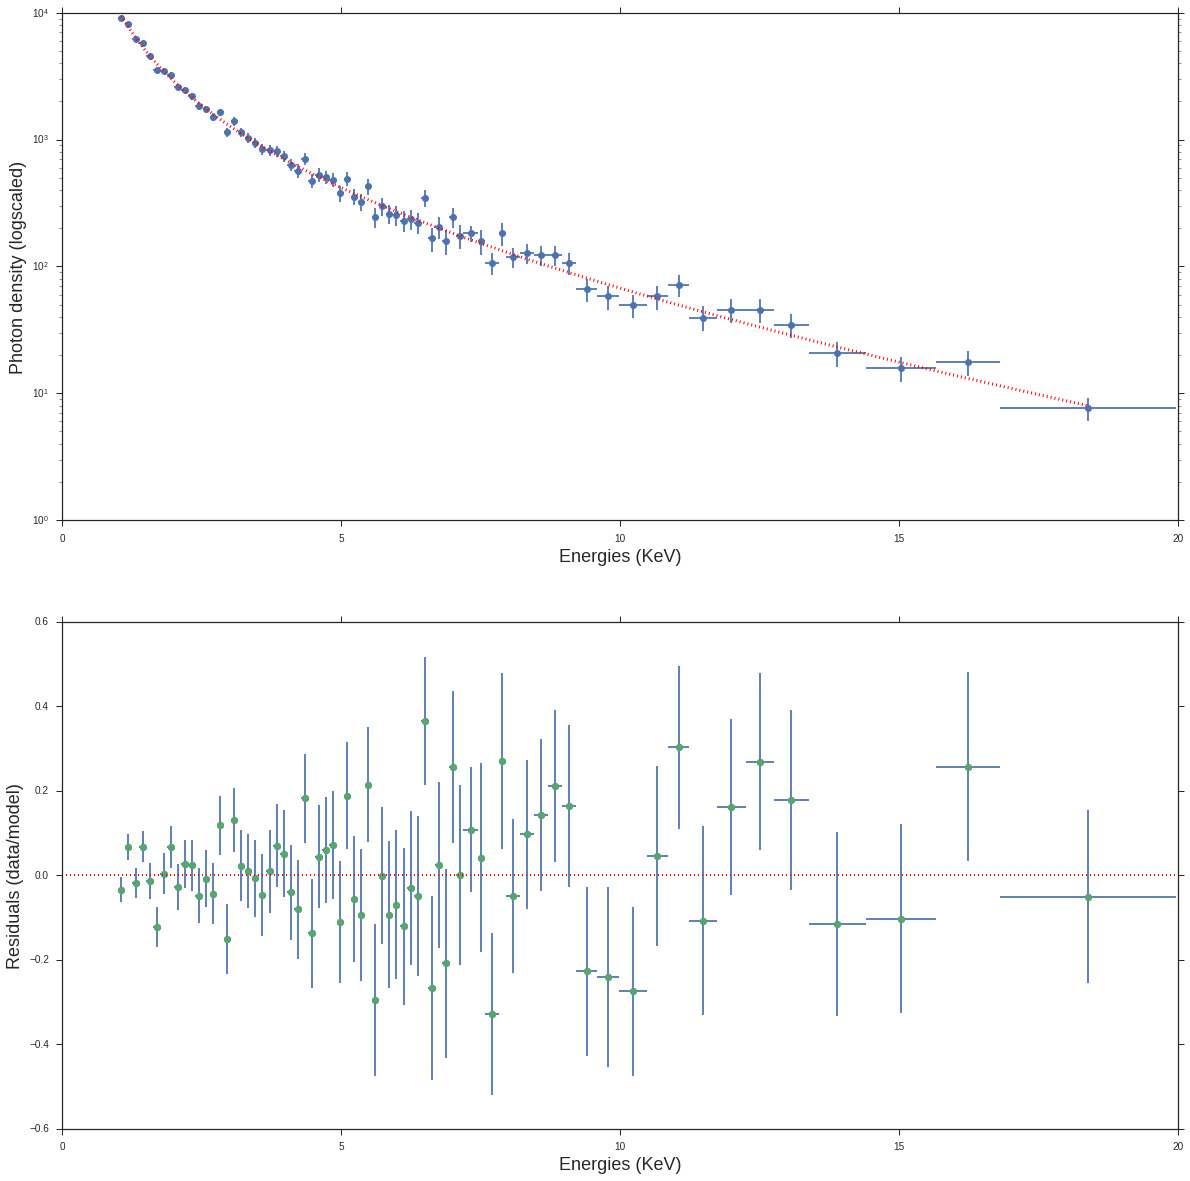

Looking at the plots and the residuals tthere could be an absorption line around 10 KeV
So we will try to fit an guassian to that spot to see if an absorption line improves the fit
-----------------------------------------------------
N0 = 11984.906 +/-  85.627
gamma = 1.679 +/-  0.007
E_cut = 7.730 +/-  0.119
E_line = 10.000 +/-  0.631
Nlc = -13.897 +/-  5.693
Minimum Chi-squared = 71.906 for 66 d.o.f.
The goodness of fit is: 0.289


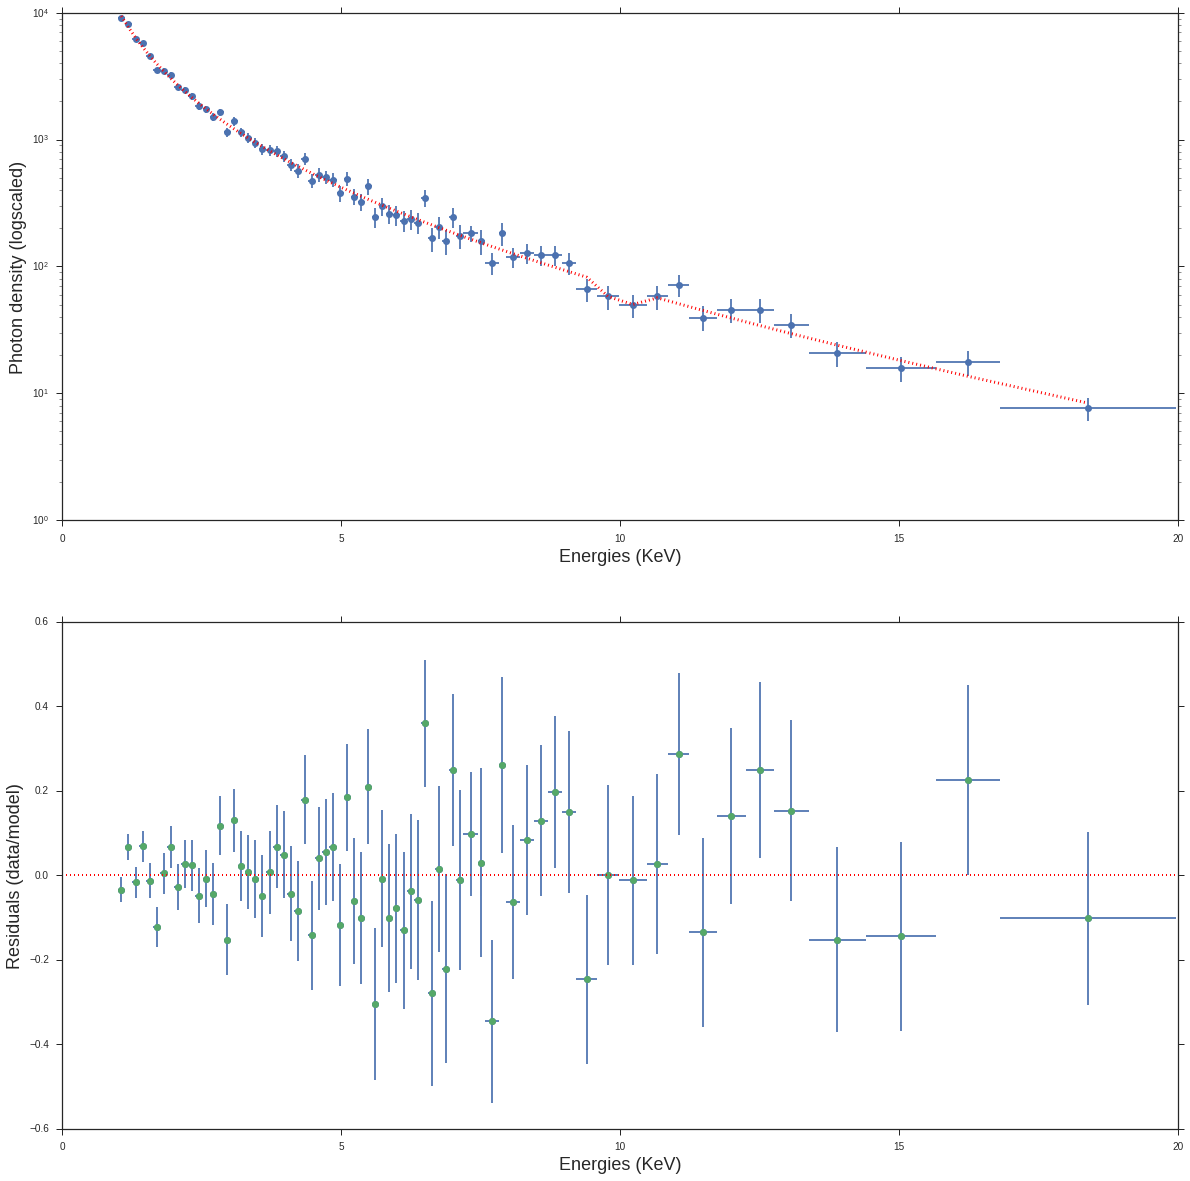

Delta chi-squared = 3.59
p-value for our delta-chi-squared: 0.058
10.0
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose not to alter our model
---------------------------------------------------------
there could also be an emission line around KeV 16 so we tried fitting that aswell
N0 = 12045.662 +/-  128.574
gamma = 1.664 +/-  0.007
E_cut = 7.334 +/-  0.103
E_line = 16.261 +/-  0.811
Nlc = 5.526 +/-  3.325
Minimum Chi-squared = 74.137 for 66 d.o.f.
The goodness of fit is: 0.23


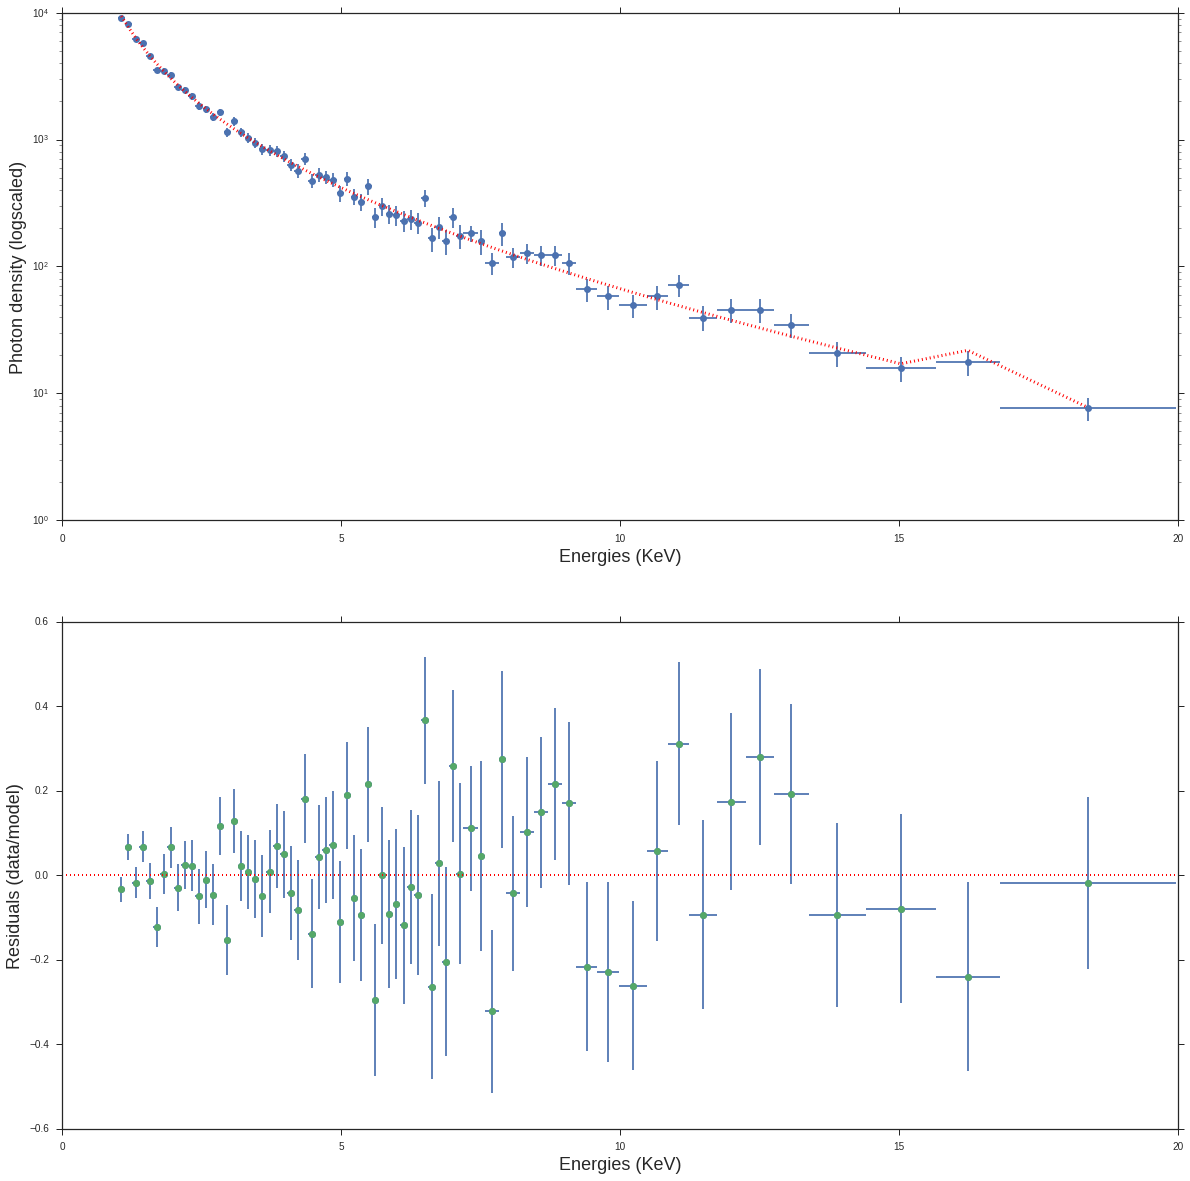

Delta chi-squared = 1.36
p-value for our delta-chi-squared: 0.243
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose not to alter our model
---------------------------------------------------------
This means that our source out of the models we tested likely is an Ultra luminious Xray source,the goodness of fit of 0.249


In [371]:

i = 8
j = 0
print "Selecting the best goodness of fit amongst our initial supplied models we get the ULXe model best describing Star6 data\
with:"

printULXe(i,j,False,0,False)

Stars.instances[i].my_model = Stars.instances[i].ULXe
plotstuff(i,j,False)

print "Looking at the plots and the residuals tthere could be an absorption line around 10 KeV"
print "So we will try to fit an guassian to that spot to see if an absorption line improves the fit"
print "-----------------------------------------------------"

Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minchisq = []
Stars.instances[i].mindof = []
Stars.instances[i].mingood = []
Stars.instances[i].my_model = Stars.instances[i].ULXeem
p0=[]
p0 = ULXeinitials[0][:]
p0.append(11)
p0.append(-50)
bounds=[]
bounds = ULXeinitials[1][:]
bounds.append((10,12))
bounds.append((-100,100))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 0
em = 1
printULXe(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval
print (Stars.instances[i].minresult[g][3])
pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06 * np.sqrt(Stars.instances[i].minresult[g][3])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose not to alter our model"
print "---------------------------------------------------------"
print "there could also be an emission line around KeV 16 so we tried fitting that aswell"
p0=[]
p0 = ULXeinitials[0][:]
p0.append(16)
p0.append(20)
bounds=[]
bounds = ULXeinitials[1][:]
bounds.append((15.5,17))
bounds.append((-100,100))

result =  op.minimize(Stars.instances[i].ChiSq_Integ, p0, args=(Stars.instances[i].edges2,Stars.instances[i].y\
                                                                       ,Stars.instances[i].yerr), method='L-BFGS-B', 
                     bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminchisq(result.fun) # value of the function minimised (e.g. chi-squared)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmingood(ss.chi2.sf(result.fun, df=dof))
Stars.instances[i].appendmindof(dof)

g = 1
em = 1
printULXe(i,g,True,em,False)

plotstuff(i,g,True)

dchisq = Stars.instances[i].inichisq[j] - Stars.instances[i].minchisq[g]
print 'Delta chi-squared = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-chi-squared: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06 * np.sqrt(Stars.instances[i].minresult[g][3])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose not to alter our model"
print "---------------------------------------------------------"
print "This means that our source out of the models we tested likely is an Ultra luminious Xray source,the goodness of fit of %0.3g" %Stars.instances[i].inigoodness[j]


# Star 9 Results

We found that the ULXe model best describes our data out of the models we tested. However, with a goodness of fit of 0.249 our data could also ,likely, be described by some unknown model.

Parameters:
N0 = 12029.314 +/-  171.088
gamma = 1.673 +/-  0.007
E_cut = 7.507 +/-  0.119
Minimum Chi-squared = 75.501 for 68 d.o.f.
The goodness of fit is: 0.249

## Star 10 Evalutation

The only lognormal that really jumps out for star 10 is the one for the XRB model so we will evaluate that one further
-------------------------------------------------
N0 = 52.340 +/-  4.784
KbT = 1.200 +/-  0.023
Loglikelyhood = -36.486 for 28 d.o.f.


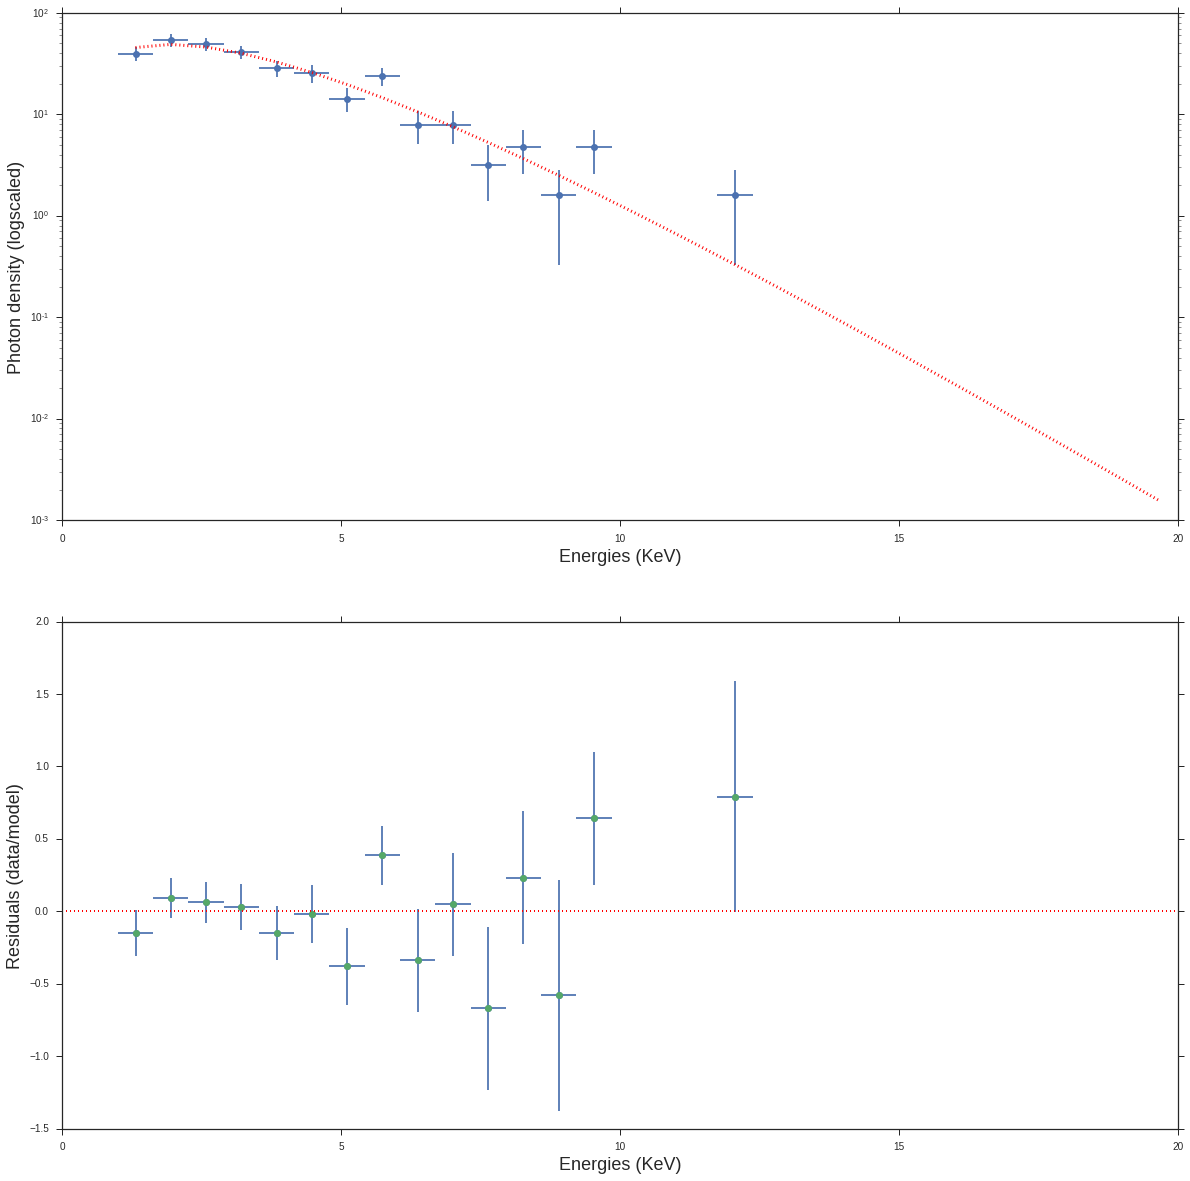

looking at the plot and the residuals there could be an emission or absorption line around 6 kev so we tried fitting one
N0 = 54.794 +/-  4.770
KbT = 1.171 +/-  0.043
E_line = 5.744 +/-  0.298
Nlc = 6.525 +/-  3.881
Loglikelyhood = -34.805 for 26 d.o.f.


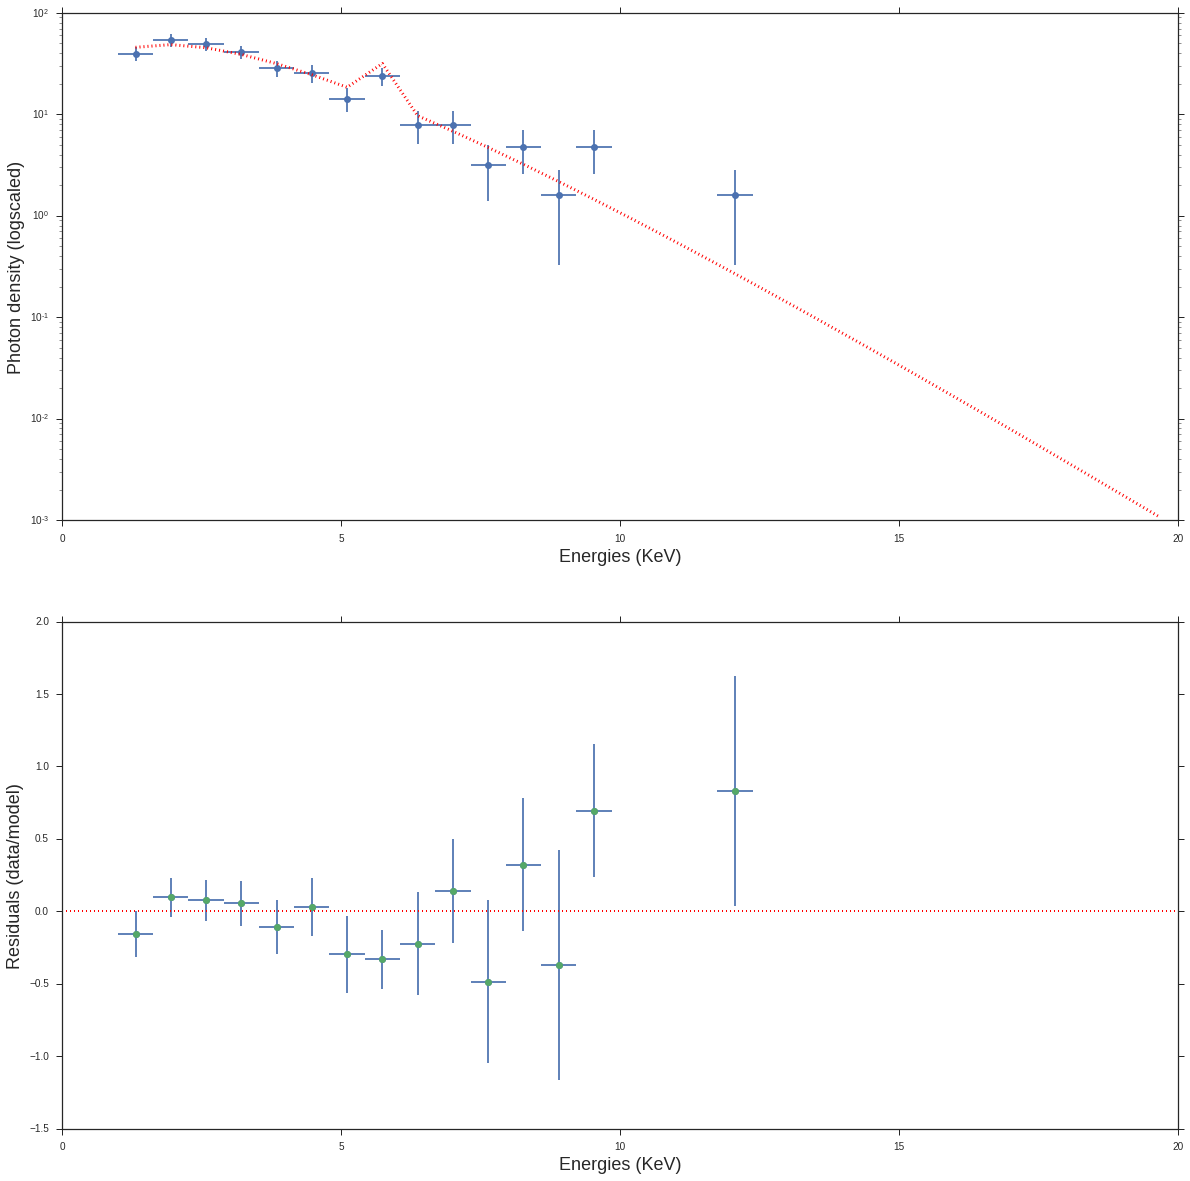

Delta log-likelyhood = 3.36
p-value for our delta-log-likelyhood: 0.0667
p-value corrected for number of trials: 1, which corresponds to a 0-sigma confidence level
which is insignificant so we chose to not alter our model
----------------------------------------------------------
This means that our unaltered XRB model out of our standard models seems to be the best fit. With a log-likelyhood of -36.5


In [372]:
print "The only lognormal that really jumps out for star 10 is the one for the XRB model so we will evaluate that one further"
print"-------------------------------------------------"

i = 9
j = 2
printXRB(i,j,False,0,True)

Stars.instances[i].my_model = Stars.instances[i].XRB
plotstuff(i,j,False)

print "looking at the plot and the residuals there could be an emission or absorption line around 6 kev so we tried fitting one"
Stars.instances[i].my_model = Stars.instances[i].XRBem
Stars.instances[i].minresult = []
Stars.instances[i].minerror = []
Stars.instances[i].minlog = []
Stars.instances[i].mindof = []
p0=[]
p0 = XRBinitials[0][:]
p0.append(6)
p0.append(20)
bounds=[]
bounds = XRBinitials[1][:]
bounds.append((5.5,6))
bounds.append((-100,100))

g=0

result = op.minimize(Stars.instances[i].LogLikelihood_Pois_Integ, p0, args=(Stars.instances[i].edges, Stars.instances[i].counts), method='L-BFGS-B', bounds=bounds)
Stars.instances[i].appendminresult(result.x) # best-fitting parameter values
Stars.instances[i].appendminerror(np.sqrt(np.diag(1. / np.linalg.inv(result.hess_inv.todense()))))
Stars.instances[i].appendminlog(-1.0*result.fun)
dof = len(Stars.instances[i].y) - len(p0)
Stars.instances[i].appendmindof(dof)

printXRB(i,g,True,1,True)
plotstuff(i,g,True)

dchisq = 2*(Stars.instances[i].minlog[g] - Stars.instances[i].inilog[j])
print 'Delta log-likelyhood = %.2f' % dchisq

chi2 = ss.chi2(1)
pval = chi2.sf(dchisq)
print "p-value for our delta-log-likelyhood: %.3g" % pval

pvalcorr = 1.0-np.power((1.0-pval),len(Stars.instances[i].y)/(0.06 * np.sqrt(Stars.instances[i].minresult[g][2])))
sigmalevel = np.floor(p_to_sigmas(pvalcorr))
print "p-value corrected for number of trials: %.3g, which corresponds to a %i-sigma confidence level" % (pvalcorr, (sigmalevel))
print "which is insignificant so we chose to not alter our model"
print "----------------------------------------------------------"
print "This means that our unaltered XRB model out of our standard models seems to be the best fit. With a log-likelyhood of %.3g" % Stars.instances[i].inilog[j]


# Star 10 Results

We found that an XRB model out of our standard models seems to fit the data best. With a log-likelyhood of -36.5, it seems quite likely that the model would fit the data over some unknown model.